In [1]:
from matplotlib import pyplot
from sklearn import metrics
from scipy import stats as scst
import re
import time
import mysql.connector
import os
import pandas as pd
import numpy as np
import timeit
import re
import math
import helper_functions as hf
# import MKA_FE
# import MKAM_FE
# import CCRCAA_FE
# import CFI_FE
# import CI_FE
# import CRH_FE
# import WP_FE
from functools import reduce
from IPython.display import display
import pandas as pd
import numpy as np
import datetime
import feather
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate, GridSearchCV
from matplotlib import pyplot
from sklearn.pipeline import Pipeline
from sklearn2pmml import sklearn2pmml, PMMLPipeline
from sklearn.preprocessing import LabelBinarizer
from sklearn_pandas import DataFrameMapper
from sklearn2pmml.decoration import CategoricalDomain
from sklearn2pmml.decoration import ContinuousDomain
from bayes_opt import BayesianOptimization
import pickle


<br/><br/>

<brc>

<brc>

<brc>

<brc>

# Call Clarity retro study (accepted leads with correct lead sequence id and features database name)

In [2]:
clarity_results = pd.read_pickle('clarity_retro_databasenames.pkl')

In [3]:
print(clarity_results.shape)

(19623, 1169)


<brc>

<brc>

<brc>

<brc>

<brc>

<brc>

<brc>

In [3]:
# all cf originated leads till Aug 2020, leave enough time for loan performance
from time import time
t0=time()

conn= mysql.connector.connect(option_files='.my.cnf', option_groups = 'mysqlconnection',use_pure=True)
data =  pd.read_sql("""

select ma.*,
(CASE
 WHEN ma.campaign_name='#CF-LENDINGTREE-SF#' THEN 'LendingTree'
  WHEN ma.campaign_name='#CF-QUINSTREET-SF#' THEN 'QuinStreet'
  when ma.lead_provider_name='CreditSesame CF' then 'CreditSesame'
  WHEN (right(ma.campaign_name,4) = '-OH#') THEN 'MK Redirects'
 When ma.lead_provider_name = 'CreditFresh Internal' and ma.campaign_name<>'#CF-LENDINGTREE-SF#' and ma.campaign_name<>'#CF-QUINSTREET-SF#' THEN 'Organic'
 WHEN (right(ma.lead_provider_name,2) = 'SF') THEN 'Short Form'
 WHEN (ma.campaign_name like '%LINC%' or ma.campaign_name='LECCF-ALL-DT') THEN 'LeadGen-LINC'
 WHEN ma.payfrequency='M' THEN 'LeadGen-M'
 ELSE 'LeadGen-NM'
 END ) as 'channel'
 #'caa', caa.*, 'cca', cca.*, 'cia', cia.*, 'ccr', ccr.*, 'cbb' , cbb.*, 'cfi', cfi.*, 'ci', ci.*, 'crh', crh.*, 'wp', wp.*,
 #FA.state_aba, FA.top50aba, FA.top100aba, FA.top150aba, FA.top250aba, FA.top350aba, FACF.top100aba as CF_top100aba
from datawork.mk_application ma
inner join reporting_cf.leads_accepted la on ma.lead_sequence_id = la.lead_sequence_id
left join datawork.mk_application_more mam on ma.lead_sequence_id = mam.lead_sequence_id
#left join datawork.mk_clearadvancedattributes caa on ma.lead_sequence_id = caa.lead_sequence_id
#left join datawork.mk_clearcreditattributes cca on ma.lead_sequence_id = cca.lead_sequence_id
#left join datawork.mk_clearincomeattributes cia on ma.lead_sequence_id = cia.lead_sequence_id
#left join datawork.mk_clearcreditrisk ccr on ma.lead_sequence_id = ccr.lead_sequence_id
#left join datawork.mk_clearbankbehavior cbb on ma.lead_sequence_id = cbb.lead_sequence_id
#left join datawork.mk_clearfraudinsight cfi on ma.lead_sequence_id = cfi.lead_sequence_id
#left join datawork.mk_clearinquiry ci on ma.lead_sequence_id = ci.lead_sequence_id
#left join datawork.mk_clearrecenthistory crh on ma.lead_sequence_id = crh.lead_sequence_id
#left join datawork.mk_whitepages wp on ma.lead_sequence_id = wp.lead_sequence_id
#left join jaglms.fed_aba FA on ma.routingnumber=FA.routingnumber
#left join temp.Fed_ABA_CF FACF on ma.routingnumber=FACF.routingnumber
#left join jaglms.lead_source ls on ls.lead_source_id = ma.lead_provider_id
where
ma.organization_id = 2
and la.isoriginated=1
and la.isreturning=0
and LOWER(ma.campaign_name) not like '%test%'
and ma.insert_date < '2020-08-01'
and ma.uw_stream not in (-1,16,24)
;""", 
                                  con = conn)
conn.close()
print("done in %0.3fs." % (time() - t0))
print(data.shape)


done in 87.849s.
(23611, 296)


In [4]:
#Save to pickle
data.to_pickle('data.pkl')

In [4]:
#Read saved pickle 
data = pd.read_pickle('data.pkl')

In [5]:
data.insert_date.max()

Timestamp('2020-07-31 20:25:58')

In [6]:
data.columns

Index(['id', 'lead_sequence_id', 'organization_id', '_delta_bankaccount_24h',
       '_delta_bankaccount_90d', '_delta_dl_24h', '_delta_dl_90d',
       '_delta_email_24h', '_delta_email_90d', '_delta_homephone_24h',
       ...
       '/DataxResponse/IDAIDSASegment/ScoreAction/ScoreResultCode2',
       '/DataxResponse/IDAIDSASegment/ScoreAction/ScoreResultCode3',
       '/DataxResponse/IDAIDSASegment/ScoreAction/ScoreResultCode4',
       '/DataxResponse/IDAIDSASegment/ScoreAction/ScoreResultCode5',
       '/DataxResponse/IDAIDSASegment/ScoreAction/Status',
       'orig_amt_requested', 'days_ago', 'wd_reason', 'lead_bid', 'channel'],
      dtype='object', length=296)

In [7]:
data.lead_sequence_id.nunique()

23608

In [8]:
data.state.unique()

array(['FL', 'KY', 'MI', 'IN', 'KS', 'WA', 'OH', 'IL', 'NE', 'SC', 'TX',
       'AL', 'UT', 'DE', 'MO'], dtype=object)

In [9]:
data.campaign_name.unique()

array(['ZPCF-FL-DT', 'SFLCF-KY-DT', 'ZPCF-MI-DT', 'ZPCF-KY-DT',
       'EPCCF-MI-DT', 'SFLCF-FL-DT', 'EPCCF-KY-DT', 'ZPCF-FL-PR',
       'EPCCF-IN-DT', 'EPCCF-FL-DT', 'ZPCF-MI-PR', 'ZPCF-KY-PR',
       'SFLCF-IN-PR', 'LEAPCF-IN-DT', 'SFLCF-MI-PR', 'LEAPCF-MI-DT',
       'ACQCF-KY-DT', 'ACQCF-FL-DT', 'SFLCF-IN-DT', 'SFLCF-FL-PR',
       'LFCF-KY-DT', 'ACQCF-IN-DT', 'LFCF-FL-DT', 'LMCF-FL-DT',
       'LMCF-KY-DT', 'LFCF-IN-DT', 'ACQCF-MI-DT', 'LMCF-IN-PR',
       'LMCF-MI-DT', 'LMCF-FL-PR', 'LMCF-KY-PR', 'LFCF-IN-PR',
       'LMCF-MI-PR', 'LFCF-FL-PR', 'RSCF-ALL-PR', 'RSCF-ALL-DT',
       'ZPCF-ALL-PR', 'ZPCF-ALL-DT', 'LEAPCF-FL-PR', 'LEAPCF-ALL-PR',
       'LEAPCF-ALL-DT', 'ACQCF-ALL-DT', 'SFLCF-ALL-DT', 'LFCF-ALL-PR',
       'ACQCF-ALL-PR', 'LMCF-ALL-PR', 'SFLCF-ALL-PR', 'LMCF-ALL-DT',
       'LFCF-ALL-DT', 'ZPCF-ALL-31', 'PLCF-ALL-PR', 'PLCF-ALL-DT',
       'LFCF-ALL-56', 'SFLCF-ALL-56', 'ITMCF-ALL-PR', 'LM-ALL-56',
       'ITMCF-ALL-DT', 'LMCF-ALL-56', 'EPCCF-ALL-DT', 'EPCCF-ALL-PR',

In [10]:
data.lead_provider_name.unique()

array(['Zero Parallel CF', 'SFL CF', 'EPCVIP CF', 'Leap Theory CF',
       'Acquire Interactive CF', 'Lead Flash CF', 'Leads Market CF',
       'Round Sky CF', 'Ping Logix CF', 'ITMedia CF',
       'CreditFresh Internal', 'Bloom CF', 'PingYo CF', 'Fix Media CF',
       'Lead Toro CF', 'Lead Economy CF', 'Lead Flash CF SF',
       'Search ROI CF SF', 'LendingTree CF', 'ITM CF SF', 'Quinstreet CF',
       'CreditSesame CF', 'TU Email CF', 'Discover Nimbus', 'Goalry CF',
       'Discover Nimbus CF', 'MegaConnect CF'], dtype=object)

In [11]:
data.uw_stream.unique()

array(['31', '29', '38', '46', '44', '45', '49', '48'], dtype=object)

In [12]:
data.channel.unique()

array(['LeadGen-NM', 'LeadGen-M', 'Organic', 'LeadGen-LINC', 'Short Form',
       'MK Redirects', 'LendingTree', 'QuinStreet', 'CreditSesame'],
      dtype=object)

In [13]:
data.channel.value_counts()

LeadGen-NM      15387
LendingTree      3074
LeadGen-M        2720
Organic           791
QuinStreet        528
LeadGen-LINC      415
CreditSesame      309
MK Redirects      205
Short Form        182
Name: channel, dtype: int64

In [14]:
data

,id,lead_sequence_id,organization_id,_delta_bankaccount_24h,_delta_bankaccount_90d,_delta_dl_24h,_delta_dl_90d,_delta_email_24h,_delta_email_90d,_delta_homephone_24h,...,/DataxResponse/IDAIDSASegment/ScoreAction/ScoreResultCode2,/DataxResponse/IDAIDSASegment/ScoreAction/ScoreResultCode3,/DataxResponse/IDAIDSASegment/ScoreAction/ScoreResultCode4,/DataxResponse/IDAIDSASegment/ScoreAction/ScoreResultCode5,/DataxResponse/IDAIDSASegment/ScoreAction/Status,orig_amt_requested,days_ago,wd_reason,lead_bid,channel
0,144160958,2275651382,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,NaN,None,32.0,LeadGen-NM
1,144164295,2275654718,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,NaN,None,32.0,LeadGen-NM
2,144165401,2275655824,2,NaN,1.0,NaN,1.0,NaN,1.0,NaN,...,None,None,None,None,None,None,NaN,None,21.0,LeadGen-NM
3,144169039,2275659462,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,NaN,None,21.0,LeadGen-NM
4,144171374,2275661797,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,NaN,None,32.0,LeadGen-NM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23606,215948626,2347414124,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,NaN,None,3.0,LendingTree
23607,215948633,2347414131,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,NaN,None,1.0,QuinStreet
23608,215948692,2347414190,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,NaN,None,1.0,CreditSesame
23609,214478654,2345944414,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,153.0,Auto-Withdraw,100.0,LeadGen-NM


### Excluding non-leadgen and non-marketplace 

In [15]:
data = data[~data.channel.isin(['Organic','MK Redirects'])]

In [17]:
# save unique lead_sequence_ids 
lds = data.lead_sequence_id.unique()
np.savez("lds", lds)

In [16]:
# to read lds.npz file
npzfile = np.load('lds.npz')
lds = npzfile['arr_0']
lds

array([2275651382, 2275654718, 2275655824, ..., 2347414190, 2345944414,
       2343604934])

In [17]:
lds.shape

(22612,)

In [18]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

In [19]:
print(len(intersection(list(clarity_results.lead_sequence_id), list(data.lead_sequence_id.unique()))))

6690


In [20]:
# among 19623 accepted leads in clarity retro, 6690 are originated and (leadgen or marketplace)

<br/><br/>

<br/><br/>

## Labeling

In [ ]:
# labeling, count the number of missed payments among first six payments and the number of scheduled payments
# if number of scheduled payments>=6 and number of missed payments within first six payments>=1 (means they had miss payments) -> bad - label 1, else it's good and 0

In [50]:
conn= mysql.connector.connect(option_files='.my.cnf', option_groups = 'mysqlconnection',use_pure=True)
data_label = pd.read_sql("""
select
llh.lead_sequence_id,
lpsi.item_date,
lpsi.item_type,
lpsi.status as payment_status,
(select if(lpsi2.status in ('Return', 'MISSED'), 1, 0) from jaglms.lms_payment_schedule_items lpsi2
where lpsi2.payment_schedule_id = lps.payment_schedule_id and lps.is_collections!=1 and (lpsi2.item_type != 'C' OR lpsi2.item_type is null) order by item_date limit 1) as isFPD
from jaglms.lms_loan_header llh
inner join jaglms.lms_base_loans lbl on llh.loan_header_id = lbl.loan_header_id
inner join jaglms.lms_payment_schedules lps on lps.base_loan_id = lbl.base_loan_id
inner join jaglms.lms_payment_schedule_items lpsi on (lps.payment_schedule_id = lpsi.payment_schedule_id) #and lps.is_collections = 0)
inner join reporting_cf.leads_accepted la on la.lead_sequence_id = llh.lead_sequence_id
inner join datawork.mk_application a on llh.lead_sequence_id = a.lead_sequence_id
where
llh.loan_header_id is not null 
and (lpsi.payment_mode != 'CONCESSION' or lpsi.payment_mode is null)
and lbl.loan_status !='Pending' 
#and llh.status != 'Originated'
#and (llh.campaign_name not in ('MK-WEB-TEST', 'MK-EXTERNAL-TEST', 'MK-INTERNAL-TEST') OR llh.campaign_name is NULL)
and llh.status not in ('void', 'withdraw', 'Credit Return', 'Closed','closed') 
and lpsi.status not in ('scheduled','cancelled','SENT','bypass','Correction','Pending')
and la.IsApplicationTest = 0
and llh.is_returning = 0
and llh.lead_sequence_id IN"""+str(tuple(lds.tolist()))+"""
and lpsi.item_date < '2021-03-01'
;""", con = conn)
conn.close()
print(data_label.shape)

(540311, 5)


In [51]:
#Save to pickle
data_label.to_pickle('data_label.pkl')

In [52]:
#Read saved pickle 
data_label = pd.read_pickle('data_label.pkl')

In [ ]:
# collection payments have null isfpd

In [348]:
#data_label.status.unique()

In [53]:
data_label

,lead_sequence_id,item_date,item_type,payment_status,isFPD
0,2275654718,2019-06-13,C,Cleared,0.0
1,2275654718,2019-06-17,C,Cleared,0.0
2,2275654718,2019-06-28,D,Cleared,0.0
3,2275654718,2019-07-12,D,Cleared,0.0
4,2275654718,2019-07-26,D,Cleared,0.0
...,...,...,...,...,...
540306,2347414190,2021-01-14,D,Cleared,0.0
540307,2347414190,2021-01-28,D,Cleared,0.0
540308,2347414190,2021-02-03,C,Cleared,0.0
540309,2347414190,2021-02-11,D,Cleared,0.0


In [54]:
data_label.item_type.value_counts(dropna=False)

D      406670
C      130877
NaN      2764
Name: item_type, dtype: int64

In [55]:
data_label.payment_status.value_counts(dropna=False)

Cleared    474903
cleared     24357
Return      19919
MISSED      17483
CLEARED      3649
Name: payment_status, dtype: int64

In [56]:
data_label['payment_status'] = data_label['payment_status'].str.lower().copy()

In [57]:
data_label.payment_status.value_counts(dropna=False)

cleared    502909
return      19919
missed      17483
Name: payment_status, dtype: int64

In [58]:
data_label.lead_sequence_id.nunique()

21854

In [59]:
data_label.item_type.unique()

array(['C', 'D', None], dtype=object)

In [60]:
data_label['isdebit'] = np.where((data_label.item_type=='D') | (data_label.item_type.isna()), 1 , 0)
data_label['debitcycle'] = 0
data_label['debitcycle'] = data_label.sort_values(by=['item_date'], ascending=True).isdebit.groupby(data_label['lead_sequence_id']).cumsum()
data_label = data_label[data_label.isdebit!=0].copy()
data_label['maxdebitcycle'] = data_label.groupby(['lead_sequence_id']).debitcycle.transform('max')


# exclude leads with less than 6 payments
print(data_label.shape)
data_label = data_label[data_label.maxdebitcycle>5].copy()
print(data_label.shape)

# keep first 6 payments
data_label = data_label[data_label.debitcycle<7].copy()
data_label['is_miss_pay'] = np.where((data_label.payment_status=='return') | (data_label.payment_status=='missed'), 1 , 0)
data_label['total_missed_pmt_count']=data_label.groupby(['lead_sequence_id'])["is_miss_pay"].transform('sum')
data_label = data_label.drop(['item_date','item_type','payment_status','debitcycle','isdebit','maxdebitcycle','is_miss_pay'], axis=1)
print(data_label.shape)
data_label= data_label.drop_duplicates()
print(data_label.shape)
data_label

(409434, 8)
(401937, 8)
(119316, 3)
(22115, 3)


,lead_sequence_id,isFPD,total_missed_pmt_count
2,2275654718,0.0,0
58,2275655824,0.0,0
112,2275659462,0.0,2
123,2275661797,0.0,2
134,2275677243,0.0,0
...,...,...,...
540206,2347410503,0.0,4
540225,2347412004,0.0,0
540248,2347414124,0.0,0
540274,2347414131,0.0,0


In [61]:
data_label.lead_sequence_id.nunique()

19886

In [62]:
data_label.lead_sequence_id.value_counts()

2324531201    2
2340727307    2
2329169649    2
2321939550    2
2343174900    2
             ..
2314601162    1
2301471439    1
2295878352    1
2328976081    1
2312097810    1
Name: lead_sequence_id, Length: 19886, dtype: int64

In [63]:
data_label[data_label.lead_sequence_id == 2297903394]

,lead_sequence_id,isFPD,total_missed_pmt_count
76317,2297903394,1.0,1
76324,2297903394,NaN,1


In [64]:
# exclude isFPD null (collections) which result to duplicate rows for a lead
data_label = data_label[data_label.isFPD.notna()]

In [65]:
data_label[data_label.lead_sequence_id == 2297903394]

,lead_sequence_id,isFPD,total_missed_pmt_count
76317,2297903394,1.0,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feec4d84b70>]],
      dtype=object)

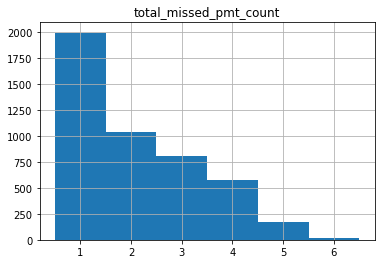

In [66]:
data_label.hist(column='total_missed_pmt_count', bins=np.arange(data_label.total_missed_pmt_count.min(), data_label.total_missed_pmt_count.max()+1)+0.5)

In [67]:
data_label.total_missed_pmt_count.value_counts()

0    15285
1     1990
2     1037
3      807
4      576
5      168
6       22
Name: total_missed_pmt_count, dtype: int64

In [68]:
data_label.total_missed_pmt_count.value_counts()

0    15285
1     1990
2     1037
3      807
4      576
5      168
6       22
Name: total_missed_pmt_count, dtype: int64

In [69]:
data_label[data_label.total_missed_pmt_count==6]
# Checked some of them manually to make sure they are correctly labeled

,lead_sequence_id,isFPD,total_missed_pmt_count
11005,2282673959,1.0,6
14046,2283801452,1.0,6
22111,2286376329,1.0,6
29706,2288709608,1.0,6
29981,2288794533,1.0,6
47057,2292782241,1.0,6
67958,2296435056,1.0,6
104569,2302375707,1.0,6
109605,2303317288,1.0,6
143378,2308598092,1.0,6


In [70]:
print('Portion of customers with 0 miss payments in first 6 payments:', round((data_label[data_label.total_missed_pmt_count <1].shape[0]/data_label.shape[0]) , 2))

Portion of customers with 0 miss payments in first 6 payments: 0.77


In [71]:
print('Portion of customers with miss payments:', round((data_label[data_label.total_missed_pmt_count >=1].shape[0]/data_label.shape[0]) , 2))

Portion of customers with miss payments: 0.23


In [72]:
print('Portion of customers with 1 or less miss payments in first 6 payments:', round((data_label[data_label.total_missed_pmt_count <=1].shape[0]/data_label.shape[0]) , 2))

Portion of customers with 1 or less miss payments in first 6 payments: 0.87


In [73]:
data_label['bad'] = np.where((data_label.total_missed_pmt_count >=1), 1 , 0)
print(data_label.bad.value_counts(dropna=False))
print(data_label.bad.value_counts(normalize=True))
data_label = data_label[['lead_sequence_id','isFPD','bad']].copy()

0    15285
1     4600
Name: bad, dtype: int64
0    0.76867
1    0.23133
Name: bad, dtype: float64


/opt/anaconda3/envs/feb_cf_risk/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [74]:
data_label

,lead_sequence_id,isFPD,bad
2,2275654718,0.0,0
58,2275655824,0.0,0
112,2275659462,0.0,1
123,2275661797,0.0,1
134,2275677243,0.0,0
...,...,...,...
540206,2347410503,0.0,1
540225,2347412004,0.0,0
540248,2347414124,0.0,0
540274,2347414131,0.0,0


<brc>

<brc>

<br/><br/>

<br/><br/>

## Feature Engineering

## MKA and MKAM FE (data work mk application and datawork mk application more tables)

In [75]:
print("Start data gathering process...")
from time import time
t0=time()

conn= mysql.connector.connect(option_files='.my.cnf', option_groups = 'mysqlconnection',use_pure=True)
raw_data = pd.read_sql("""select
                            am.*,
                            COALESCE(am.ORIGINAL_NEXT_PAY_DATE,a.nextpaydate) as ORIGINAL_NEXT_PAY_DATE2,
                            a._delta_bankaccount_24h, #leadgen
                            a._delta_bankaccount_90d, #leadgen
                            a._delta_dl_24h,
                            a._delta_dl_90d,
                            a._delta_email_24h,
                            a._delta_email_90d,
                            a._delta_homephone_24h,
                            a._delta_homephone_90d,
                            a._delta_income_24h,
                            a._delta_income_90d,
                            a._delta_otherphone_24h,
                            a._delta_otherphone_90d,
                            a.addressyears,
                            a.`bankaccount->bankaccount`, #leadgen
                            a.`bankaccount->dl`, #leadgen
                            a.`bankaccount->email`, #leadgen
                            a.`bankaccount->homephone`, #leadgen
                            a.`bankaccount->income`, #leadgen
                            a.`bankaccount->otherphone`, #leadgen
                            a.`bankaccount->ssn`, #leadgen
                            a.bankyears, #leadgen
                            a.campaign_name,
                            a.decision,
                            a.`dl->bankaccount`, #leadgen
                            a.`dl->dl`, 
                            a.`dl->email`,
                            a.`dl->homephone`,
                            a.`dl->income`,
                            a.`dl->otherphone`,
                            a.`dl->ssn`,
                            a.dlstate,
                            a.dob,
                            a.`email->bankaccount`, #leadgen
                            a.`email->dl`,
                            a.`email->email`,
                            a.`email->homephone`,
                            a.`email->income`,
                            a.`email->otherphone`,
                            a.`email->ssn`,
                            a.emp_start, #leadgen
                            a.empstate, #leadgen
                            a.emptype, #leadgen
                            a.empyears, #leadgen
                            a.hiredate,
                            a.`homephone->bankaccount`, #leadgen
                            a.`homephone->dl`,
                            a.`homephone->email`,
                            a.`homephone->homephone`,
                            a.`homephone->income`,
                            a.`homephone->otherphone`,
                            a.`homephone->ssn`,
                            a.incometype,
                            a.ipaddress, #leadgen
                            a.lead_cost,
                            a.lead_provider_name,
                            a.n_months_address,
                            a.n_months_bank, #leadgen
                            a.n_months_emp, #leadgen
                            a.netmonthly, 
                            a.nextpaydate,
                            a.nmi,
                            #a.payfrequency, 
                            a.rentorown,
                            a.requestedamount,
                            a.routingnumber, #leadgen
                            a.RULE_DESCRIPTION,
                            a.`ssn->bankaccount`, #leadgen
                            a.`ssn->dl`,
                            a.`ssn->email`,
                            a.`ssn->homephone`,
                            a.`ssn->income`,
                            a.`ssn->otherphone`,
                            a.`ssn->ssn`,
                            a.state,
                            a.uw_cost,
                            a.UW_STREAM_ID,
                            a.zip, 
                            a.insert_date,
                            a.days_ago,
                            a.wd_reason,
                            #TIMESTAMPDIFF(YEAR, a.dob, a.insert_date) AS app_age,
                            LOCATE('#',ls.description) as isHashtag,
                            year(a.insert_date) as received_year,
                            month(a.insert_date) as received_month,
                            EXTRACT(HOUR FROM a.insert_date) as received_hour,
                            (CASE
                            WHEN a.campaign_name='#CF-LENDINGTREE-SF#' THEN 'LendingTree'
                            WHEN a.campaign_name='#CF-QUINSTREET-SF#' THEN 'QuinStreet'
                            WHEN a.lead_provider_name='CreditSesame CF' then 'CreditSesame'
                            WHEN (right(a.campaign_name,4) = '-OH#') THEN 'MK Redirects'
                            WHEN a.lead_provider_name = 'CreditFresh Internal' and a.campaign_name<>'#CF-LENDINGTREE-SF#' and a.campaign_name<>'#CF-QUINSTREET-SF#' THEN 'Organic'
                            WHEN (right(a.lead_provider_name,2) = 'SF') THEN 'Short Form'
                            WHEN (a.campaign_name like '%LINC%' or a.campaign_name='LECCF-ALL-DT') THEN 'LeadGen-LINC'
                            WHEN a.payfrequency='M' THEN 'LeadGen-M'
                            ELSE 'LeadGen-NM'
                            END ) as 'channel',
                            (CASE
                            WHEN a.campaign_name='#CF-LENDINGTREE-SF#' THEN 1
                            WHEN a.campaign_name='#CF-QUINSTREET-SF#' THEN 1
                            WHEN a.lead_provider_name='CreditSesame CF' then 1
                            WHEN (right(a.lead_provider_name,2) = 'SF') THEN 1
                            WHEN (a.campaign_name like '%LINC%' or a.campaign_name='LECCF-ALL-DT') THEN 0
                            WHEN a.payfrequency='M' THEN 0
                            ELSE 0
                            END ) as 'is_marketplace'
                            from datawork.mk_application a
                            inner join datawork.mk_application_more am on a.lead_sequence_id = am.lead_sequence_id
                            inner join reporting_cf.leads_accepted la on a.lead_sequence_id = la.lead_sequence_id
                            inner join jaglms.lead_source ls on la.lead_source_id = ls.lead_source_id
                            inner join jaglms.lead_master_sources lms on ls.master_source_id = lms.master_source_id and lms.organization_id=2
                            where
                            a.lead_sequence_id IN"""+str(tuple(lds.tolist()))+"""
                            ;
                            """, con = conn)
conn.close()
print("done in %0.3fs." % (time() - t0))
print(raw_data.shape)

Start data gathering process...
done in 27.945s.
(22758, 276)


In [76]:
#Save to pickle
raw_data.to_pickle('raw_data.pkl')

In [77]:
#Read saved pickle 
raw_data = pd.read_pickle('raw_data.pkl')

In [78]:
raw_data.lead_sequence_id

0        2275651382
1        2275654718
2        2275655824
3        2275659462
4        2275661797
            ...    
22753    2347411102
22754    2347412004
22755    2347414124
22756    2347414131
22757    2347414190
Name: lead_sequence_id, Length: 22758, dtype: int64

In [79]:
raw_data.columns

Index(['id', 'lead_sequence_id', '/clarity/aan', '/lender-portfolio',
       'accountnumber', 'alt_phone', 'amountrequested', 'blacklist_rule_id',
       'blacklisted_lead_id', 'bypass-uw',
       ...
       'zip', 'insert_date', 'days_ago', 'wd_reason', 'isHashtag',
       'received_year', 'received_month', 'received_hour', 'channel',
       'is_marketplace'],
      dtype='object', length=276)

In [80]:
raw_data.channel.value_counts(dropna=False)

LeadGen-NM      15477
LendingTree      3098
LeadGen-M        2743
QuinStreet        529
LeadGen-LINC      420
CreditSesame      309
Short Form        182
Name: channel, dtype: int64

In [81]:
raw_data.is_marketplace.iloc[:,0]

0        None
1        None
2        None
3        None
4        None
         ... 
22753    None
22754    None
22755    None
22756    None
22757    None
Name: is_marketplace, Length: 22758, dtype: object

In [82]:
# duplicate column names
raw_data.loc[:,raw_data.columns.duplicated()]

,is_marketplace
0,0
1,0
2,0
3,0
4,0
...,...
22753,0
22754,0
22755,1
22756,1


In [83]:
# rename the first column to is_marketplace2 to remove it later
d = {'is_marketplace': ['is_marketplace2', 'is_marketplace']}
raw_data = raw_data.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)

In [84]:
raw_data = raw_data.drop(['is_marketplace2'], axis=1)

In [85]:
raw_data.shape

(22758, 275)

In [86]:
#filter out uw_streams and states
#raw_data = raw_data.loc[raw_data['UW_STREAM_ID'].isin(uw_stream_list),:]
#raw_data = raw_data.loc[raw_data['state'].isin(state_list),:]
print(raw_data.shape)

#########################
###Feature Engineering###
#########################
###Change some variable names###
raw_data.columns = pd.Series(raw_data.columns).replace("->", "_to_", regex=True)

###dlstate###
raw_data["MKA_IsDiffState_DLState"] = np.where(raw_data.state!=raw_data.dlstate,1,0)
raw_data = raw_data.drop(['dlstate'], axis=1)

###empstate###
raw_data["MKA_IsDiffState_EmpState"] = np.where(raw_data.state!=raw_data.empstate,1,0)
raw_data = raw_data.drop(['empstate'], axis=1)

###incometype###
raw_data["MKA_IsIncometypeE"] = np.where(raw_data.incometype.str.upper()=="E",1,0)

###insert_date & nextpaydate###
raw_data["nextpaydate"] = pd.to_datetime(raw_data.nextpaydate, format="%Y-%m-%d")
raw_data["MKA_DaysUntilNextPaydate"] = (raw_data.nextpaydate - raw_data.insert_date).dt.days

###hiredate & insert_date###
raw_data.loc[raw_data.hiredate.astype(str).str.len()!=10,'hiredate'] = None
raw_data.loc[raw_data.dob.astype(str).str.len()!=10,'dob'] = None
raw_data.hiredate = pd.to_datetime(raw_data.hiredate, format="%Y-%m-%d")
raw_data.dob = pd.to_datetime(raw_data.dob, format="%Y-%m-%d")
raw_data.loc[(raw_data.hiredate<raw_data.dob) | (raw_data.hiredate>raw_data.insert_date), "hiredate"] = None
raw_data["MKA_DaysSinceHiredate"] = (raw_data.insert_date - raw_data.hiredate).dt.days
###hiredate & dob###
raw_data["MKA_AgeHiredate"] = hf.YearCalculator(raw_data.hiredate, raw_data.dob)
raw_data["MKA_AgeHireDateInRange"] = np.where((raw_data.MKA_AgeHiredate>=15) & (raw_data.MKA_AgeHiredate<=64),1,0)

###emp_start & insert_date###
#leadgen
raw_data.loc[raw_data.emp_start.astype(str).str.len()!=10,'emp_start'] = None
raw_data.loc[raw_data.dob.astype(str).str.len()!=10,'dob'] = None
raw_data.emp_start = pd.to_datetime(raw_data.emp_start, format="%Y-%m-%d")
raw_data.dob = pd.to_datetime(raw_data.dob, format="%Y-%m-%d")
raw_data.loc[(raw_data.emp_start<raw_data.dob) | (raw_data.emp_start>raw_data.insert_date), "emp_start"] = None
raw_data["MKA_DaysSinceEmptart"] = (raw_data.insert_date - raw_data.emp_start).dt.days
###emp_start & dob###
#leadgen
raw_data["MKA_AgeEmpstart"] = hf.YearCalculator(raw_data.emp_start, raw_data.dob)
raw_data["MKA_AgeEmpstartInRange"] = np.where((raw_data.MKA_AgeEmpstart>=15) & (raw_data.MKA_AgeEmpstart<=64),1,0)

###Ratio###
#leadgen
raw_data["MKA_RatioBA24h90d"] = raw_data._delta_bankaccount_24h/raw_data._delta_bankaccount_90d
raw_data["MKA_RatioDL24h90d"] = raw_data._delta_dl_24h/raw_data._delta_dl_90d
raw_data["MKA_RatioEmail24h90d"] = raw_data._delta_email_24h/raw_data._delta_email_90d
raw_data["MKA_RatioHP24h90d"] = raw_data._delta_homephone_24h/raw_data._delta_homephone_90d
raw_data["MKA_RatioIncome24h90d"] = raw_data._delta_income_24h/raw_data._delta_income_90d
raw_data["MKA_RatioOP24h90d"] = raw_data._delta_otherphone_24h/raw_data._delta_otherphone_90d

###received_hour###
raw_data["MKA_ReceivedDuringNight"] = np.where((raw_data.received_hour<7) | (raw_data.received_hour>=23),1,0)


#Change insert_date from chr format to Date format
raw_data.insert_date = pd.to_datetime(raw_data.insert_date, format="%Y-%m-%d")

lead_sequence_id = raw_data.lead_sequence_id


###Delete useless###
raw_data = raw_data[raw_data.columns.drop(list(raw_data.filter(regex='DUPE|EPIC|id|ip_geo|jagstatus|/li/cp/|llt_amount|nbc_rule|override|promo|score|time')))]
        
###Drop ORIGINAL_NEXT_PAY_DATE and use ORIGINAL_NEXT_PAY_DATE2###
raw_data = raw_data.drop(['ORIGINAL_NEXT_PAY_DATE'], axis=1)
raw_data.rename(columns = {'ORIGINAL_NEXT_PAY_DATE2': 'ORIGINAL_NEXT_PAY_DATE'}, inplace = True)
    
###dow###
raw_data["MKAM_DOW_OriginalNextPaydate"] = pd.to_datetime(raw_data.ORIGINAL_NEXT_PAY_DATE, format="%Y-%m-%d").dt.dayofweek+1

###ORIGINAL_NEXT_PAY_DATE###
raw_data["MKAM_NumDaysUntilNextPaydate"] = (pd.to_datetime(raw_data.ORIGINAL_NEXT_PAY_DATE, format="%Y-%m-%d") - raw_data.insert_date).dt.days
raw_data.loc[raw_data.MKAM_NumDaysUntilNextPaydate<0, "MKAM_NumDaysUntilNextPaydate"] = None
raw_data["MKAM_NextPaydateInRange"] = np.where((raw_data.MKAM_NumDaysUntilNextPaydate>=0) & (raw_data.MKAM_NumDaysUntilNextPaydate<32),1,0) 

raw_data.insert(loc=0, column='lead_sequence_id', value=lead_sequence_id)


print(raw_data.shape)

(22758, 275)
(22758, 215)


In [87]:
raw_data.columns

Index(['lead_sequence_id', '/clarity/aan', '/lender-portfolio',
       'accountnumber', 'alt_phone', 'amountrequested', 'bypass-uw',
       'ca_nbc_standard', 'cellphone_area_code', 'cellphone_exchange',
       ...
       'MKA_RatioBA24h90d', 'MKA_RatioDL24h90d', 'MKA_RatioEmail24h90d',
       'MKA_RatioHP24h90d', 'MKA_RatioIncome24h90d', 'MKA_RatioOP24h90d',
       'MKA_ReceivedDuringNight', 'MKAM_DOW_OriginalNextPaydate',
       'MKAM_NumDaysUntilNextPaydate', 'MKAM_NextPaydateInRange'],
      dtype='object', length=215)

In [88]:
raw_data.channel.value_counts(dropna=False, normalize= True)

LeadGen-NM      0.680069
LendingTree     0.136128
LeadGen-M       0.120529
QuinStreet      0.023245
LeadGen-LINC    0.018455
CreditSesame    0.013578
Short Form      0.007997
Name: channel, dtype: float64

In [89]:
raw_data.campaign_name.value_counts(dropna=False)

#CF-LENDINGTREE-SF#    3098
ZPCF-ALL-TT            1517
ZPCF-ALL-101           1279
LMCF-ALL-101            932
ZPCF-ALL-DT             929
                       ... 
#CF-EML-TUTID#            1
SFLCF-IN-DT               1
ITMCF-ALL-SF              1
LTCF-ALL-PR               1
LEAPCF-FL-PR              1
Name: campaign_name, Length: 119, dtype: int64

In [44]:
# highNoneCOl_marketplace_only = np.setdiff1d(highNoneCOl_marketplace, highNoneCOl_leadgen)
# highNoneCOl_marketplace_only

In [90]:
#############################
###Feature Engineering End###
#############################
# just by non-marketplace
#Feature selections: Remove useless variables by leadgen leads
print("Number of columns:" + str(len(raw_data.columns)))
highNoneCOl = hf.printNoneReturnRatios(raw_data[raw_data.is_marketplace==0])
raw_data = raw_data.drop(highNoneCOl, axis=1)
print("Number of columns:" + str(len(raw_data.columns)))
highLevCols = hf.listHighLevels(raw_data[raw_data.is_marketplace==0])
raw_data = raw_data.drop(highLevCols, axis=1)
print("Number of columns:" + str(len(raw_data.columns)))
oneLevCols = hf.listOneLevel(raw_data[raw_data.is_marketplace==0])
raw_data = raw_data.drop(oneLevCols, axis=1)
print("Number of columns:" + str(len(raw_data.columns)))
highMaxElementCOL = hf.printMaxElementReturnRatios(raw_data[raw_data.is_marketplace==0])
raw_data = raw_data.drop(highMaxElementCOL, axis=1)


Number of columns:215
Running printNoneReturnRatios:
/clarity/aan: 1.0
/lender-portfolio: 1.0
accountnumber: 0.990450643776824
alt_phone: 0.992381974248927
amountrequested: 1.0
bypass-uw: 1.0
ca_nbc_standard: 1.0
cellphone_area_code: 1.0
cellphone_exchange: 1.0
cellphone_station: 1.0
day1: 1.0
day2: 1.0
debit_number: 1.0
DENYFLAG: 1.0
DM_ACCEPT: 1.0
email_ssn_mismatch: 1.0
email2: 1.0
emp_industry: 1.0
EXISTING: 1.0
first_seen_dl: 1.0
hd_ok: 1.0
ip_state_count_15: 1.0
language: 1.0
llt_result: 0.8839592274678112
movedir: 0.9905042918454936
n_prev_accepts: 0.9703862660944206
n_prev_defaults: 0.9703862660944206
ncp: 0.8489806866952789
optout_account_email: 0.9985515021459227
optout_account_sms: 0.9985515021459227
optout_marketing_email: 0.9985515021459227
optout_marketing_sms: 0.9985515021459227
paycheck_amount: 0.9983369098712447
prior_purchase_last_date_credit return: 1.0
prior_purchase_last_date_withdraw: 0.9703862660944206
prior_purchases_credit return: 1.0
prior_purchases_withdraw: 

In [91]:
raw_data.columns

Index(['lead_sequence_id', 'digits_in_email_username', 'dow',
       'email_period_count', 'email_seen_count',
       'email_username_has_firstname', 'email_username_has_lastname',
       'email_username_has_period', 'first_seen_bankaccount',
       'first_seen_email', 'first_seen_email_days', 'first_seen_homephone',
       'first_seen_ssn', 'first_seen_ssn_days', 'ip_state_count_2',
       'ip_state_count_5', 'is_first_seen_email', 'is_first_seen_ssn',
       'last_seen_email_days', 'last_seen_ssn_days', 'old_loan_amount',
       'req_amt_to_income', 'ssn_endswith_email_digits_2', 'ssn_seen_count',
       'last_update', '/graphdb/connected_ssn', '/graphdb/connected_apps',
       'avg_netmonthly', 'max_netmonthly', 'min_netmonthly', 'std_netmonthly',
       'addressyears', 'bankaccount_to_bankaccount', 'bankaccount_to_dl',
       'bankaccount_to_email', 'bankaccount_to_homephone',
       'bankaccount_to_income', 'bankaccount_to_otherphone',
       'bankaccount_to_ssn', 'bankyears', 'do

In [92]:
# features which should set as null for marketplace, not available when making decision at hb1
hb2_marketplace = ['_delta_bankaccount_24h','_delta_bankaccount_90d', 'bankaccount_to_bankaccount', 'bankaccount_to_dl','bankaccount_to_email', 'bankaccount_to_homephone','bankaccount_to_income', 
                    'bankaccount_to_otherphone','bankaccount_to_ssn', 'bankyears','dl_to_bankaccount', 'email_to_bankaccount','emp_start','empstate','emptype','empyears','homephone_to_bankaccount', 
                    'ipaddress','n_months_bank','n_months_emp','routingnumber','ssn_to_bankaccount','MKA_IsDiffState_EmpState','MKA_DaysSinceEmptart','MKA_AgeEmpstart','MKA_AgeEmpstartInRange','MKA_RatioBA24h90d',
                  'first_seen_bankaccount','ip_state_count_2','ip_state_count_5']
for i in hb2_marketplace:
    if i in raw_data.columns:
        print(i)
        raw_data.loc[raw_data.is_marketplace==1,i] = None


bankaccount_to_bankaccount
bankaccount_to_dl
bankaccount_to_email
bankaccount_to_homephone
bankaccount_to_income
bankaccount_to_otherphone
bankaccount_to_ssn
bankyears
email_to_bankaccount
emp_start
emptype
empyears
homephone_to_bankaccount
n_months_bank
n_months_emp
ssn_to_bankaccount
MKA_IsDiffState_EmpState
MKA_DaysSinceEmptart
MKA_AgeEmpstart
MKA_AgeEmpstartInRange
first_seen_bankaccount
ip_state_count_2
ip_state_count_5


In [93]:
raw_data.shape

(22758, 100)

In [94]:
raw_data.columns

Index(['lead_sequence_id', 'digits_in_email_username', 'dow',
       'email_period_count', 'email_seen_count',
       'email_username_has_firstname', 'email_username_has_lastname',
       'email_username_has_period', 'first_seen_bankaccount',
       'first_seen_email', 'first_seen_email_days', 'first_seen_homephone',
       'first_seen_ssn', 'first_seen_ssn_days', 'ip_state_count_2',
       'ip_state_count_5', 'is_first_seen_email', 'is_first_seen_ssn',
       'last_seen_email_days', 'last_seen_ssn_days', 'old_loan_amount',
       'req_amt_to_income', 'ssn_endswith_email_digits_2', 'ssn_seen_count',
       'last_update', '/graphdb/connected_ssn', '/graphdb/connected_apps',
       'avg_netmonthly', 'max_netmonthly', 'min_netmonthly', 'std_netmonthly',
       'addressyears', 'bankaccount_to_bankaccount', 'bankaccount_to_dl',
       'bankaccount_to_email', 'bankaccount_to_homephone',
       'bankaccount_to_income', 'bankaccount_to_otherphone',
       'bankaccount_to_ssn', 'bankyears', 'do

In [96]:
# these features are not meaningful for a lead before acceptance
# dob, hiredate, RULE_DESCRIPTION, emp_start, uw_cost, insert_date, channel, UW_STREAM_ID, received_year
print(raw_data.shape)
raw_data = raw_data.drop(['dob', 'hiredate', 'RULE_DESCRIPTION','emp_start', 'uw_cost', 'insert_date', 'UW_STREAM_ID', 'received_year'], axis=1)
print(raw_data.shape)

(22758, 100)
(22758, 92)


In [97]:
raw_data = raw_data.drop_duplicates(subset=['lead_sequence_id'], keep='first')
raw_data.lead_sequence_id.nunique()

22612

In [98]:
raw_data.shape

(22612, 92)

## CCR FE (clear credit risk)

In [99]:
conn= mysql.connector.connect(option_files='.my.cnf',option_groups='mysqlconnection', use_pure=True)

ccr_df_database=pd.read_sql("""select
                        ccr.*
                        from datawork.mk_application a
                        inner join datawork.mk_clearcreditrisk ccr on a.lead_sequence_id = ccr.lead_sequence_id
                        where
                        a.lead_sequence_id in """ + str(tuple(lds)) + """
                        ;
                        """, con = conn)
    
conn.close()    
print(ccr_df_database.shape)

(15874, 527)


In [100]:
#Save to pickle
ccr_df_database.to_pickle('ccr_df_database.pkl')

In [101]:
#Read saved pickle 
ccr_df_database = pd.read_pickle('ccr_df_database.pkl')

In [102]:
len([col for col in clarity_results.columns if '/ccr/' in col])

398

In [103]:
clarity_results.shape

(19623, 1169)

In [104]:
# just keep originated lds in retro data
clarity_results_orig = clarity_results[clarity_results.lead_sequence_id.isin(lds)]

In [106]:
print(ccr_df_database.shape)
ccr_df= pd.concat([ccr_df_database,clarity_results_orig[[col for col in clarity_results_orig.columns if '/ccr/' in col] + ['lead_sequence_id']]])
print(ccr_df.shape)

(15874, 527)
(22564, 528)


In [107]:
print(ccr_df.shape)
ccr_df = ccr_df.drop_duplicates(subset=['lead_sequence_id'], keep='first')
print(ccr_df.shape)

(22564, 528)
(22564, 528)


In [108]:
ccr_df.columns

Index(['id', 'lead_sequence_id', '/xr/ccr/sties/sty/C1.dd/seven-years-ago',
       '/xr/ccr/tradelines/tradeline/ALL.aco/last-updated-at',
       '/xr/ccr/sties/sty/ALL.aco/sixty-days-ago',
       '/xr/ccr/sties/sty/C3.nto/name', '/xr/ccr/sties/C3.aco/sty',
       '/xr/ccr/non-scorable-reason-code_nil',
       '/xr/ccr/experian-attribute/tbcc2351',
       '/xr/ccr/experian-attribute/tbcc3203',
       ...
       '/xr/ccr/experian-attribute/tbca0455',
       '/xr/ccr/sties/sty/ALL.ato/fifteen-days-ago',
       '/xr/ccr/sties/sty/ALL.dcl/two-years-ago', 'last_update',
       '/xr/ccr/days-since-last-loan-paid-off',
       '/xr/ccr/days-since-first-loan-paid-off',
       '/xr/ccr/days-since-last-ontime-payment',
       '/xr/ccr/days-since-last-loan-in-collections',
       '/xr/ccr/days-since-first-ontime-payment',
       '/xr/ccr/non-scorable-reason-code'],
      dtype='object', length=528)

## CAA FE (clear advanced attributes)

In [109]:
conn= mysql.connector.connect(option_files='.my.cnf',option_groups='mysqlconnection', use_pure=True)
caa_df_database=pd.read_sql("""select
                    caa.*
                    from datawork.mk_application a
                    inner join datawork.mk_clearadvancedattributes caa on a.lead_sequence_id = caa.lead_sequence_id
                    where
                    a.lead_sequence_id in """ + str(tuple(lds)) + """
                    ;
                    """, con = conn)
conn.close()    
print(caa_df_database.shape)

(15874, 529)


In [110]:
#Save to pickle
caa_df_database.to_pickle('caa_df_database.pkl')

In [111]:
#Read saved pickle 
caa_df_database = pd.read_pickle('caa_df_database.pkl')

In [112]:
caa_df= pd.concat([caa_df_database,clarity_results_orig[[col for col in clarity_results_orig.columns if '/caa/' in col] + ['lead_sequence_id']]])
print(caa_df.shape)

(22564, 531)


In [113]:
print(caa_df.shape)
caa_df = caa_df.drop_duplicates(subset=['lead_sequence_id'], keep='first')
print(caa_df.shape)

(22564, 531)
(22564, 531)


In [114]:
[col for col in caa_df.columns if 'lead' in col]

['lead_sequence_id']

In [115]:
#########################
###Feature Engineering###
#########################
#Merge 2 datasets
ccr_caa_df = ccr_df.merge(caa_df, how='inner', on=['lead_sequence_id'], suffixes=('', '_y'))

lead_sequence_id = ccr_caa_df.lead_sequence_id

###Delete useless###
ccr_caa_df = ccr_caa_df[ccr_caa_df.columns.drop(list(ccr_caa_df.filter(regex='_y|action|clarity-seen|code|filter|hit|id|message|name|nil|null|rating|type')))]


#/sties/sty/48.inq/ (Total number of Collection inquiries)
ccr_caa_df["CCRCAA_48inqMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/48.inq/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/48.inq/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/48.inq/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/48.inq/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/48.inq/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/48.inq/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/48.inq/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/48.inq/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/48.inq/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/48.inq/three-years-ago"]!=0,10, 11))))))))))

#/sties/sty/ALL.dcl/ (Number of days any loan was in collection)
ccr_caa_df["CCRCAA_ALLdclMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/ALL.dcl/twentyfour-hours-ago"]!=0,1,
                                                np.where(ccr_caa_df["/xr/caa/sties/sty/ALL.dcl/seven-days-ago"]!=0,2,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dcl/fifteen-days-ago"]!=0,3,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dcl/thirty-days-ago"]!=0,4,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dcl/sixty-days-ago"]!=0,5,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dcl/ninety-days-ago"]!=0,6,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dcl/one-hundred-eighty-days-ago"]!=0,7,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dcl/one-year-ago"]!=0,8,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dcl/two-years-ago"]!=0,9,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dcl/three-years-ago"]!=0,10,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dcl/seven-years-ago"]!=0, 11, 12)))))))))))

#/sties/sty/ALL.dd/ (Number of days with one or more open/active loans)
ccr_caa_df["CCRCAA_ALLddMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/ALL.dd/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/ALL.dd/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dd/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dd/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dd/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dd/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dd/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dd/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dd/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dd/three-years-ago"]!=0,10,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dd/seven-years-ago"]!=0, 11, 12)))))))))))

#/sties/sty/ALL.dlp/ (Number of days any loan was with late payment)
ccr_caa_df["CCRCAA_ALLdlpMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/ALL.dlp/twentyfour-hours-ago"]!=0,1,
                                                np.where(ccr_caa_df["/xr/caa/sties/sty/ALL.dlp/seven-days-ago"]!=0,2,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dlp/fifteen-days-ago"]!=0,3,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dlp/thirty-days-ago"]!=0,4,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dlp/sixty-days-ago"]!=0,5,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dlp/ninety-days-ago"]!=0,6,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dlp/one-hundred-eighty-days-ago"]!=0,7,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dlp/one-year-ago"]!=0,8,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dlp/two-years-ago"]!=0,9,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dlp/three-years-ago"]!=0,10,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.dlp/seven-years-ago"]!=0, 11, 12)))))))))))

#Sum up all "'ALL' Number of days" statistics and become a score
ccr_caa_df["CCRCAA_ALLNumberofDaysScore"] = ccr_caa_df["CCRCAA_ALLdclMostRecentChangeLevel"]+ccr_caa_df["CCRCAA_ALLddMostRecentChangeLevel"]+ccr_caa_df["CCRCAA_ALLdlpMostRecentChangeLevel"]


#/sties/sty/ALL.ncl/ (Number of loans in collections)
ccr_caa_df["CCRCAA_ALLnclMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/ALL.ncl/twentyfour-hours-ago"]!=0,1,
                                                np.where(ccr_caa_df["/xr/caa/sties/sty/ALL.ncl/seven-days-ago"]!=0,2,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.ncl/fifteen-days-ago"]!=0,3,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.ncl/thirty-days-ago"]!=0,4,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.ncl/sixty-days-ago"]!=0,5,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.ncl/ninety-days-ago"]!=0,6,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.ncl/one-hundred-eighty-days-ago"]!=0,7,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.ncl/one-year-ago"]!=0,8,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.ncl/two-years-ago"]!=0,9,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.ncl/three-years-ago"]!=0,10,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.ncl/seven-years-ago"]!=0, 11, 12)))))))))))

#/sties/sty/ALL.nco/ (Number of loans charged off)
ccr_caa_df["CCRCAA_ALLncoMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/ALL.nco/twentyfour-hours-ago"]!=0,1,
                                                np.where(ccr_caa_df["/xr/caa/sties/sty/ALL.nco/seven-days-ago"]!=0,2,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nco/fifteen-days-ago"]!=0,3,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nco/thirty-days-ago"]!=0,4,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nco/sixty-days-ago"]!=0,5,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nco/ninety-days-ago"]!=0,6,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nco/one-hundred-eighty-days-ago"]!=0,7,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nco/one-year-ago"]!=0,8,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nco/two-years-ago"]!=0,9,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nco/three-years-ago"]!=0,10,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nco/seven-years-ago"]!=0, 11, 12)))))))))))

#/sties/sty/ALL.nlp/ (Number of loans with late payment)
ccr_caa_df["CCRCAA_ALLnlpMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/ALL.nlp/twentyfour-hours-ago"]!=0,1,
                                                np.where(ccr_caa_df["/xr/caa/sties/sty/ALL.nlp/seven-days-ago"]!=0,2,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nlp/fifteen-days-ago"]!=0,3,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nlp/thirty-days-ago"]!=0,4,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nlp/sixty-days-ago"]!=0,5,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nlp/ninety-days-ago"]!=0,6,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nlp/one-hundred-eighty-days-ago"]!=0,7,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nlp/one-year-ago"]!=0,8,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nlp/two-years-ago"]!=0,9,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nlp/three-years-ago"]!=0,10,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nlp/seven-years-ago"]!=0, 11, 12)))))))))))

#/sties/sty/ALL.nto/ (Number of loans)
ccr_caa_df["CCRCAA_ALLntoMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/ALL.nto/twentyfour-hours-ago"]!=0,1,
                                                np.where(ccr_caa_df["/xr/caa/sties/sty/ALL.nto/seven-days-ago"]!=0,2,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nto/fifteen-days-ago"]!=0,3,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nto/thirty-days-ago"]!=0,4,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nto/sixty-days-ago"]!=0,5,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nto/ninety-days-ago"]!=0,6,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nto/one-hundred-eighty-days-ago"]!=0,7,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nto/one-year-ago"]!=0,8,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nto/two-years-ago"]!=0,9,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nto/three-years-ago"]!=0,10,
                                                np.where(ccr_caa_df["/xr/ccr/sties/sty/ALL.nto/seven-years-ago"]!=0, 11, 12)))))))))))

#Sum up all "'ALL' Number of loans" statistics and become a score
ccr_caa_df["CCRCAA_ALLNumberofLoansScore"] = ccr_caa_df["CCRCAA_ALLnclMostRecentChangeLevel"]+ccr_caa_df["CCRCAA_ALLncoMostRecentChangeLevel"]+ccr_caa_df["CCRCAA_ALLnlpMostRecentChangeLevel"]+ccr_caa_df["CCRCAA_ALLntoMostRecentChangeLevel"]




#/sties/sty/C1.dcl/ (Number of days Online Single Payment in collection)
ccr_caa_df["CCRCAA_C1dclMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C1.dcl/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C1.dcl/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dcl/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dcl/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dcl/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dcl/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dcl/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dcl/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dcl/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dcl/three-years-ago"]!=0,10,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dcl/seven-years-ago"]!=0, 11, 12)))))))))))

#/sties/sty/C1.dd/ (Number of days with one or more Online Single Payment loans open)
ccr_caa_df["CCRCAA_C1ddMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C1.dd/twentyfour-hours-ago"]!=0,1,
                                              np.where(ccr_caa_df["/xr/caa/sties/sty/C1.dd/seven-days-ago"]!=0,2,
                                              np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dd/fifteen-days-ago"]!=0,3,
                                              np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dd/thirty-days-ago"]!=0,4,
                                              np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dd/sixty-days-ago"]!=0,5,
                                              np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dd/ninety-days-ago"]!=0,6,
                                              np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dd/one-hundred-eighty-days-ago"]!=0,7,
                                              np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dd/one-year-ago"]!=0,8,
                                              np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dd/two-years-ago"]!=0,9,
                                              np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dd/three-years-ago"]!=0,10,
                                              np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dd/seven-years-ago"]!=0, 11, 12)))))))))))

#/sties/sty/C1.dlp/ (Number of days Online Single Payment with late payment)
ccr_caa_df["CCRCAA_C1dlpMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C1.dlp/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C1.dlp/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dlp/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dlp/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dlp/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dlp/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dlp/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dlp/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dlp/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dlp/three-years-ago"]!=0,10,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.dlp/seven-years-ago"]!=0, 11, 12)))))))))))

#Sum up all "'C1' Number of days" statistics and become a score
ccr_caa_df["CCRCAA_C1NumberofDaysScore"] = ccr_caa_df["CCRCAA_C1dclMostRecentChangeLevel"]+ccr_caa_df["CCRCAA_C1ddMostRecentChangeLevel"]+ccr_caa_df["CCRCAA_C1dlpMostRecentChangeLevel"]


#/sties/sty/C1.inq/ (Number of Online Single Payment inquires)
ccr_caa_df["CCRCAA_C1inqMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.inq/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.inq/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.inq/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.inq/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.inq/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.inq/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.inq/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.inq/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C1.inq/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C1.inq/three-years-ago"]!=0,10, 11))))))))))

#/sties/sty/C1.ncl/ (Number of Online Single Payment loans in collections)
ccr_caa_df["CCRCAA_C1nclMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C1.ncl/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C1.ncl/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.ncl/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.ncl/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.ncl/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.ncl/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.ncl/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.ncl/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.ncl/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.ncl/three-years-ago"]!=0,10,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.ncl/seven-years-ago"]!=0, 11, 12)))))))))))

#/sties/sty/C1.nco/ (Number of Online Single Payment loans charged off)
ccr_caa_df["CCRCAA_C1ncoMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C1.nco/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C1.nco/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nco/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nco/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nco/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nco/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nco/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nco/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nco/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nco/three-years-ago"]!=0,10,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nco/seven-years-ago"]!=0, 11, 12)))))))))))

#/sties/sty/C1.nlp/ (Number of Online Single Payment loans with late payment)
ccr_caa_df["CCRCAA_C1nlpMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C1.nlp/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C1.nlp/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nlp/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nlp/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nlp/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nlp/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nlp/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nlp/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nlp/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nlp/three-years-ago"]!=0,10,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nlp/seven-years-ago"]!=0, 11, 12)))))))))))

#/sties/sty/C1.nto/ (Number of Online Single Payment loans)
ccr_caa_df["CCRCAA_C1ntoMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C1.nto/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C1.nto/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nto/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nto/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nto/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nto/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nto/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nto/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nto/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nto/three-years-ago"]!=0,10,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C1.nto/seven-years-ago"]!=0, 11, 12)))))))))))

#Sum up all "'C1' Number of loans" statistics and become a score
ccr_caa_df["CCRCAA_C1NumberofLoansScore"] = ccr_caa_df["CCRCAA_C1nclMostRecentChangeLevel"]+ccr_caa_df["CCRCAA_C1ncoMostRecentChangeLevel"]+ccr_caa_df["CCRCAA_C1nlpMostRecentChangeLevel"]+ccr_caa_df["CCRCAA_C1ntoMostRecentChangeLevel"]



#/sties/sty/C2.dcl/ (Number of days Storefront Single Payment loans in collection)
ccr_caa_df["CCRCAA_C2dclMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dcl/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dcl/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dcl/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dcl/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dcl/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dcl/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dcl/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dcl/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dcl/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dcl/three-years-ago"]!=0,10,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dcl/seven-years-ago"]!=0, 11, 12)))))))))))

#/sties/sty/C2.dd/ (Number of days with one or more Storefront Single Payment loans open)
ccr_caa_df["CCRCAA_C2ddMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dd/twentyfour-hours-ago"]!=0,1,
                                              np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dd/seven-days-ago"]!=0,2,
                                              np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dd/fifteen-days-ago"]!=0,3,
                                              np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dd/thirty-days-ago"]!=0,4,
                                              np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dd/sixty-days-ago"]!=0,5,
                                              np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dd/ninety-days-ago"]!=0,6,
                                              np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dd/one-hundred-eighty-days-ago"]!=0,7,
                                              np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dd/one-year-ago"]!=0,8,
                                              np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dd/two-years-ago"]!=0,9,
                                              np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dd/three-years-ago"]!=0,10,
                                              np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dd/seven-years-ago"]!=0, 11, 12)))))))))))

#/sties/sty/C2.dlp/ (Number of days Storefront Single Payment loans with late payment)
ccr_caa_df["CCRCAA_C2dlpMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dlp/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dlp/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dlp/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dlp/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dlp/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dlp/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dlp/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dlp/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dlp/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dlp/three-years-ago"]!=0,10,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.dlp/seven-years-ago"]!=0, 11, 12)))))))))))

#Sum up all "'C2' Number of days" statistics and become a score
ccr_caa_df["CCRCAA_C2NumberofDaysScore"] = ccr_caa_df["CCRCAA_C2dclMostRecentChangeLevel"]+ccr_caa_df["CCRCAA_C2ddMostRecentChangeLevel"]+ccr_caa_df["CCRCAA_C2dlpMostRecentChangeLevel"]


#/sties/sty/C2.inq/ (Number of Storefront Single Payment loans inquires)
ccr_caa_df["CCRCAA_C2inqMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C2.inq/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.inq/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.inq/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.inq/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.inq/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.inq/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.inq/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.inq/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.inq/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.inq/three-years-ago"]!=0,10, 11))))))))))

#/sties/sty/C2.ncl/ (Number of Storefront Single Payment loans in collections)
ccr_caa_df["CCRCAA_C2nclMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C2.ncl/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.ncl/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.ncl/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.ncl/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.ncl/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.ncl/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.ncl/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.ncl/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.ncl/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.ncl/three-years-ago"]!=0,10,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.ncl/seven-years-ago"]!=0, 11, 12)))))))))))

#/sties/sty/C2.nco/ (Number of Storefront Single Payment loans charged off)
ccr_caa_df["CCRCAA_C2ncoMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nco/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nco/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nco/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nco/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nco/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nco/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nco/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nco/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nco/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nco/three-years-ago"]!=0,10,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nco/seven-years-ago"]!=0, 11, 12)))))))))))

#/sties/sty/C2.nlp/ (Number of Storefront Single Payment loans with late payment)
ccr_caa_df["CCRCAA_C2nlpMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nlp/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nlp/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nlp/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nlp/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nlp/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nlp/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nlp/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nlp/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nlp/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nlp/three-years-ago"]!=0,10,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nlp/seven-years-ago"]!=0, 11, 12)))))))))))

#/sties/sty/C2.nto/ (Number of Storefront Single Payment loans)
ccr_caa_df["CCRCAA_C2ntoMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nto/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nto/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nto/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nto/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nto/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nto/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nto/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nto/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nto/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nto/three-years-ago"]!=0,10,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C2.nto/seven-years-ago"]!=0, 11, 12)))))))))))

#Sum up all "'C2' Number of loans" statistics and become a score
ccr_caa_df["CCRCAA_C2NumberofLoansScore"] = ccr_caa_df["CCRCAA_C2nclMostRecentChangeLevel"]+ccr_caa_df["CCRCAA_C2ncoMostRecentChangeLevel"]+ccr_caa_df["CCRCAA_C2nlpMostRecentChangeLevel"]+ccr_caa_df["CCRCAA_C1ntoMostRecentChangeLevel"]



#/sties/sty/C3.dcl/ (Number of days Online Single Payment in collection)
ccr_caa_df["CCRCAA_C3dclMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C3.dcl/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C3.dcl/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dcl/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dcl/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dcl/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dcl/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dcl/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dcl/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dcl/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dcl/three-years-ago"]!=0,10,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dcl/seven-years-ago"]!=0, 11, 12)))))))))))

#/sties/sty/C3.dd/ (Number of days with one or more Online Single Payment loans open)
ccr_caa_df["CCRCAA_C3ddMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C3.dd/twentyfour-hours-ago"]!=0,1,
                                              np.where(ccr_caa_df["/xr/caa/sties/sty/C3.dd/seven-days-ago"]!=0,2,
                                              np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dd/fifteen-days-ago"]!=0,3,
                                              np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dd/thirty-days-ago"]!=0,4,
                                              np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dd/sixty-days-ago"]!=0,5,
                                              np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dd/ninety-days-ago"]!=0,6,
                                              np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dd/one-hundred-eighty-days-ago"]!=0,7,
                                              np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dd/one-year-ago"]!=0,8,
                                              np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dd/two-years-ago"]!=0,9,
                                              np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dd/three-years-ago"]!=0,10,
                                              np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dd/seven-years-ago"]!=0, 11, 12)))))))))))

#/sties/sty/C3.dlp/ (Number of days Online Single Payment with late payment)
ccr_caa_df["CCRCAA_C3dlpMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C3.dlp/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C3.dlp/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dlp/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dlp/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dlp/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dlp/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dlp/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dlp/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dlp/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dlp/three-years-ago"]!=0,10,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.dlp/seven-years-ago"]!=0, 11, 12)))))))))))

#Sum up all "'C3' Number of days" statistics and become a score
ccr_caa_df["CCRCAA_C3NumberofDaysScore"] = ccr_caa_df["CCRCAA_C3dclMostRecentChangeLevel"]+ccr_caa_df["CCRCAA_C3ddMostRecentChangeLevel"]+ccr_caa_df["CCRCAA_C3dlpMostRecentChangeLevel"]


#/sties/sty/C3.inq/ (Number of Online Single Payment inquires)
ccr_caa_df["CCRCAA_C3inqMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.inq/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.inq/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.inq/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.inq/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.inq/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.inq/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.inq/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.inq/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C3.inq/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C3.inq/three-years-ago"]!=0,10, 11))))))))))

#/sties/sty/C3.ncl/ (Number of Online Single Payment loans in collections)
ccr_caa_df["CCRCAA_C3nclMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C3.ncl/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C3.ncl/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.ncl/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.ncl/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.ncl/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.ncl/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.ncl/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.ncl/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.ncl/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.ncl/three-years-ago"]!=0,10,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.ncl/seven-years-ago"]!=0, 11, 12)))))))))))

#/sties/sty/C3.nco/ (Number of Online Single Payment loans charged off)
ccr_caa_df["CCRCAA_C3ncoMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C3.nco/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C3.nco/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nco/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nco/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nco/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nco/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nco/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nco/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nco/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nco/three-years-ago"]!=0,10,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nco/seven-years-ago"]!=0, 11, 12)))))))))))

#/sties/sty/C3.nlp/ (Number of Online Single Payment loans with late payment)
ccr_caa_df["CCRCAA_C3nlpMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C3.nlp/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C3.nlp/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nlp/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nlp/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nlp/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nlp/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nlp/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nlp/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nlp/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nlp/three-years-ago"]!=0,10,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nlp/seven-years-ago"]!=0, 11, 12)))))))))))

#/sties/sty/C3.nto/ (Number of Online Single Payment loans)
ccr_caa_df["CCRCAA_C3ntoMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C3.nto/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C3.nto/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nto/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nto/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nto/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nto/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nto/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nto/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nto/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nto/three-years-ago"]!=0,10,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/C3.nto/seven-years-ago"]!=0, 11, 12)))))))))))

#Sum up all "'C3' Number of loans" statistics and become a score
ccr_caa_df["CCRCAA_C3NumberofLoansScore"] = ccr_caa_df["CCRCAA_C3nclMostRecentChangeLevel"]+ccr_caa_df["CCRCAA_C3ncoMostRecentChangeLevel"]+ccr_caa_df["CCRCAA_C3nlpMostRecentChangeLevel"]+ccr_caa_df["CCRCAA_C3ntoMostRecentChangeLevel"]


#/sties/sty/C5.inq/ (Number of Rent to Own Credit inquiries)
ccr_caa_df["CCRCAA_C5inqMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C5.inq/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C5.inq/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C5.inq/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C5.inq/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C5.inq/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C5.inq/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C5.inq/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C5.inq/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C5.inq/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C5.inq/three-years-ago"]!=0,10, 11))))))))))



#/sties/sty/C6.dcl/ (Number of days Storefront Installment loans in collection)
ccr_caa_df["CCRCAA_C6dclMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dcl/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dcl/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dcl/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dcl/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dcl/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dcl/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dcl/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dcl/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dcl/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dcl/three-years-ago"]!=0,10,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dcl/seven-years-ago"]!=0, 11, 12)))))))))))

#/sties/sty/C6.dd/ (Number of days with one or more Storefront Installment loans open)
ccr_caa_df["CCRCAA_C6ddMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dd/twentyfour-hours-ago"]!=0,1,
                                              np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dd/seven-days-ago"]!=0,2,
                                              np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dd/fifteen-days-ago"]!=0,3,
                                              np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dd/thirty-days-ago"]!=0,4,
                                              np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dd/sixty-days-ago"]!=0,5,
                                              np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dd/ninety-days-ago"]!=0,6,
                                              np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dd/one-hundred-eighty-days-ago"]!=0,7,
                                              np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dd/one-year-ago"]!=0,8,
                                              np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dd/two-years-ago"]!=0,9,
                                              np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dd/three-years-ago"]!=0,10,
                                              np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dd/seven-years-ago"]!=0, 11, 12)))))))))))

#/sties/sty/C6.dlp/ (Number of days Storefront Installment loans with late payment)
ccr_caa_df["CCRCAA_C6dlpMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dlp/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dlp/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dlp/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dlp/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dlp/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dlp/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dlp/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dlp/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dlp/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dlp/three-years-ago"]!=0,10,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.dlp/seven-years-ago"]!=0, 11, 12)))))))))))

#Sum up all "'C6' Number of days" statistics and become a score
ccr_caa_df["CCRCAA_C6NumberofDaysScore"] = ccr_caa_df["CCRCAA_C6dclMostRecentChangeLevel"]+ccr_caa_df["CCRCAA_C6ddMostRecentChangeLevel"]+ccr_caa_df["CCRCAA_C6dlpMostRecentChangeLevel"]


#/sties/sty/C6.inq/ (Number of Storefront Installment loans inquires)
ccr_caa_df["CCRCAA_C6inqMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C6.inq/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.inq/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.inq/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.inq/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.inq/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.inq/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.inq/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.inq/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.inq/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.inq/three-years-ago"]!=0,10, 11))))))))))

#/sties/sty/C6.ncl/ (Number of Storefront Installment loans in collections)
ccr_caa_df["CCRCAA_C6nclMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C6.ncl/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.ncl/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.ncl/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.ncl/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.ncl/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.ncl/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.ncl/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.ncl/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.ncl/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.ncl/three-years-ago"]!=0,10,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.ncl/seven-years-ago"]!=0, 11, 12)))))))))))

#/sties/sty/C6.nco/ (Number of Storefront Installment loans charged off)
ccr_caa_df["CCRCAA_C6ncoMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nco/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nco/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nco/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nco/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nco/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nco/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nco/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nco/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nco/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nco/three-years-ago"]!=0,10,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nco/seven-years-ago"]!=0, 11, 12)))))))))))

#/sties/sty/C6.nlp/ (Number of Storefront Installment loans with late payment)
ccr_caa_df["CCRCAA_C6nlpMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nlp/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nlp/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nlp/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nlp/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nlp/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nlp/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nlp/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nlp/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nlp/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nlp/three-years-ago"]!=0,10,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nlp/seven-years-ago"]!=0, 11, 12)))))))))))

#/sties/sty/C6.nto/ (Number of Storefront Installment loans)
ccr_caa_df["CCRCAA_C6ntoMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nto/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nto/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nto/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nto/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nto/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nto/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nto/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nto/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nto/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nto/three-years-ago"]!=0,10,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/C6.nto/seven-years-ago"]!=0, 11, 12)))))))))))

#Sum up all "'C6' Number of loans" statistics and become a score
ccr_caa_df["CCRCAA_C6NumberofLoansScore"] = ccr_caa_df["CCRCAA_C6nclMostRecentChangeLevel"]+ccr_caa_df["CCRCAA_C6ncoMostRecentChangeLevel"]+ccr_caa_df["CCRCAA_C6nlpMostRecentChangeLevel"]+ccr_caa_df["CCRCAA_C1ntoMostRecentChangeLevel"]


#/sties/sty/CA.clu/ (Total number of non-traditional inquiries clusters)
ccr_caa_df["CCRCAA_CAcluMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/CA.clu/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/CA.clu/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/CA.clu/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/CA.clu/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/CA.clu/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/CA.clu/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/CA.clu/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/CA.clu/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/CA.clu/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/CA.clu/three-years-ago"]!=0,10, 11))))))))))

#/sties/sty/CA.inq/ (Total number of non-traditional inquiries)
ccr_caa_df["CCRCAA_CAinqMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/ccr/sties/sty/CA.inq/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/CA.inq/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/CA.inq/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/CA.inq/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/CA.inq/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/CA.inq/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/CA.inq/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/ccr/sties/sty/CA.inq/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/CA.inq/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/CA.inq/three-years-ago"]!=0,10, 11))))))))))


#/sties/sty/M2.inq/ (Total number of traditional inquires)
ccr_caa_df["CCRCAA_M2inqMostRecentChangeLevel"] = np.where(ccr_caa_df["/xr/caa/sties/sty/M2.inq/twentyfour-hours-ago"]!=0,1,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/M2.inq/seven-days-ago"]!=0,2,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/M2.inq/fifteen-days-ago"]!=0,3,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/M2.inq/thirty-days-ago"]!=0,4,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/M2.inq/sixty-days-ago"]!=0,5,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/M2.inq/ninety-days-ago"]!=0,6,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/M2.inq/one-hundred-eighty-days-ago"]!=0,7,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/M2.inq/one-year-ago"]!=0,8,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/M2.inq/two-years-ago"]!=0,9,
                                               np.where(ccr_caa_df["/xr/caa/sties/sty/M2.inq/three-years-ago"]!=0,10, 11))))))))))


#############################
###Feature Engineering End###
#############################

####################
###Final Cleaning###
####################

print("CCR_CAA")
print("Running Feature Reduction...")

#Filter out columns with high None proportion, high levels, one level, and high max element proportion
print("Number of columns:" + str(len(ccr_caa_df.columns)))
highNoneCOl = hf.printNoneReturnRatios(ccr_caa_df)
ccr_caa_df = ccr_caa_df.drop(highNoneCOl, axis=1)
print("Number of columns:" + str(len(ccr_caa_df.columns)))
highLevCols = hf.listHighLevels(ccr_caa_df)
ccr_caa_df = ccr_caa_df.drop(highLevCols, axis=1)
print("Number of columns:" + str(len(ccr_caa_df.columns)))
oneLevCols = hf.listOneLevel(ccr_caa_df)
ccr_caa_df = ccr_caa_df.drop(oneLevCols, axis=1)
print("Number of columns:" + str(len(ccr_caa_df.columns)))
highMaxElementCOL = hf.printMaxElementReturnRatios(ccr_caa_df)
ccr_caa_df = ccr_caa_df.drop(highMaxElementCOL, axis=1)

#Put back lead_sequence_id
ccr_caa_df.insert(loc=0, column='lead_sequence_id', value=lead_sequence_id)

#Re-order the dataframe by column names
ccr_caa_df = ccr_caa_df.reindex(sorted(ccr_caa_df.columns), axis=1)

print("The shape of the dataframe is: "+ str(ccr_caa_df.shape))

CCR_CAA
Running Feature Reduction...
Number of columns:1020
Running printNoneReturnRatios:
/xr/ccr/sties/C3.aco/sty: 1.0
/xr/ccr/sties/C3.nco/sty: 1.0
/xr/ccr/sties/C1.nlp/sty: 1.0
/xr/ccr/sties/C1.ato/sty: 1.0
/xr/ccr/sties/C1.nto/sty: 1.0
/xr/ccr/sties/ALL.nlp/sty: 1.0
/xr/ccr/sties/C1.dlp/sty: 1.0
/xr/ccr/sties/C1.alp/sty: 1.0
/xr/ccr/sties/C3.nto/sty: 1.0
/xr/ccr/sties/ALL.dd/sty: 1.0
/xr/ccr/sties/ALL.alp/sty: 1.0
/xr/ccr/sties/ALL.nto/sty: 1.0
/xr/ccr/sties/C1.inq/sty: 1.0
/xr/ccr/sties/C3.dd/sty: 1.0
/xr/ccr/experian-attribute: 1.0
/xr/ccr/sties/C3.ato/sty: 1.0
/xr/ccr/sties/C3.ncl/sty: 1.0
/xr/ccr/sties/ALL.dlp/sty: 1.0
/xr/ccr/sties/ALL.aco/sty: 1.0
/xr/ccr/sties/C3.nlp/sty: 1.0
/xr/ccr/tradelines/ALL.aco/tradeline: 1.0
/xr/ccr/sties/C3.inq/sty: 1.0
/xr/ccr/sties/C1.acl/sty: 1.0
/xr/ccr/sties/C1.dcl/sty: 1.0
/xr/ccr/sties/C3.acl/sty: 1.0
/xr/ccr/sties/ALL.nco/sty: 1.0
/xr/ccr/sties/ALL.acl/sty: 1.0
/xr/ccr/sties/ALL.ncl/sty: 1.0
/xr/ccr/sties/C1.aco/sty: 1.0
/xr/ccr/sties/C1.n

In [116]:
[col for col in ccr_caa_df.columns if 'lead' in col]

['lead_sequence_id']

## CFI FE (clear fraud insight)

In [117]:
conn= mysql.connector.connect(option_files='.my.cnf',option_groups='mysqlconnection', use_pure=True)
cfi_df_database=pd.read_sql("""select
                        cfi.*
                        from datawork.mk_application a
                        inner join datawork.mk_clearfraudinsight cfi on a.lead_sequence_id = cfi.lead_sequence_id
                        where
                        a.lead_sequence_id in """ + str(tuple(lds)) + """
                        ;
                        """, con = conn)
conn.close()
print(cfi_df_database.shape)

(15874, 364)


In [118]:
#Save to pickle
cfi_df_database.to_pickle('cfi_df_database.pkl')

In [119]:
#Read saved pickle 
cfi_df_database = pd.read_pickle('cfi_df_database.pkl')

In [ ]:
#cfi_df_database.columns.nunique()

In [120]:
print(cfi_df_database.shape)
cfi_df= pd.concat([cfi_df_database,clarity_results_orig[[col for col in clarity_results_orig.columns if '/cfi/' in col] + ['lead_sequence_id']]])
print(cfi_df.shape)

(15874, 364)
(22564, 374)


In [121]:
print(cfi_df.shape)
cfi_df = cfi_df.drop_duplicates(subset=['lead_sequence_id'], keep='first')
print(cfi_df.shape)

(22564, 374)
(22564, 374)


In [122]:

#########################
###Feature Engineering###
#########################

lead_sequence_id = cfi_df.lead_sequence_id

###Delete useless###
cfi_df = cfi_df[cfi_df.columns.drop(list(cfi_df.filter(regex='codes|description|id|nil|terms-|type')))]

###`/xr/cfi/crosstabs/crosstab/bank_account`###
cfi_df["CF_CFCrosstabBAsum"] = cfi_df[["/xr/cfi/crosstabs/crosstab/bank_account/bank-account",
                                      "/xr/cfi/crosstabs/crosstab/bank_account/cell-phone",
                                      "/xr/cfi/crosstabs/crosstab/bank_account/drivers-license",
                                      "/xr/cfi/crosstabs/crosstab/bank_account/email-address",
                                      "/xr/cfi/crosstabs/crosstab/bank_account/home-address",
                                      "/xr/cfi/crosstabs/crosstab/bank_account/home-phone",
                                      "/xr/cfi/crosstabs/crosstab/bank_account/ssn",
                                      "/xr/cfi/crosstabs/crosstab/bank_account/zip-code"]].sum(axis=1)

###`/xr/cfi/crosstabs/crosstab/cell_phone`###
cfi_df["CF_CFCrosstabCPsum"] = cfi_df[["/xr/cfi/crosstabs/crosstab/cell_phone/bank-account",
                                      "/xr/cfi/crosstabs/crosstab/cell_phone/cell-phone",
                                      "/xr/cfi/crosstabs/crosstab/cell_phone/drivers-license",
                                      "/xr/cfi/crosstabs/crosstab/cell_phone/email-address",
                                      "/xr/cfi/crosstabs/crosstab/cell_phone/home-address",
                                      "/xr/cfi/crosstabs/crosstab/cell_phone/home-phone",
                                      "/xr/cfi/crosstabs/crosstab/cell_phone/ssn",
                                      "/xr/cfi/crosstabs/crosstab/cell_phone/zip-code"]].sum(axis=1)

###`/xr/cfi/crosstabs/crosstab/drivers_license`###
cfi_df["CF_CFCrosstabDLsum"] = cfi_df[["/xr/cfi/crosstabs/crosstab/drivers_license/bank-account",
                                      "/xr/cfi/crosstabs/crosstab/drivers_license/cell-phone",
                                      "/xr/cfi/crosstabs/crosstab/drivers_license/drivers-license",
                                      "/xr/cfi/crosstabs/crosstab/drivers_license/email-address",
                                      "/xr/cfi/crosstabs/crosstab/drivers_license/home-address",
                                      "/xr/cfi/crosstabs/crosstab/drivers_license/home-phone",
                                      "/xr/cfi/crosstabs/crosstab/drivers_license/ssn",
                                      "/xr/cfi/crosstabs/crosstab/drivers_license/zip-code"]].sum(axis=1)

###`/xr/cfi/crosstabs/crosstab/email_address`###
cfi_df["CF_CFCrosstabEAsum"] = cfi_df[["/xr/cfi/crosstabs/crosstab/email_address/bank-account",
                                      "/xr/cfi/crosstabs/crosstab/email_address/cell-phone",
                                      "/xr/cfi/crosstabs/crosstab/email_address/drivers-license",
                                      "/xr/cfi/crosstabs/crosstab/email_address/email-address",
                                      "/xr/cfi/crosstabs/crosstab/email_address/home-address",
                                      "/xr/cfi/crosstabs/crosstab/email_address/home-phone",
                                      "/xr/cfi/crosstabs/crosstab/email_address/ssn",
                                      "/xr/cfi/crosstabs/crosstab/email_address/zip-code"]].sum(axis=1)

###`/xr/cfi/crosstabs/crosstab/home_address`###
cfi_df["CF_CFCrosstabHAsum"] = cfi_df[["/xr/cfi/crosstabs/crosstab/home_address/bank-account",
                                      "/xr/cfi/crosstabs/crosstab/home_address/cell-phone",
                                      "/xr/cfi/crosstabs/crosstab/home_address/drivers-license",
                                      "/xr/cfi/crosstabs/crosstab/home_address/email-address",
                                      "/xr/cfi/crosstabs/crosstab/home_address/home-address",
                                      "/xr/cfi/crosstabs/crosstab/home_address/home-phone",
                                      "/xr/cfi/crosstabs/crosstab/home_address/ssn",
                                      "/xr/cfi/crosstabs/crosstab/home_address/zip-code"]].sum(axis=1)

###`/xr/cfi/crosstabs/crosstab/home_phone`###
cfi_df["CF_CFCrosstabHPsum"] = cfi_df[["/xr/cfi/crosstabs/crosstab/home_phone/bank-account",
                                      "/xr/cfi/crosstabs/crosstab/home_phone/cell-phone",
                                      "/xr/cfi/crosstabs/crosstab/home_phone/drivers-license",
                                      "/xr/cfi/crosstabs/crosstab/home_phone/email-address",
                                      "/xr/cfi/crosstabs/crosstab/home_phone/home-address",
                                      "/xr/cfi/crosstabs/crosstab/home_phone/home-phone",
                                      "/xr/cfi/crosstabs/crosstab/home_phone/ssn",
                                      "/xr/cfi/crosstabs/crosstab/home_phone/zip-code"]].sum(axis=1)

###`/xr/cfi/crosstabs/crosstab/ssn`###
cfi_df["CF_CFCrosstabSSNsum"] = cfi_df[["/xr/cfi/crosstabs/crosstab/ssn/bank-account",
                                      "/xr/cfi/crosstabs/crosstab/ssn/cell-phone",
                                      "/xr/cfi/crosstabs/crosstab/ssn/drivers-license",
                                      "/xr/cfi/crosstabs/crosstab/ssn/email-address",
                                      "/xr/cfi/crosstabs/crosstab/ssn/home-address",
                                      "/xr/cfi/crosstabs/crosstab/ssn/home-phone",
                                      "/xr/cfi/crosstabs/crosstab/ssn/ssn",
                                      "/xr/cfi/crosstabs/crosstab/ssn/zip-code"]].sum(axis=1)

###`/xr/cfi/sties/sty/bank_account`###
cfi_df["CFI_sties_BA_ratio_1m10m"] = round(cfi_df["/xr/cfi/sties/sty/bank_account/one-minute-ago"]/cfi_df["/xr/cfi/sties/sty/bank_account/ten-minutes-ago"],2)
cfi_df["CFI_sties_BA_ratio_10m1h"] = round(cfi_df["/xr/cfi/sties/sty/bank_account/ten-minutes-ago"]/cfi_df["/xr/cfi/sties/sty/bank_account/one-hour-ago"],2)
cfi_df["CFI_sties_BA_ratio_1h24h"] = round(cfi_df["/xr/cfi/sties/sty/bank_account/one-hour-ago"]/cfi_df["/xr/cfi/sties/sty/bank_account/twentyfour-hours-ago"],2)
cfi_df["CFI_sties_BA_ratio_24h7d"] = round(cfi_df["/xr/cfi/sties/sty/bank_account/twentyfour-hours-ago"]/cfi_df["/xr/cfi/sties/sty/bank_account/seven-days-ago"],2)
cfi_df["CFI_sties_BA_ratio_7d15d"] = round(cfi_df["/xr/cfi/sties/sty/bank_account/seven-days-ago"]/cfi_df["/xr/cfi/sties/sty/bank_account/fifteen-days-ago"],2)
cfi_df["CFI_sties_BA_ratio_15d30d"] = round(cfi_df["/xr/cfi/sties/sty/bank_account/fifteen-days-ago"]/cfi_df["/xr/cfi/sties/sty/bank_account/thirty-days-ago"],2)
cfi_df["CFI_sties_BA_ratio_30d90d"] = round(cfi_df["/xr/cfi/sties/sty/bank_account/thirty-days-ago"]/cfi_df["/xr/cfi/sties/sty/bank_account/ninety-days-ago"],2)
cfi_df["CFI_sties_BA_ratio_90d365d"] = round(cfi_df["/xr/cfi/sties/sty/bank_account/ninety-days-ago"]/cfi_df["/xr/cfi/sties/sty/bank_account/threesixtyfive-days-ago"],2)

###`/xr/cfi/sties/sty/cell_phone`###
cfi_df["CFI_sties_CP_ratio_1m10m"] = round(cfi_df["/xr/cfi/sties/sty/cell_phone/one-minute-ago"]/cfi_df["/xr/cfi/sties/sty/cell_phone/ten-minutes-ago"],2)
cfi_df["CFI_sties_CP_ratio_10m1h"] = round(cfi_df["/xr/cfi/sties/sty/cell_phone/ten-minutes-ago"]/cfi_df["/xr/cfi/sties/sty/cell_phone/one-hour-ago"],2)
cfi_df["CFI_sties_CP_ratio_1h24h"] = round(cfi_df["/xr/cfi/sties/sty/cell_phone/one-hour-ago"]/cfi_df["/xr/cfi/sties/sty/cell_phone/twentyfour-hours-ago"],2)
cfi_df["CFI_sties_CP_ratio_24h7d"] = round(cfi_df["/xr/cfi/sties/sty/cell_phone/twentyfour-hours-ago"]/cfi_df["/xr/cfi/sties/sty/cell_phone/seven-days-ago"],2)
cfi_df["CFI_sties_CP_ratio_7d15d"] = round(cfi_df["/xr/cfi/sties/sty/cell_phone/seven-days-ago"]/cfi_df["/xr/cfi/sties/sty/cell_phone/fifteen-days-ago"],2)
cfi_df["CFI_sties_CP_ratio_15d30d"] = round(cfi_df["/xr/cfi/sties/sty/cell_phone/fifteen-days-ago"]/cfi_df["/xr/cfi/sties/sty/cell_phone/thirty-days-ago"],2)
cfi_df["CFI_sties_CP_ratio_30d90d"] = round(cfi_df["/xr/cfi/sties/sty/cell_phone/thirty-days-ago"]/cfi_df["/xr/cfi/sties/sty/cell_phone/ninety-days-ago"],2)
cfi_df["CFI_sties_CP_ratio_90d365d"] = round(cfi_df["/xr/cfi/sties/sty/cell_phone/ninety-days-ago"]/cfi_df["/xr/cfi/sties/sty/cell_phone/threesixtyfive-days-ago"],2)

###`/xr/cfi/sties/sty/drivers_license`###
cfi_df["CFI_sties_DL_ratio_1m10m"] = round(cfi_df["/xr/cfi/sties/sty/drivers_license/one-minute-ago"]/cfi_df["/xr/cfi/sties/sty/drivers_license/ten-minutes-ago"],2)
cfi_df["CFI_sties_DL_ratio_10m1h"] = round(cfi_df["/xr/cfi/sties/sty/drivers_license/ten-minutes-ago"]/cfi_df["/xr/cfi/sties/sty/drivers_license/one-hour-ago"],2)
cfi_df["CFI_sties_DL_ratio_1h24h"] = round(cfi_df["/xr/cfi/sties/sty/drivers_license/one-hour-ago"]/cfi_df["/xr/cfi/sties/sty/drivers_license/twentyfour-hours-ago"],2)
cfi_df["CFI_sties_DL_ratio_24h7d"] = round(cfi_df["/xr/cfi/sties/sty/drivers_license/twentyfour-hours-ago"]/cfi_df["/xr/cfi/sties/sty/drivers_license/seven-days-ago"],2)
cfi_df["CFI_sties_DL_ratio_7d15d"] = round(cfi_df["/xr/cfi/sties/sty/drivers_license/seven-days-ago"]/cfi_df["/xr/cfi/sties/sty/drivers_license/fifteen-days-ago"],2)
cfi_df["CFI_sties_DL_ratio_15d30d"] = round(cfi_df["/xr/cfi/sties/sty/drivers_license/fifteen-days-ago"]/cfi_df["/xr/cfi/sties/sty/drivers_license/thirty-days-ago"],2)
cfi_df["CFI_sties_DL_ratio_30d90d"] = round(cfi_df["/xr/cfi/sties/sty/drivers_license/thirty-days-ago"]/cfi_df["/xr/cfi/sties/sty/drivers_license/ninety-days-ago"],2)
cfi_df["CFI_sties_DL_ratio_90d365d"] = round(cfi_df["/xr/cfi/sties/sty/drivers_license/ninety-days-ago"]/cfi_df["/xr/cfi/sties/sty/drivers_license/threesixtyfive-days-ago"],2)

###`/xr/cfi/sties/sty/email_address`###
cfi_df["CFI_sties_Email_ratio_1m10m"] = round(cfi_df["/xr/cfi/sties/sty/email_address/one-minute-ago"]/cfi_df["/xr/cfi/sties/sty/email_address/ten-minutes-ago"],2)
cfi_df["CFI_sties_Email_ratio_10m1h"] = round(cfi_df["/xr/cfi/sties/sty/email_address/ten-minutes-ago"]/cfi_df["/xr/cfi/sties/sty/email_address/one-hour-ago"],2)
cfi_df["CFI_sties_Email_ratio_1h24h"] = round(cfi_df["/xr/cfi/sties/sty/email_address/one-hour-ago"]/cfi_df["/xr/cfi/sties/sty/email_address/twentyfour-hours-ago"],2)
cfi_df["CFI_sties_Email_ratio_24h7d"] = round(cfi_df["/xr/cfi/sties/sty/email_address/twentyfour-hours-ago"]/cfi_df["/xr/cfi/sties/sty/email_address/seven-days-ago"],2)
cfi_df["CFI_sties_Email_ratio_7d15d"] = round(cfi_df["/xr/cfi/sties/sty/email_address/seven-days-ago"]/cfi_df["/xr/cfi/sties/sty/email_address/fifteen-days-ago"],2)
cfi_df["CFI_sties_Email_ratio_15d30d"] = round(cfi_df["/xr/cfi/sties/sty/email_address/fifteen-days-ago"]/cfi_df["/xr/cfi/sties/sty/email_address/thirty-days-ago"],2)
cfi_df["CFI_sties_Email_ratio_30d90d"] = round(cfi_df["/xr/cfi/sties/sty/email_address/thirty-days-ago"]/cfi_df["/xr/cfi/sties/sty/email_address/ninety-days-ago"],2)
cfi_df["CFI_sties_Email_ratio_90d365d"] = round(cfi_df["/xr/cfi/sties/sty/email_address/ninety-days-ago"]/cfi_df["/xr/cfi/sties/sty/email_address/threesixtyfive-days-ago"],2)

###`/xr/cfi/sties/sty/home_address`###
cfi_df["CFI_sties_HA_ratio_1m10m"] = round(cfi_df["/xr/cfi/sties/sty/home_address/one-minute-ago"]/cfi_df["/xr/cfi/sties/sty/home_address/ten-minutes-ago"],2)
cfi_df["CFI_sties_HA_ratio_10m1h"] = round(cfi_df["/xr/cfi/sties/sty/home_address/ten-minutes-ago"]/cfi_df["/xr/cfi/sties/sty/home_address/one-hour-ago"],2)
cfi_df["CFI_sties_HA_ratio_1h24h"] = round(cfi_df["/xr/cfi/sties/sty/home_address/one-hour-ago"]/cfi_df["/xr/cfi/sties/sty/home_address/twentyfour-hours-ago"],2)
cfi_df["CFI_sties_HA_ratio_24h7d"] = round(cfi_df["/xr/cfi/sties/sty/home_address/twentyfour-hours-ago"]/cfi_df["/xr/cfi/sties/sty/home_address/seven-days-ago"],2)
cfi_df["CFI_sties_HA_ratio_7d15d"] = round(cfi_df["/xr/cfi/sties/sty/home_address/seven-days-ago"]/cfi_df["/xr/cfi/sties/sty/home_address/fifteen-days-ago"],2)
cfi_df["CFI_sties_HA_ratio_15d30d"] = round(cfi_df["/xr/cfi/sties/sty/home_address/fifteen-days-ago"]/cfi_df["/xr/cfi/sties/sty/home_address/thirty-days-ago"],2)
cfi_df["CFI_sties_HA_ratio_30d90d"] = round(cfi_df["/xr/cfi/sties/sty/home_address/thirty-days-ago"]/cfi_df["/xr/cfi/sties/sty/home_address/ninety-days-ago"],2)
cfi_df["CFI_sties_HA_ratio_90d365d"] = round(cfi_df["/xr/cfi/sties/sty/home_address/ninety-days-ago"]/cfi_df["/xr/cfi/sties/sty/home_address/threesixtyfive-days-ago"],2)

###`/xr/cfi/sties/sty/home_phone`###
cfi_df["CFI_sties_HP_ratio_1m10m"] = round(cfi_df["/xr/cfi/sties/sty/home_phone/one-minute-ago"]/cfi_df["/xr/cfi/sties/sty/home_phone/ten-minutes-ago"],2)
cfi_df["CFI_sties_HP_ratio_10m1h"] = round(cfi_df["/xr/cfi/sties/sty/home_phone/ten-minutes-ago"]/cfi_df["/xr/cfi/sties/sty/home_phone/one-hour-ago"],2)
cfi_df["CFI_sties_HP_ratio_1h24h"] = round(cfi_df["/xr/cfi/sties/sty/home_phone/one-hour-ago"]/cfi_df["/xr/cfi/sties/sty/home_phone/twentyfour-hours-ago"],2)
cfi_df["CFI_sties_HP_ratio_24h7d"] = round(cfi_df["/xr/cfi/sties/sty/home_phone/twentyfour-hours-ago"]/cfi_df["/xr/cfi/sties/sty/home_phone/seven-days-ago"],2)
cfi_df["CFI_sties_HP_ratio_7d15d"] = round(cfi_df["/xr/cfi/sties/sty/home_phone/seven-days-ago"]/cfi_df["/xr/cfi/sties/sty/home_phone/fifteen-days-ago"],2)
cfi_df["CFI_sties_HP_ratio_15d30d"] = round(cfi_df["/xr/cfi/sties/sty/home_phone/fifteen-days-ago"]/cfi_df["/xr/cfi/sties/sty/home_phone/thirty-days-ago"],2)
cfi_df["CFI_sties_HP_ratio_30d90d"] = round(cfi_df["/xr/cfi/sties/sty/home_phone/thirty-days-ago"]/cfi_df["/xr/cfi/sties/sty/home_phone/ninety-days-ago"],2)
cfi_df["CFI_sties_HP_ratio_90d365d"] = round(cfi_df["/xr/cfi/sties/sty/home_phone/ninety-days-ago"]/cfi_df["/xr/cfi/sties/sty/home_phone/threesixtyfive-days-ago"],2)

###`/xr/cfi/sties/sty/inquiry`###
cfi_df["CFI_sties_Inquiry_ratio_1m10m"] = round(cfi_df["/xr/cfi/sties/sty/inquiry/one-minute-ago"]/cfi_df["/xr/cfi/sties/sty/inquiry/ten-minutes-ago"],2)
cfi_df["CFI_sties_Inquiry_ratio_10m1h"] = round(cfi_df["/xr/cfi/sties/sty/inquiry/ten-minutes-ago"]/cfi_df["/xr/cfi/sties/sty/inquiry/one-hour-ago"],2)
cfi_df["CFI_sties_Inquiry_ratio_1h24h"] = round(cfi_df["/xr/cfi/sties/sty/inquiry/one-hour-ago"]/cfi_df["/xr/cfi/sties/sty/inquiry/twentyfour-hours-ago"],2)
cfi_df["CFI_sties_Inquiry_ratio_24h7d"] = round(cfi_df["/xr/cfi/sties/sty/inquiry/twentyfour-hours-ago"]/cfi_df["/xr/cfi/sties/sty/inquiry/seven-days-ago"],2)
cfi_df["CFI_sties_Inquiry_ratio_7d15d"] = round(cfi_df["/xr/cfi/sties/sty/inquiry/seven-days-ago"]/cfi_df["/xr/cfi/sties/sty/inquiry/fifteen-days-ago"],2)
cfi_df["CFI_sties_Inquiry_ratio_15d30d"] = round(cfi_df["/xr/cfi/sties/sty/inquiry/fifteen-days-ago"]/cfi_df["/xr/cfi/sties/sty/inquiry/thirty-days-ago"],2)
cfi_df["CFI_sties_Inquiry_ratio_30d90d"] = round(cfi_df["/xr/cfi/sties/sty/inquiry/thirty-days-ago"]/cfi_df["/xr/cfi/sties/sty/inquiry/ninety-days-ago"],2)
cfi_df["CFI_sties_Inquiry_ratio_90d365d"] = round(cfi_df["/xr/cfi/sties/sty/inquiry/ninety-days-ago"]/cfi_df["/xr/cfi/sties/sty/inquiry/threesixtyfive-days-ago"],2)

###`/xr/cfi/sties/sty/monthly_income`###
cfi_df["CFI_sties_MI_ratio_1m10m"] = round(cfi_df["/xr/cfi/sties/sty/monthly_income/one-minute-ago"]/cfi_df["/xr/cfi/sties/sty/monthly_income/ten-minutes-ago"],2)
cfi_df["CFI_sties_MI_ratio_10m1h"] = round(cfi_df["/xr/cfi/sties/sty/monthly_income/ten-minutes-ago"]/cfi_df["/xr/cfi/sties/sty/monthly_income/one-hour-ago"],2)
cfi_df["CFI_sties_MI_ratio_1h24h"] = round(cfi_df["/xr/cfi/sties/sty/monthly_income/one-hour-ago"]/cfi_df["/xr/cfi/sties/sty/monthly_income/twentyfour-hours-ago"],2)
cfi_df["CFI_sties_MI_ratio_24h7d"] = round(cfi_df["/xr/cfi/sties/sty/monthly_income/twentyfour-hours-ago"]/cfi_df["/xr/cfi/sties/sty/monthly_income/seven-days-ago"],2)
cfi_df["CFI_sties_MI_ratio_7d15d"] = round(cfi_df["/xr/cfi/sties/sty/monthly_income/seven-days-ago"]/cfi_df["/xr/cfi/sties/sty/monthly_income/fifteen-days-ago"],2)
cfi_df["CFI_sties_MI_ratio_15d30d"] = round(cfi_df["/xr/cfi/sties/sty/monthly_income/fifteen-days-ago"]/cfi_df["/xr/cfi/sties/sty/monthly_income/thirty-days-ago"],2)
cfi_df["CFI_sties_MI_ratio_30d90d"] = round(cfi_df["/xr/cfi/sties/sty/monthly_income/thirty-days-ago"]/cfi_df["/xr/cfi/sties/sty/monthly_income/ninety-days-ago"],2)
cfi_df["CFI_sties_MI_ratio_90d365d"] = round(cfi_df["/xr/cfi/sties/sty/monthly_income/ninety-days-ago"]/cfi_df["/xr/cfi/sties/sty/monthly_income/threesixtyfive-days-ago"],2)

###`/xr/cfi/sties/sty/state_address`###
cfi_df["CFI_sties_SA_ratio_1m10m"] = round(cfi_df["/xr/cfi/sties/sty/state_address/one-minute-ago"]/cfi_df["/xr/cfi/sties/sty/state_address/ten-minutes-ago"],2)
cfi_df["CFI_sties_SA_ratio_10m1h"] = round(cfi_df["/xr/cfi/sties/sty/state_address/ten-minutes-ago"]/cfi_df["/xr/cfi/sties/sty/state_address/one-hour-ago"],2)
cfi_df["CFI_sties_SA_ratio_1h24h"] = round(cfi_df["/xr/cfi/sties/sty/state_address/one-hour-ago"]/cfi_df["/xr/cfi/sties/sty/state_address/twentyfour-hours-ago"],2)
cfi_df["CFI_sties_SA_ratio_24h7d"] = round(cfi_df["/xr/cfi/sties/sty/state_address/twentyfour-hours-ago"]/cfi_df["/xr/cfi/sties/sty/state_address/seven-days-ago"],2)
cfi_df["CFI_sties_SA_ratio_7d15d"] = round(cfi_df["/xr/cfi/sties/sty/state_address/seven-days-ago"]/cfi_df["/xr/cfi/sties/sty/state_address/fifteen-days-ago"],2)
cfi_df["CFI_sties_SA_ratio_15d30d"] = round(cfi_df["/xr/cfi/sties/sty/state_address/fifteen-days-ago"]/cfi_df["/xr/cfi/sties/sty/state_address/thirty-days-ago"],2)
cfi_df["CFI_sties_SA_ratio_30d90d"] = round(cfi_df["/xr/cfi/sties/sty/state_address/thirty-days-ago"]/cfi_df["/xr/cfi/sties/sty/state_address/ninety-days-ago"],2)
cfi_df["CFI_sties_SA_ratio_90d365d"] = round(cfi_df["/xr/cfi/sties/sty/state_address/ninety-days-ago"]/cfi_df["/xr/cfi/sties/sty/state_address/threesixtyfive-days-ago"],2)

###`/xr/cfi/sties/sty/work_phone`###
cfi_df["CFI_sties_WP_ratio_1m10m"] = round(cfi_df["/xr/cfi/sties/sty/work_phone/one-minute-ago"]/cfi_df["/xr/cfi/sties/sty/work_phone/ten-minutes-ago"],2)
cfi_df["CFI_sties_WP_ratio_10m1h"] = round(cfi_df["/xr/cfi/sties/sty/work_phone/ten-minutes-ago"]/cfi_df["/xr/cfi/sties/sty/work_phone/one-hour-ago"],2)
cfi_df["CFI_sties_WP_ratio_1h24h"] = round(cfi_df["/xr/cfi/sties/sty/work_phone/one-hour-ago"]/cfi_df["/xr/cfi/sties/sty/work_phone/twentyfour-hours-ago"],2)
cfi_df["CFI_sties_WP_ratio_24h7d"] = round(cfi_df["/xr/cfi/sties/sty/work_phone/twentyfour-hours-ago"]/cfi_df["/xr/cfi/sties/sty/work_phone/seven-days-ago"],2)
cfi_df["CFI_sties_WP_ratio_7d15d"] = round(cfi_df["/xr/cfi/sties/sty/work_phone/seven-days-ago"]/cfi_df["/xr/cfi/sties/sty/work_phone/fifteen-days-ago"],2)
cfi_df["CFI_sties_WP_ratio_15d30d"] = round(cfi_df["/xr/cfi/sties/sty/work_phone/fifteen-days-ago"]/cfi_df["/xr/cfi/sties/sty/work_phone/thirty-days-ago"],2)
cfi_df["CFI_sties_WP_ratio_30d90d"] = round(cfi_df["/xr/cfi/sties/sty/work_phone/thirty-days-ago"]/cfi_df["/xr/cfi/sties/sty/work_phone/ninety-days-ago"],2)
cfi_df["CFI_sties_WP_ratio_90d365d"] = round(cfi_df["/xr/cfi/sties/sty/work_phone/ninety-days-ago"]/cfi_df["/xr/cfi/sties/sty/work_phone/threesixtyfive-days-ago"],2)

###`/xr/cfi/sties/sty/zip_code`###
cfi_df["CFI_sties_ZIP_ratio_1m10m"] = round(cfi_df["/xr/cfi/sties/sty/zip_code/one-minute-ago"]/cfi_df["/xr/cfi/sties/sty/zip_code/ten-minutes-ago"],2)
cfi_df["CFI_sties_ZIP_ratio_10m1h"] = round(cfi_df["/xr/cfi/sties/sty/zip_code/ten-minutes-ago"]/cfi_df["/xr/cfi/sties/sty/zip_code/one-hour-ago"],2)
cfi_df["CFI_sties_ZIP_ratio_1h24h"] = round(cfi_df["/xr/cfi/sties/sty/zip_code/one-hour-ago"]/cfi_df["/xr/cfi/sties/sty/zip_code/twentyfour-hours-ago"],2)
cfi_df["CFI_sties_ZIP_ratio_24h7d"] = round(cfi_df["/xr/cfi/sties/sty/zip_code/twentyfour-hours-ago"]/cfi_df["/xr/cfi/sties/sty/zip_code/seven-days-ago"],2)
cfi_df["CFI_sties_ZIP_ratio_7d15d"] = round(cfi_df["/xr/cfi/sties/sty/zip_code/seven-days-ago"]/cfi_df["/xr/cfi/sties/sty/zip_code/fifteen-days-ago"],2)
cfi_df["CFI_sties_ZIP_ratio_15d30d"] = round(cfi_df["/xr/cfi/sties/sty/zip_code/fifteen-days-ago"]/cfi_df["/xr/cfi/sties/sty/zip_code/thirty-days-ago"],2)
cfi_df["CFI_sties_ZIP_ratio_30d90d"] = round(cfi_df["/xr/cfi/sties/sty/zip_code/thirty-days-ago"]/cfi_df["/xr/cfi/sties/sty/zip_code/ninety-days-ago"],2)
cfi_df["CFI_sties_ZIP_ratio_90d365d"] = round(cfi_df["/xr/cfi/sties/sty/zip_code/ninety-days-ago"]/cfi_df["/xr/cfi/sties/sty/zip_code/threesixtyfive-days-ago"],2)

#############################
###Feature Engineering End###
#############################

####################
###Final Cleaning###
####################

print("CFI")
print("Running Feature Reduction...")

#Filter out columns with high None proportion, high levels, one level, and high max element proportion
print("Number of columns:" + str(len(cfi_df.columns)))
highNoneCOl = hf.printNoneReturnRatios(cfi_df)
cfi_df = cfi_df.drop(highNoneCOl, axis=1)
print("Number of columns:" + str(len(cfi_df.columns)))
highLevCols = hf.listHighLevels(cfi_df)
cfi_df = cfi_df.drop(highLevCols, axis=1)
print("Number of columns:" + str(len(cfi_df.columns)))
oneLevCols = hf.listOneLevel(cfi_df)
cfi_df = cfi_df.drop(oneLevCols, axis=1)
print("Number of columns:" + str(len(cfi_df.columns)))
highMaxElementCOL = hf.printMaxElementReturnRatios(cfi_df)
cfi_df = cfi_df.drop(highMaxElementCOL, axis=1)

#Put back lead_sequence_id
cfi_df.insert(loc=0, column='lead_sequence_id', value=lead_sequence_id)

#Re-order the dataframe by column names
cfi_df = cfi_df.reindex(sorted(cfi_df.columns), axis=1)

print("The shape of the dataframe is: "+ str(cfi_df.shape))

CFI
Running Feature Reduction...
Number of columns:430
Running printNoneReturnRatios:
/xr/cfi/i: 1.0
/xr/cfi/rs/thirty_days_ago/r: 1.0
/xr/cfi/sties/bank_account/sty: 1.0
/xr/cfi/sties/null/sty: 1.0
/xr/cfi/message: 0.9520475093068604
/xr/cfi/sties/home_address/sty: 1.0
/xr/cfi/sties/state_address/sty: 1.0
/xr/cfi/crosstabs/email_address/crosstab: 1.0
/xr/cfi/rs/twentyfour_hours_ago/r: 1.0
/xr/cfi/rs/ten_minutes_ago/r: 1.0
/xr/cfi/sties/drivers_license/sty: 1.0
/xr/cfi/sties/zip_code/sty: 1.0
/xr/cfi: 1.0
/xr/cfi/crosstabs/cell_phone/crosstab: 1.0
/xr/cfi/sties/work_phone/sty: 1.0
/xr/cfi/crosstabs/home_address/crosstab: 1.0
/xr/cfi/sties/email_address/sty: 1.0
/xr/cfi/sties/cell_phone/sty: 1.0
/xr/cfi/rs/one_hour_ago/r: 1.0
/xr/cfi/multiple: 1.0
/xr/cfi/sties: 1.0
/xr/cfi/sties/monthly_income/sty: 1.0
/xr/cfi/crosstabs/ssn/crosstab: 1.0
/xr/cfi/rs/threesixtyfive_days_ago/r: 1.0
/xr/cfi/sties/home_phone/sty: 1.0
/xr/cfi/rs/ninety_days_ago/r: 1.0
/xr/cfi/rs/fifteen_days_ago/r: 1.0
/xr/c

## CI FE (clear inquiry)

In [123]:
conn= mysql.connector.connect(option_files='.my.cnf',option_groups='mysqlconnection', use_pure=True)
ci_df_database=pd.read_sql("""select
                        ci.*,
                        a.netmonthly,
                        a.payfrequency,
                        a.rentorown,
                        UPPER(a.state) as state,
                        a.insert_date
                        from datawork.mk_application a
                        inner join datawork.mk_clearinquiry ci on a.lead_sequence_id = ci.lead_sequence_id
                        where
                        a.lead_sequence_id in """ + str(tuple(lds)) + """
                        ;
                        """, con = conn)
conn.close()
print(ci_df_database.shape)

(22546, 83)


In [124]:
#Save to pickle
ci_df_database.to_pickle('ci_df_database.pkl')

In [125]:
#Read saved pickle 
ci_df_database = pd.read_pickle('ci_df_database.pkl')

In [127]:
# get netmonthly, payfrequency, rentorown, state, insert_date for clarity retro
conn= mysql.connector.connect(option_files='.my.cnf',option_groups='mysqlconnection', use_pure=True)
clarity_results_database=pd.read_sql("""select
                        a.lead_sequence_id,
                        a.netmonthly,
                        a.payfrequency,
                        a.rentorown,
                        UPPER(a.state) as state,
                        a.insert_date
                        from datawork.mk_application a
                        where
                        a.lead_sequence_id in """ + str(tuple(clarity_results_orig.lead_sequence_id.unique())) + """
                        ;
                        """, con = conn)
conn.close()
print(clarity_results_database.shape)

(6690, 6)


In [128]:
#Save to pickle
clarity_results_database.to_pickle('clarity_results_database.pkl')

In [129]:
#Read saved pickle 
clarity_results_database = pd.read_pickle('clarity_results_database.pkl')

In [130]:
print(clarity_results_orig.shape)
print(clarity_results_database.shape)
clarity_results_orig_2 = pd.merge(clarity_results_orig,clarity_results_database, on='lead_sequence_id', how='left') 
print(clarity_results_orig_2.shape)

(6690, 1169)
(6690, 6)
(6690, 1174)


In [131]:
print(ci_df_database.shape)
ci_df= pd.concat([ci_df_database,clarity_results_orig_2[[col for col in clarity_results_orig_2.columns if 'xr/i/' in col] + ['lead_sequence_id','netmonthly','payfrequency','rentorown','state','insert_date']]])
print(ci_df.shape)

(22546, 83)
(29236, 83)


In [132]:
print(ci_df.shape)
ci_df = ci_df.drop_duplicates(subset=['lead_sequence_id'], keep='first')
print(ci_df.shape)

(29236, 83)
(22612, 83)


In [133]:
ci_df.columns

Index(['id', 'lead_sequence_id', '/xr/i', '/xr/i/action',
       '/xr/i/bank-account-number', '/xr/i/bank-account-type',
       '/xr/i/bank-account-zeros', '/xr/i/bank-routing-number',
       '/xr/i/bank-routing-valid', '/xr/i/cell-phone', '/xr/i/city',
       '/xr/i/control-file-name', '/xr/i/date-of-birth',
       '/xr/i/date-of-last-activity', '/xr/i/date-of-next-payday',
       '/xr/i/delivery-point', '/xr/i/deny-codes', '/xr/i/deny-descriptions',
       '/xr/i/drivers-license-invalid', '/xr/i/drivers-license-number',
       '/xr/i/drivers-license-state', '/xr/i/email-address',
       '/xr/i/employer-address', '/xr/i/employer-city', '/xr/i/employer-name',
       '/xr/i/employer-state', '/xr/i/exception-descriptions',
       '/xr/i/filter-codes', '/xr/i/filter-descriptions', '/xr/i/first-name',
       '/xr/i/full-name', '/xr/i/home-or-cell-phone-state-invalid',
       '/xr/i/home-phone', '/xr/i/housing-status', '/xr/i/identity-pin',
       '/xr/i/i-purpose-type', '/xr/i/i-received-a

In [134]:
#########################
###Feature Engineering###
#########################

lead_sequence_id = ci_df.lead_sequence_id

#Change insert_date from chr format to Date format
ci_df.insert_date = pd.to_datetime(ci_df.insert_date, format="%Y-%m-%d")

###Delete useless###
# /xr/i/social-security-number it's bytearray and giving error TypeError: unhashable type: 'bytearray' for listHighLevels
ci_df = ci_df[ci_df.columns.drop(list(ci_df.filter(regex='id|/products-|/xr/i/social-security-number')))]

###`/xr/i/date-of-birth`###
ci_df["/xr/i/date-of-birth"] = pd.to_datetime(ci_df["/xr/i/date-of-birth"], format = "%Y-%m-%d")
ci_df.loc[ci_df["/xr/i/date-of-birth"].astype(str).str.len()!=10, "/xr/i/date-of-birth"] = None
ci_df["CI_NumDaysSinceDateOfBirth"] = (ci_df.insert_date - ci_df["/xr/i/date-of-birth"]).dt.days
ci_df["CI_Age"] = hf.YearCalculator(ci_df.insert_date, ci_df["/xr/i/date-of-birth"])
ci_df = ci_df.drop(['/xr/i/date-of-birth'], axis=1)

###`/xr/i/date-of-last-activity`###
ci_df["/xr/i/date-of-last-activity"] = pd.to_datetime(ci_df["/xr/i/date-of-last-activity"]).dt.tz_convert(tz=None).dt.normalize()
ci_df.loc[ci_df["/xr/i/date-of-last-activity"].astype(str).str.len()!=10, "/xr/i/date-of-last-activity"] = None
ci_df["CI_NumDaysSinceDateOfLastAcivity"] = (ci_df.insert_date - ci_df["/xr/i/date-of-last-activity"]).dt.days
ci_df = ci_df.drop(['/xr/i/date-of-last-activity'], axis=1)

###`/xr/i/date-of-next-payday`###
ci_df["/xr/i/date-of-next-payday"] = pd.to_datetime(ci_df["/xr/i/date-of-next-payday"], format = "%Y-%m-%d")
ci_df.loc[ci_df["/xr/i/date-of-next-payday"].astype(str).str.len()!=10, "/xr/i/date-of-next-payday"] = None
ci_df["CI_NumDaysUntilDateOfNextPayday"] = (ci_df["/xr/i/date-of-next-payday"] - ci_df.insert_date).dt.days
ci_df["CI_NumDaysUntilDateOfNextPaydayInRange"] = np.where((ci_df.CI_NumDaysUntilDateOfNextPayday>=0) & (ci_df.CI_NumDaysUntilDateOfNextPayday<32),1,0)
ci_df = ci_df.drop(['/xr/i/date-of-next-payday'], axis=1)

###`/xr/i/drivers-license-state`###
ci_df["CI_IsDiffLMSDLState"] = np.where(ci_df["/xr/i/drivers-license-state"].isna(), np.nan,
                                        np.where(ci_df.state!=ci_df["/xr/i/drivers-license-state"],1,0))
ci_df = ci_df.drop(['/xr/i/drivers-license-state'], axis=1)

###`/xr/i/employer-state`###
ci_df["CI_IsDiffEmployerState_LMSState"] = np.where(ci_df["/xr/i/employer-state"].isna(), np.nan,
                                                    np.where(ci_df.state!=ci_df["/xr/i/employer-state"],1,0))
ci_df = ci_df.drop(['/xr/i/employer-state'], axis=1)

###`/xr/i/housing-status`###
ci_df["CI_IsDiffLMSHousingStatus"] = np.where(ci_df["/xr/i/housing-status"].isna(), np.nan,
                                              np.where(ci_df.rentorown!=ci_df["/xr/i/housing-status"].str.slice(0, 1),1,0))

###`/xr/i/i-received-at`###
ci_df["/xr/i/i-received-at"] = pd.to_datetime(ci_df["/xr/i/i-received-at"]).dt.tz_convert(tz=None).dt.normalize()
ci_df.loc[ci_df["/xr/i/i-received-at"].astype(str).str.len()!=10, "/xr/i/i-received-at"] = None
ci_df["CI_NumDaysSinceReceivedAt"] = (ci_df.insert_date - ci_df["/xr/i/i-received-at"]).dt.days
ci_df = ci_df.drop(['/xr/i/i-received-at'], axis=1)

###`/xr/i/last-purchased`###
ci_df["/xr/i/last-purchased"] = pd.to_datetime(ci_df["/xr/i/last-purchased"]).dt.tz_convert(tz=None).dt.normalize()
ci_df.loc[ci_df["/xr/i/last-purchased"].astype(str).str.len()!=10, "/xr/i/last-purchased"] = None
ci_df["CI_NumDaysSincePurchased"] = (ci_df.insert_date - ci_df["/xr/i/last-purchased"]).dt.days
ci_df = ci_df.drop(['/xr/i/last-purchased'], axis=1)

###`/xr/i/last-seen-by-account`###
ci_df["/xr/i/last-seen-by-account"] = pd.to_datetime(ci_df["/xr/i/last-seen-by-account"]).dt.tz_convert(tz=None).dt.normalize()
ci_df.loc[ci_df["/xr/i/last-seen-by-account"].astype(str).str.len()!=10, "/xr/i/last-seen-by-account"] = None
ci_df["CI_NumDaysSinceLastSeenAccount"] = (ci_df.insert_date - ci_df["/xr/i/last-seen-by-account"]).dt.days
ci_df = ci_df.drop(['/xr/i/last-seen-by-account'], axis=1)

###`/xr/i/last-seen-by-group`###
ci_df["/xr/i/last-seen-by-group"] = pd.to_datetime(ci_df["/xr/i/last-seen-by-group"]).dt.tz_convert(tz=None).dt.normalize()
ci_df.loc[ci_df["/xr/i/last-seen-by-group"].astype(str).str.len()!=10, "/xr/i/last-seen-by-group"] = None
ci_df["CI_NumDaysSinceLastSeenGroup"] = (ci_df.insert_date - ci_df["/xr/i/last-seen-by-group"]).dt.days
ci_df = ci_df.drop(['/xr/i/last-seen-by-group'], axis=1)

###`/xr/i/last-seen-by-location`###
ci_df["/xr/i/last-seen-by-location"] = pd.to_datetime(ci_df["/xr/i/last-seen-by-location"]).dt.tz_convert(tz=None).dt.normalize()
ci_df.loc[ci_df["/xr/i/last-seen-by-location"].astype(str).str.len()!=10, "/xr/i/last-seen-by-location"] = None
ci_df["CI_NumDaysSinceLastSeenLocation"] = (ci_df.insert_date - ci_df["/xr/i/last-seen-by-location"]).dt.days
ci_df = ci_df.drop(['/xr/i/last-seen-by-location'], axis=1)

###`/xr/i/net-monthly-income`###
ci_df["CI_IsDiffLMSNetMonthly"] = np.where(ci_df["/xr/i/net-monthly-income"].isna(), np.nan,
                                           np.where(ci_df.netmonthly!=ci_df["/xr/i/net-monthly-income"],1,0))

###`/xr/i/pay-frequency`###
ci_df["CI_IsDiffLMSPayfrequency"] = np.where(ci_df["/xr/i/pay-frequency"].isna(), np.nan,
                                             np.where(ci_df.payfrequency!=ci_df["/xr/i/pay-frequency"].str.slice(0, 1),1,0))

#############################
###Feature Engineering End###
#############################

####################
###Final Cleaning###
####################

print("CI")
print("Running Feature Reduction...")

#Filter out columns with high None proportion, high levels, one level, and high max element proportion
print("Number of columns:" + str(len(ci_df.columns)))
highNoneCOl = hf.printNoneReturnRatios(ci_df)
ci_df = ci_df.drop(highNoneCOl, axis=1)
print("Number of columns:" + str(len(ci_df.columns)))
highLevCols = hf.listHighLevels(ci_df)
ci_df = ci_df.drop(highLevCols, axis=1)
print("Number of columns:" + str(len(ci_df.columns)))
oneLevCols = hf.listOneLevel(ci_df)
ci_df = ci_df.drop(oneLevCols, axis=1)
print("Number of columns:" + str(len(ci_df.columns)))
highMaxElementCOL = hf.printMaxElementReturnRatios(ci_df)
ci_df = ci_df.drop(highMaxElementCOL, axis=1)

ci_df = ci_df.drop(['netmonthly','payfrequency','rentorown','state','insert_date'], axis=1)


#Put back lead_sequence_id
ci_df.insert(loc=0, column='lead_sequence_id', value=lead_sequence_id)

#Re-order the dataframe by column names
ci_df = ci_df.reindex(sorted(ci_df.columns), axis=1)

print("The shape of the dataframe is: "+ str(ci_df.shape))

CI
Running Feature Reduction...
Number of columns:77
Running printNoneReturnRatios:
/xr/i: 1.0
/xr/i/deny-codes: 1.0
/xr/i/deny-descriptions: 1.0
/xr/i/employer-address: 0.9926587652573855
/xr/i/employer-city: 0.9926587652573855
/xr/i/exception-descriptions: 1.0
/xr/i/filter-codes: 1.0
/xr/i/filter-descriptions: 1.0
/xr/i/net-monthly-income-amended: 1.0
/xr/i/reference-phone: 1.0
/xr/i/street-address-2: 0.8584379975234389
/xr/i/work-phone-extension: 0.9745267999292411
last_update: 1.0
Remove 13 columns with high proportion of 'None' values
---------------------------------------------
Number of columns:64
Running listHighLevels:
/xr/i/bank-account-number: 21746
/xr/i/bank-routing-number: 1442
/xr/i/cell-phone: 18552
/xr/i/city: 2561
/xr/i/delivery-point: 20926
/xr/i/drivers-license-number: 18226
/xr/i/email-address: 22546
/xr/i/employer-name: 12859
/xr/i/first-name: 5235
/xr/i/full-name: 22229
/xr/i/home-phone: 22345
/xr/i/last-name: 11062
/xr/i/occupation-type: 7805
/xr/i/product-date

In [135]:
ci_df

,/xr/i/bank-account-type,/xr/i/bank-account-zeros,/xr/i/control-file-name,/xr/i/housing-status,/xr/i/months-at-address,/xr/i/months-at-current-employer,/xr/i/net-monthly-income,/xr/i/number-of-ssns-with-bank-account,/xr/i/ofac-score,/xr/i/pay-frequency,...,CI_NumDaysSinceDateOfBirth,CI_NumDaysSinceDateOfLastAcivity,CI_NumDaysSinceLastSeenAccount,CI_NumDaysSinceLastSeenGroup,CI_NumDaysSinceLastSeenLocation,CI_NumDaysSincePurchased,CI_NumDaysSinceReceivedAt,CI_NumDaysUntilDateOfNextPayday,CI_NumDaysUntilDateOfNextPaydayInRange,lead_sequence_id
0,CHECKING,0,cf_baseline,OWN,36.0,36.0,3500.0,1.0,27.0,SEMIMONTHLY,...,16224.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,1,2275651382
1,CHECKING,0,cf_baseline,OWN,36.0,36.0,3500.0,1.0,0.0,BIWEEKLY,...,20259.0,0.0,0.0,0.0,0.0,1319.0,0.0,1.0,1,2275654718
2,CHECKING,0,cf_baseline,RENT,24.0,23.0,5000.0,1.0,26.0,BIWEEKLY,...,19970.0,0.0,0.0,0.0,0.0,1069.0,0.0,1.0,1,2275655824
3,CHECKING,0,cf_baseline,RENT,12.0,36.0,3500.0,1.0,0.0,BIWEEKLY,...,8072.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,1,2275659462
4,CHECKING,0,cf_baseline,OWN,12.0,60.0,4000.0,1.0,30.0,BIWEEKLY,...,14413.0,0.0,0.0,0.0,0.0,684.0,0.0,8.0,1,2275661797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2870,CHECKING,NaN,NaN,RENT,24.0,10.0,4500.0,1.0,NaN,SEMIMONTHLY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2297762645
2871,CHECKING,NaN,NaN,OWN,36.0,36.0,4500.0,1.0,NaN,BIWEEKLY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2297778120
2872,CHECKING,NaN,NaN,OWN,23.0,24.0,4500.0,1.0,NaN,BIWEEKLY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2297781034
2873,CHECKING,NaN,NaN,OWN,72.0,72.0,5000.0,2.0,NaN,SEMIMONTHLY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2297784790


## CRH FE (clear recent history)

In [136]:
conn= mysql.connector.connect(option_files='.my.cnf',option_groups='mysqlconnection', use_pure=True)
crh_df_database=pd.read_sql("""select
                        crh.*,
                        a.insert_date
                        from datawork.mk_application a
                        inner join datawork.mk_clearrecenthistory crh on a.lead_sequence_id = crh.lead_sequence_id
                        where
                        a.lead_sequence_id in """ + str(tuple(lds)) + """
                        ;
                        """, con = conn)
conn.close()
print(crh_df_database.shape)

(22610, 94)


In [137]:
#Save to pickle
crh_df_database.to_pickle('crh_df_database.pkl')

In [138]:
#Read saved pickle 
crh_df_database = pd.read_pickle('crh_df_database.pkl')

In [139]:
print(crh_df_database.shape)
crh_df= pd.concat([crh_df_database,clarity_results_orig_2[[col for col in clarity_results_orig_2.columns if '/crh/' in col] + ['lead_sequence_id','insert_date']]])
print(crh_df.shape)

(22610, 94)
(29300, 112)


In [140]:
print(crh_df.shape)
crh_df = crh_df.drop_duplicates(subset=['lead_sequence_id'], keep='first')
print(crh_df.shape)

(29300, 112)
(22612, 112)


In [141]:
#########################
###Feature Engineering###
#########################

lead_sequence_id = crh_df.lead_sequence_id

#Change insert_date from chr format to Date format
crh_df.insert_date = pd.to_datetime(crh_df.insert_date, format="%Y-%m-%d")

###Delete useless###
crh_df = crh_df[crh_df.columns.drop(list(crh_df.filter(regex='code|description|id|terms-|type')))]

###Ratios###
crh_df["CRH_tirh_ratio_10m20m"] = round(crh_df["/xr/crh/iclrh/tirh/ten-minutes-ago"]/crh_df["/xr/crh/iclrh/tirh/twenty-minutes-ago"],2)
crh_df["CRH_tirh_ratio_10m30m"] = round(crh_df["/xr/crh/iclrh/tirh/ten-minutes-ago"]/crh_df["/xr/crh/iclrh/tirh/thirty-minutes-ago"],2)
crh_df["CRH_tirh_ratio_10m1h"] = round(crh_df["/xr/crh/iclrh/tirh/ten-minutes-ago"]/crh_df["/xr/crh/iclrh/tirh/one-hour-ago"],2)
crh_df["CRH_tirh_ratio_20m30m"] = round(crh_df["/xr/crh/iclrh/tirh/twenty-minutes-ago"]/crh_df["/xr/crh/iclrh/tirh/thirty-minutes-ago"],2)
crh_df["CRH_tirh_ratio_20m1h"] = round(crh_df["/xr/crh/iclrh/tirh/twenty-minutes-ago"]/crh_df["/xr/crh/iclrh/tirh/one-hour-ago"],2)
crh_df["CRH_tirh_ratio_30m1h"] = round(crh_df["/xr/crh/iclrh/tirh/thirty-minutes-ago"]/crh_df["/xr/crh/iclrh/tirh/one-hour-ago"],2)
crh_df["CRH_tirh_ratio_1h24h"] = round(crh_df["/xr/crh/iclrh/tirh/one-hour-ago"]/crh_df["/xr/crh/iclrh/tirh/twentyfour-hours-ago"],2)
crh_df["CRH_tirh_ratio_24h7d"] = round(crh_df["/xr/crh/iclrh/tirh/twentyfour-hours-ago"]/crh_df["/xr/crh/iclrh/tirh/seven-days-ago"],2)
crh_df["CRH_tirh_ratio_24h30d"] = round(crh_df["/xr/crh/iclrh/tirh/twentyfour-hours-ago"]/crh_df["/xr/crh/iclrh/tirh/thirty-days-ago"],2)
crh_df["CRH_tirh_ratio_7d30d"] = round(crh_df["/xr/crh/iclrh/tirh/seven-days-ago"]/crh_df["/xr/crh/iclrh/tirh/thirty-days-ago"],2)
crh_df["CRH_tirh_ratio_30d90d"] = round(crh_df["/xr/crh/iclrh/tirh/thirty-days-ago"]/crh_df["/xr/crh/iclrh/tirh/ninety-days-ago"],2)

crh_df["CRH_ticlrh_ratio_24h7d"] = round(crh_df["/xr/crh/iclrh/ticlrh/twentyfour-hours-ago"]/crh_df["/xr/crh/iclrh/ticlrh/seven-days-ago"],2)
crh_df["CRH_ticlrh_ratio_24h30d"] = round(crh_df["/xr/crh/iclrh/ticlrh/twentyfour-hours-ago"]/crh_df["/xr/crh/iclrh/ticlrh/thirty-days-ago"],2)
crh_df["CRH_ticlrh_ratio_7d30d"] = round(crh_df["/xr/crh/iclrh/ticlrh/seven-days-ago"]/crh_df["/xr/crh/iclrh/ticlrh/thirty-days-ago"],2)
crh_df["CRH_ticlrh_ratio_30d90d"] = round(crh_df["/xr/crh/iclrh/ticlrh/thirty-days-ago"]/crh_df["/xr/crh/iclrh/ticlrh/ninety-days-ago"],2)

###`/xr/crh/srh/irhs/inquiry-recent-history/inquiry-received-at`###
crh_df["/xr/crh/srh/irhs/inquiry-recent-history/inquiry-received-at"] = pd.to_datetime(crh_df["/xr/crh/srh/irhs/inquiry-recent-history/inquiry-received-at"]).dt.tz_convert(tz=None).dt.normalize()
crh_df.loc[crh_df["/xr/crh/srh/irhs/inquiry-recent-history/inquiry-received-at"].astype(str).str.len()!=10, "/xr/crh/srh/irhs/inquiry-recent-history/inquiry-received-at"] = None
crh_df["CRH_NumDaysSinceInquiryReceivedAt"] = (crh_df.insert_date - crh_df["/xr/crh/srh/irhs/inquiry-recent-history/inquiry-received-at"]).dt.days
crh_df = crh_df.drop(['/xr/crh/srh/irhs/inquiry-recent-history/inquiry-received-at'], axis=1)

###`/xr/crh/srh/surh/last-charge-off`###
crh_df["/xr/crh/srh/surh/last-charge-off"] = pd.to_datetime(crh_df["/xr/crh/srh/surh/last-charge-off"]).dt.tz_convert(tz=None).dt.normalize()
crh_df.loc[crh_df["/xr/crh/srh/surh/last-charge-off"].astype(str).str.len()!=10, "/xr/crh/srh/surh/last-charge-off"] = None
crh_df["CRH_NumDaysSinceLastChargeOff"] = (crh_df.insert_date - crh_df["/xr/crh/srh/surh/last-charge-off"]).dt.days
crh_df = crh_df.drop(['/xr/crh/srh/surh/last-charge-off'], axis=1)

###`/xr/crh/srh/surh/last-charge-off`###
crh_df["/xr/crh/srh/surh/last-collection"] = pd.to_datetime(crh_df["/xr/crh/srh/surh/last-collection"]).dt.tz_convert(tz=None).dt.normalize()
crh_df.loc[crh_df["/xr/crh/srh/surh/last-collection"].astype(str).str.len()!=10, "/xr/crh/srh/surh/last-collection"] = None
crh_df["CRH_NumDaysSinceLastCollection"] = (crh_df.insert_date - crh_df["/xr/crh/srh/surh/last-collection"]).dt.days
crh_df = crh_df.drop(['/xr/crh/srh/surh/last-collection'], axis=1)

###`/xr/crh/srh/surh/sumrhs/sumrh/total-open-balance` & `/xr/crh/srh/surh/sumrhs/sumrh/total-past-due-amount`###
crh_df["CRH_AmountPaid"] = crh_df["/xr/crh/srh/surh/sumrhs/sumrh/total-open-balance"] - crh_df["/xr/crh/srh/surh/sumrhs/sumrh/total-past-due-amount"]

###`/xr/crh/srh/trrhs/trrh/account-opened`###
crh_df["/xr/crh/srh/trrhs/trrh/account-opened"] = pd.to_datetime(crh_df["/xr/crh/srh/trrhs/trrh/account-opened"]).dt.tz_convert(tz=None).dt.normalize()
crh_df.loc[crh_df["/xr/crh/srh/trrhs/trrh/account-opened"].astype(str).str.len()!=10, "/xr/crh/srh/trrhs/trrh/account-opened"] = None
crh_df["CRH_NumDaysSinceAccountOpened"] = (crh_df.insert_date - crh_df["/xr/crh/srh/trrhs/trrh/account-opened"]).dt.days
crh_df = crh_df.drop(['/xr/crh/srh/trrhs/trrh/account-opened'], axis=1)

###`/xr/crh/srh/trrhs/trrh/closed-date`###
crh_df["/xr/crh/srh/trrhs/trrh/closed-date"] = pd.to_datetime(crh_df["/xr/crh/srh/trrhs/trrh/closed-date"]).dt.tz_convert(tz=None).dt.normalize()
crh_df.loc[crh_df["/xr/crh/srh/trrhs/trrh/closed-date"].astype(str).str.len()!=10, "/xr/crh/srh/trrhs/trrh/closed-date"] = None
crh_df["CRH_NumDaysSinceClosedDate"] = (crh_df.insert_date - crh_df["/xr/crh/srh/trrhs/trrh/closed-date"]).dt.days
crh_df = crh_df.drop(['/xr/crh/srh/trrhs/trrh/closed-date'], axis=1)

###`/xr/crh/srh/trrhs/trrh/consumer-account-number`###
crh_df["CRH_ConsumerHasAccountNumber"] = np.where(crh_df["/xr/crh/srh/trrhs/trrh/consumer-account-number"].notna(),1,0)

###`/xr/crh/srh/trrhs/trrh/count-one-cycle-past-due` & `/xr/crh/srh/trrhs/trrh/count-two-cycles-past-due` & `/xr/crh/srh/trrhs/trrh/count-three-cycles-past-due`###
crh_df["CRH_HasPastDue"] = np.where((crh_df["/xr/crh/srh/trrhs/trrh/count-one-cycle-past-due"]==0) & 
                                    (crh_df["/xr/crh/srh/trrhs/trrh/count-two-cycles-past-due"]==0) & 
                                    (crh_df["/xr/crh/srh/trrhs/trrh/count-three-cycles-past-due"]==0), 0, 1)

###`/xr/crh/srh/trrhs/trrh/delinquency-date`###
crh_df["/xr/crh/srh/trrhs/trrh/delinquency-date"] = pd.to_datetime(crh_df["/xr/crh/srh/trrhs/trrh/delinquency-date"]).dt.tz_convert(tz=None).dt.normalize()
crh_df.loc[crh_df["/xr/crh/srh/trrhs/trrh/delinquency-date"].astype(str).str.len()!=10, "/xr/crh/srh/trrhs/trrh/delinquency-date"] = None
crh_df["CRH_NumDaysSinceDelinquencyDate"] = (crh_df.insert_date - crh_df["/xr/crh/srh/trrhs/trrh/delinquency-date"]).dt.days
crh_df = crh_df.drop(['/xr/crh/srh/trrhs/trrh/delinquency-date'], axis=1)

###'/xr/crh/srh/trrhs/trrh/mop'###
status = np.where(crh_df['/xr/crh/srh/trrhs/trrh/mop'].str.slice(1, 2).isna(), None,
                  np.where(crh_df['/xr/crh/srh/trrhs/trrh/mop'].str.slice(1, 2) == 'NULL', None,
                           np.where(crh_df['/xr/crh/srh/trrhs/trrh/mop'].str.slice(1, 2) == '#', 'collection',
                                    np.where(crh_df['/xr/crh/srh/trrhs/trrh/mop'].str.slice(1, 2) == '@', 'closed',
                                             np.where(crh_df['/xr/crh/srh/trrhs/trrh/mop'].str.slice(1, 2) == '0', 'open_and_current', 'open_and_pastdue')))))

crh_df["CRH_MOP_ENG"] = crh_df['/xr/crh/srh/trrhs/trrh/mop'].str.slice(0, 1) + "_" + status

###`/xr/crh/srh/trrhs/trrh/payment-history-profile`###
crh_df["CRH_NumberOfCurrentPayments"] = pd.Series(crh_df["/xr/crh/srh/trrhs/trrh/payment-history-profile"]).replace('[^0]', '', regex=True).str.len()

crh_df["CRH_NumberOfCollectionPayments"] = pd.Series(crh_df["/xr/crh/srh/trrhs/trrh/payment-history-profile"]).replace('[^#]', '', regex=True).str.len()

crh_df["CRH_NumberOfPastDuePayments"] = pd.Series(crh_df["/xr/crh/srh/trrhs/trrh/payment-history-profile"]).replace('[0#?-]', '', regex=True).str.len()

crh_df["CRH_Last3Pmts"] = pd.Series(crh_df["/xr/crh/srh/trrhs/trrh/payment-history-profile"]).replace('[?-]', '', regex=True).str.slice(0, 3).replace('', None).replace('0', 'C', regex=True).replace('[^C]', 'R', regex=True)

###`/xr/crh/srh/trrhs/trrh/terms` & `/xr/crh/srh/trrhs/trrh/current-balance`###
crh_df["CRH_TermsCurrentBalance"] = pd.to_numeric(crh_df["/xr/crh/srh/trrhs/trrh/terms"].str.split(pat = "-").str[2])
crh_df["CRH_DiffCB_TermsCB"] = crh_df["/xr/crh/srh/trrhs/trrh/current-balance"]-crh_df["CRH_TermsCurrentBalance"]
crh_df["CRH_IsDiffCB_TermsCB"] = np.where(crh_df["CRH_DiffCB_TermsCB"].isna(), None, np.where(crh_df["CRH_DiffCB_TermsCB"]!=0,1,0))

###`/xr/crh/srh/trrhs/trrh/verified`###
crh_df["/xr/crh/srh/trrhs/trrh/verified"] = pd.to_datetime(crh_df["/xr/crh/srh/trrhs/trrh/verified"]).dt.tz_convert(tz=None).dt.normalize()
crh_df.loc[crh_df["/xr/crh/srh/trrhs/trrh/verified"].astype(str).str.len()!=10, "/xr/crh/srh/trrhs/trrh/verified"] = None
crh_df["CRH_NumDaysSinceLastAccountVerified"] = (crh_df.insert_date - crh_df["/xr/crh/srh/trrhs/trrh/verified"]).dt.days
crh_df = crh_df.drop(['/xr/crh/srh/trrhs/trrh/verified'], axis=1)

#############################
###Feature Engineering End###
#############################

####################
###Final Cleaning###
####################

print("CRH")
print("Running Feature Reduction...")

#Filter out columns with high None proportion, high levels, one level, and high max element proportion
print("Number of columns:" + str(len(crh_df.columns)))
highNoneCOl = hf.printNoneReturnRatios(crh_df)
crh_df = crh_df.drop(highNoneCOl, axis=1)
print("Number of columns:" + str(len(crh_df.columns)))
highLevCols = hf.listHighLevels(crh_df)
crh_df = crh_df.drop(highLevCols, axis=1)
print("Number of columns:" + str(len(crh_df.columns)))
oneLevCols = hf.listOneLevel(crh_df)
crh_df = crh_df.drop(oneLevCols, axis=1)
print("Number of columns:" + str(len(crh_df.columns)))
highMaxElementCOL = hf.printMaxElementReturnRatios(crh_df)
crh_df = crh_df.drop(highMaxElementCOL, axis=1)

#Put back lead_sequence_id
crh_df.insert(loc=0, column='lead_sequence_id', value=lead_sequence_id)

#Re-order the dataframe by column names
crh_df = crh_df.reindex(sorted(crh_df.columns), axis=1)

print("The shape of the dataframe is: "+ str(crh_df.shape))

CRH
Running Feature Reduction...
Number of columns:101
Running printNoneReturnRatios:
/xr/crh/srh/surh/days-since-last-collection-inquiry: 0.9988059437466832
/xr/crh/srh/trrhs/trrh/amount-mop: 0.8891738899699275
/xr/crh/srh/trrhs/trrh/apr: 0.9999557756943216
/xr/crh/srh/trrhs/trrh/special-comment: 0.9655050415708474
last_update: 1.0
CRH_NumDaysSinceLastChargeOff: 0.9448965151247125
CRH_NumDaysSinceLastCollection: 0.9139395011498319
CRH_NumDaysSinceClosedDate: 0.9432602158146117
CRH_NumDaysSinceDelinquencyDate: 0.8390677516362993
Remove 9 columns with high proportion of 'None' values
---------------------------------------------
Number of columns:92
Running listHighLevels:
/xr/crh/full-name: 22295
/xr/crh/product-date: 22584
/xr/crh/srh/irhs/inquiry-recent-history/lender-name: 215
/xr/crh/srh/trrhs/trrh/actual-payment: 1193
/xr/crh/srh/trrhs/trrh/consumer-account-number: 13080
/xr/crh/srh/trrhs/trrh/lender-name: 168
/xr/crh/srh/trrhs/trrh/mop: 70
/xr/crh/srh/trrhs/trrh/payment-history-p

In [142]:
crh_df

,/xr/crh/iclrh/recent-history-current-inquiry-cluster-position,/xr/crh/iclrh/ticlrh/ninety-days-ago,/xr/crh/iclrh/ticlrh/seven-days-ago,/xr/crh/iclrh/ticlrh/thirty-days-ago,/xr/crh/iclrh/ticlrh/twentyfour-hours-ago,/xr/crh/iclrh/tirh/ninety-days-ago,/xr/crh/iclrh/tirh/one-hour-ago,/xr/crh/iclrh/tirh/seven-days-ago,/xr/crh/iclrh/tirh/ten-minutes-ago,/xr/crh/iclrh/tirh/thirty-days-ago,...,CRH_tirh_ratio_1h24h,CRH_tirh_ratio_20m1h,CRH_tirh_ratio_20m30m,CRH_tirh_ratio_24h30d,CRH_tirh_ratio_24h7d,CRH_tirh_ratio_30d90d,CRH_tirh_ratio_30m1h,CRH_tirh_ratio_7d30d,insert_date,lead_sequence_id
0,3.0,15.0,1.0,2.0,1.0,58.0,3.0,3.0,3.0,6.0,...,1.0,1.0,1.0,0.50,1.00,0.10,1.0,0.50,2019-06-12 11:08:37,2275651382
1,4.0,9.0,1.0,3.0,1.0,23.0,4.0,4.0,4.0,11.0,...,1.0,1.0,1.0,0.36,1.00,0.48,1.0,0.36,2019-06-12 11:21:31,2275654718
2,7.0,6.0,2.0,2.0,1.0,19.0,7.0,10.0,7.0,10.0,...,1.0,1.0,1.0,0.70,0.70,0.53,1.0,1.00,2019-06-12 11:25:35,2275655824
3,1.0,7.0,2.0,3.0,1.0,14.0,1.0,3.0,1.0,9.0,...,1.0,1.0,1.0,0.11,0.33,0.64,1.0,0.33,2019-06-12 11:38:22,2275659462
4,3.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,...,1.0,1.0,1.0,1.00,1.00,1.00,1.0,1.00,2019-06-12 11:46:40,2275661797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22607,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.00,1.00,1.00,1.0,1.00,2020-07-31 20:24:21,2347414124
22608,1.0,2.0,2.0,2.0,1.0,3.0,1.0,3.0,1.0,3.0,...,1.0,1.0,1.0,0.33,0.33,1.00,1.0,1.00,2020-07-31 20:24:37,2347414131
22609,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.00,1.00,1.00,1.0,1.00,2020-07-31 20:25:58,2347414190
4814,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.00,1.00,0.50,1.0,1.00,2019-10-31 13:12:41,2306682534


## WP FE (whitepages)

In [143]:
conn= mysql.connector.connect(option_files='.my.cnf',option_groups='mysqlconnection', use_pure=True)
wp_df=pd.read_sql("""select
                        wp.*,
                        UPPER(a.state) as state,
                        a.insert_date
                        from datawork.mk_application a
                        inner join datawork.mk_whitepages wp on a.lead_sequence_id = wp.lead_sequence_id
                        where
                        a.lead_sequence_id in """ + str(tuple(lds)) + """
                        ;
                        """, con = conn)
conn.close()
print(wp_df.shape )

(22571, 149)


In [144]:
#Save to pickle
wp_df.to_pickle('wp_df.pkl')

In [145]:
#Read saved pickle 
wp_df = pd.read_pickle('wp_df.pkl')

In [146]:
#########################
###Feature Engineering###
#########################

lead_sequence_id = wp_df.lead_sequence_id

#Change insert_date from chr format to Date format
wp_df.insert_date = pd.to_datetime(wp_df.insert_date, format="%Y-%m-%d")

###/wp_pro/ipch_connection_type###
wp_df["WP_IPTypeCable"] = np.where(wp_df["/wp_pro/ipch_connection_type"].isna(), np.nan,
                                   np.where(wp_df["/wp_pro/ipch_connection_type"]=='Cable/DSL', 1, 0))
wp_df["WP_IPTypeCellular"] = np.where(wp_df["/wp_pro/ipch_connection_type"].isna(), np.nan,
                                      np.where(wp_df["/wp_pro/ipch_connection_type"]=='Cellular', 1, 0))
wp_df["WP_IPTypeCorporate"] = np.where(wp_df["/wp_pro/ipch_connection_type"].isna(), np.nan,
                                       np.where(wp_df["/wp_pro/ipch_connection_type"]=='Corporate', 1, 0))

###/wp_pro/ipch_is_proxy###
wp_df["WP_IPIsProxy"] = np.where(wp_df["/wp_pro/ipch_is_proxy"]=='True', 1, 0)

###/wp_pro/wp_emch_email_first_seen_date###
wp_df["/wp_pro/wp_emch_email_first_seen_date"]=pd.to_datetime(wp_df["/wp_pro/wp_emch_email_first_seen_date"])
wp_df["WP_DaysDiffEmailFirstSeen_InsertDate"]=np.where(wp_df["/wp_pro/wp_emch_email_first_seen_date"].isna(), np.nan,
                                                       (wp_df["insert_date"].dt.date-wp_df["/wp_pro/wp_emch_email_first_seen_date"].dt.date).dt.days)
wp_df.loc[(wp_df["WP_DaysDiffEmailFirstSeen_InsertDate"]<0), ["WP_DaysDiffEmailFirstSeen_InsertDate"]]=0

###/wp_pro/wp_emch_email_first_seen_days###
wp_df["WP_DaysEmailFirstSeenLess100"]=np.where(wp_df["/wp_pro/wp_emch_email_first_seen_days"].isna(), np.nan,
                                               np.where(wp_df["/wp_pro/wp_emch_email_first_seen_days"]<100, 1, 0))
wp_df["WP_DaysEmailFirstSeenLess365"]=np.where(wp_df["/wp_pro/wp_emch_email_first_seen_days"].isna(), np.nan,
                                               np.where(wp_df["/wp_pro/wp_emch_email_first_seen_days"]<365, 1, 0))

###wp_ipch_geolocation/subdivision###
wp_df["state_long"]=wp_df["state"].astype('category')
wp_df["state_long"]=wp_df["state_long"].cat.rename_categories({'AL':'Alabama','AK':'Alaska','AZ':'Arizona','AR':'Arkansas','CA':'California',
                                                               'CO':'Colorado','CT':'Connecticut','DE':'Delaware','FL':'Florida','GA':'Georgia',
                                                               'HI':'Hawaii','ID':'Idaho','IL':'Illinois','IN':'Indiana','IA':'Iowa',
                                                               'KS':'Kansas','KY':'Kentucky','LA':'Louisiana','ME':'Maine','MD':'Maryland',
                                                               'MA':'Massachusetts','MI':'Michigan','MN':'Minnesota','MS':'Mississippi','MO':'Missouri',
                                                               'MT':'Montana','NE':'Nebraska','NV':'Nevada','NH':'New Hampshire','NJ':'New Jersey',
                                                               'NM':'New Mexico','NY':'New York','NC':'North Carolina','ND':'North Dakota','OH':'Ohio',
                                                               'OK':'Oklahoma','OR':'Oregon','PA':'Pennsylvania','RI':'Rhode Island','SC':'South Carolina',
                                                               'SD':'South Dakota','TN':'Tennessee','TX':'Texas','UT':'Utah','VT':'Vermont',
                                                               'VA':'Virginia','WA':'Washington','WV':'West Virginia','WI':'Wisconsin','WY':'Wyoming'})

wp_df["WP_IsDiffState_Subdivision"]=np.where((wp_df["wp_ipch_geolocation/subdivision"]=='null')|
                                             (wp_df["wp_ipch_geolocation/subdivision"].str.len()==0)|
                                             (wp_df["wp_ipch_geolocation/subdivision"].isna()), np.nan,
                                             np.where(wp_df["wp_ipch_geolocation/subdivision"]==wp_df['state_long'], 1, 0))

###/wp_pro/wp_adch_warnings###
wp_df["WP_IsInvalidAddress"]=wp_df["/wp_pro/wp_adch_warnings"].str.contains("Invalid",na=False)

###Delete useless###
wp_df = wp_df[wp_df.columns.drop(list(wp_df.filter(regex='cost|date|diagnostics|id|time|warnings')))]

#############################
###Feature Engineering End###
#############################

####################
###Final Cleaning###
####################

print("WP")
print("Running Feature Reduction...")

#Filter out columns with high None proportion, high levels, one level, and high max element proportion
print("Number of columns:" + str(len(wp_df.columns)))
highNoneCOl = hf.printNoneReturnRatios(wp_df)
wp_df = wp_df.drop(highNoneCOl, axis=1)
print("Number of columns:" + str(len(wp_df.columns)))
highLevCols = hf.listHighLevels(wp_df)
wp_df = wp_df.drop(highLevCols, axis=1)
print("Number of columns:" + str(len(wp_df.columns)))
oneLevCols = hf.listOneLevel(wp_df)
wp_df = wp_df.drop(oneLevCols, axis=1)
print("Number of columns:" + str(len(wp_df.columns)))
highMaxElementCOL = hf.printMaxElementReturnRatios(wp_df)
wp_df = wp_df.drop(highMaxElementCOL, axis=1)

#Put back lead_sequence_id
wp_df.insert(loc=0, column='lead_sequence_id', value=lead_sequence_id)

#Re-order the dataframe by column names
wp_df = wp_df.reindex(sorted(wp_df.columns), axis=1)

print("The shape of the dataframe is: "+ str(wp_df.shape))

WP
Running Feature Reduction...
Number of columns:124
Running printNoneReturnRatios:
/wp_pro/empphone/country_calling_code: 0.9836515883212973
/wp_pro/empphone/do_not_call: 0.9836515883212973
/wp_pro/empphone/extension: 0.9836515883212973
/wp_pro/empphone/is_connected: 0.9836515883212973
/wp_pro/empphone/owner_name: 1.0
/wp_pro/homephone/country_calling_code: 0.996765761375216
/wp_pro/homephone/do_not_call: 0.996765761375216
/wp_pro/homephone/extension: 0.996765761375216
/wp_pro/homephone/is_connected: 0.996765761375216
/wp_pro/ipch_error: 0.9999113907226087
/wp_pro/wp_adch_address_contact_score: 1.0
/wp_pro/wp_adch_error: 0.9999556953613044
/wp_pro/wp_emch_email_contact_score: 1.0
/wp_pro/wp_emch_error: 1.0
/wp_pro/wp_phch_error: 1.0
/wp_pro/wp_phch_is_connected: 1.0
/wp_pro/wp_phch_phone_contact_score: 1.0
/wp_pro/wp_phch_subscriber_address: 1.0
/wp_pro/wp_phch_subscriber_gender: 1.0
wp_req_address.city: 1.0
wp_req_address.country_code: 1.0
wp_req_address.postal_code: 1.0
wp_req_addr

In [147]:
wp_df

,/wp_pro/empphone/line_type,/wp_pro/homephone/line_type,/wp_pro/ipch_connection_type,/wp_pro/ipch_distance_from_address,/wp_pro/ipch_distance_from_phone,/wp_pro/wp_adch_address_to_name,/wp_pro/wp_adch_is_active,/wp_pro/wp_adch_is_commercial,/wp_pro/wp_adch_is_forwarder,/wp_pro/wp_adch_type,...,WP_IPTypeCable,WP_IPTypeCellular,WP_IPTypeCorporate,WP_IsDiffState_Subdivision,lead_sequence_id,state,state_long,wp_ipch_geolocation/continent_code,wp_ipch_geolocation/country_code,wp_ipch_geolocation/country_name
0,FixedVOIP,Mobile,Cellular,18.0,14.0,No match,true,false,false,Single unit,...,0.0,1.0,0.0,1.0,2275651382,FL,Florida,NA,US,UnitedStates
1,NonFixedVOIP,Mobile,Corporate,361.0,361.0,Match,true,false,false,Single unit,...,0.0,0.0,1.0,0.0,2275654718,FL,Florida,NA,US,UnitedStates
2,Landline,Mobile,Cellular,73.0,4.0,Match,true,false,false,Multi unit,...,0.0,1.0,0.0,0.0,2275655824,KY,Kentucky,NA,US,UnitedStates
3,Landline,Mobile,Cellular,51.0,46.0,No match,true,false,false,Multi unit,...,0.0,1.0,0.0,1.0,2275659462,MI,Michigan,NA,US,UnitedStates
4,None,Mobile,Cable/DSL,197.0,192.0,Match,None,false,false,Single unit,...,1.0,0.0,0.0,1.0,2275661797,FL,Florida,NA,US,UnitedStates
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22566,TollFree,Mobile,Cellular,NaN,NaN,Match,true,false,false,Single unit,...,0.0,1.0,0.0,1.0,2347411102,WA,Washington,NA,US,UnitedStates
22567,None,Mobile,Cable/DSL,0.0,1.0,Match,true,false,false,Single unit,...,1.0,0.0,0.0,1.0,2347412004,TX,Texas,NA,US,UnitedStates
22568,None,Mobile,None,NaN,NaN,No name found,None,None,false,Unknown address type,...,NaN,NaN,NaN,NaN,2347414124,FL,Florida,None,None,None
22569,None,Mobile,None,NaN,NaN,Match,true,false,false,Multi unit,...,NaN,NaN,NaN,NaN,2347414131,WA,Washington,None,None,None


In [148]:
print('raw_data',raw_data.shape)
print('ccr_caa_df',ccr_caa_df.shape)
print('cfi_df',cfi_df.shape)
print('ci_df',ci_df.shape)
print('crh_df',crh_df.shape)
print('wp_df',wp_df.shape)
#merge all data frames
raw_data = reduce(lambda x,y: pd.merge(x,y, on='lead_sequence_id', how='left', suffixes=('', '_y')), [raw_data, ccr_caa_df, cfi_df, ci_df, crh_df, wp_df])

#remove duplicated columns by name
raw_data = raw_data.loc[:,~raw_data.columns.duplicated()]
raw_data = raw_data.loc[:,~raw_data.columns.str.endswith('_y')]
print(raw_data.shape)

raw_data (22612, 92)
ccr_caa_df (22564, 951)
cfi_df (22564, 359)
ci_df (22612, 33)
crh_df (22612, 80)
wp_df (22571, 35)
(22612, 1544)


In [149]:
raw_data

,lead_sequence_id,digits_in_email_username,dow,email_period_count,email_seen_count,email_username_has_firstname,email_username_has_lastname,email_username_has_period,first_seen_bankaccount,first_seen_email,...,WP_DaysEmailFirstSeenLess365,WP_IPIsProxy,WP_IPTypeCable,WP_IPTypeCellular,WP_IPTypeCorporate,WP_IsDiffState_Subdivision,state_long,wp_ipch_geolocation/continent_code,wp_ipch_geolocation/country_code,wp_ipch_geolocation/country_name
0,2275651382,2.0,None,0.0,NaN,true,false,false,true,true,...,1.0,0.0,0.0,1.0,0.0,1.0,Florida,NA,US,UnitedStates
1,2275654718,0.0,5,0.0,NaN,false,false,false,true,true,...,0.0,0.0,0.0,0.0,1.0,0.0,Florida,NA,US,UnitedStates
2,2275655824,4.0,5,0.0,1.0,false,false,false,false,false,...,0.0,0.0,0.0,1.0,0.0,0.0,Kentucky,NA,US,UnitedStates
3,2275659462,4.0,5,0.0,NaN,true,false,false,true,true,...,0.0,0.0,0.0,1.0,0.0,1.0,Michigan,NA,US,UnitedStates
4,2275661797,0.0,5,0.0,NaN,true,true,false,true,true,...,0.0,0.0,1.0,0.0,0.0,1.0,Florida,NA,US,UnitedStates
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22607,2347411102,0.0,None,0.0,NaN,false,false,false,true,true,...,0.0,0.0,0.0,1.0,0.0,1.0,Washington,NA,US,UnitedStates
22608,2347412004,8.0,None,0.0,NaN,true,false,false,true,true,...,0.0,0.0,1.0,0.0,0.0,1.0,Texas,NA,US,UnitedStates
22609,2347414124,NaN,4,NaN,NaN,None,None,None,None,true,...,0.0,0.0,NaN,NaN,NaN,NaN,Florida,None,None,None
22610,2347414131,1.0,4,0.0,NaN,false,false,false,None,true,...,0.0,0.0,NaN,NaN,NaN,NaN,Washington,None,None,None


In [150]:
# Replace 'NA','na','Na','Null','null','NULL' to None
raw_data = raw_data.replace(['NA','na','Na','Null','null','NULL',None], np.nan)

In [151]:
raw_data

,lead_sequence_id,digits_in_email_username,dow,email_period_count,email_seen_count,email_username_has_firstname,email_username_has_lastname,email_username_has_period,first_seen_bankaccount,first_seen_email,...,WP_DaysEmailFirstSeenLess365,WP_IPIsProxy,WP_IPTypeCable,WP_IPTypeCellular,WP_IPTypeCorporate,WP_IsDiffState_Subdivision,state_long,wp_ipch_geolocation/continent_code,wp_ipch_geolocation/country_code,wp_ipch_geolocation/country_name
0,2275651382,2.0,NaN,0.0,NaN,true,false,false,true,true,...,1.0,0.0,0.0,1.0,0.0,1.0,Florida,NaN,US,UnitedStates
1,2275654718,0.0,5,0.0,NaN,false,false,false,true,true,...,0.0,0.0,0.0,0.0,1.0,0.0,Florida,NaN,US,UnitedStates
2,2275655824,4.0,5,0.0,1.0,false,false,false,false,false,...,0.0,0.0,0.0,1.0,0.0,0.0,Kentucky,NaN,US,UnitedStates
3,2275659462,4.0,5,0.0,NaN,true,false,false,true,true,...,0.0,0.0,0.0,1.0,0.0,1.0,Michigan,NaN,US,UnitedStates
4,2275661797,0.0,5,0.0,NaN,true,true,false,true,true,...,0.0,0.0,1.0,0.0,0.0,1.0,Florida,NaN,US,UnitedStates
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22607,2347411102,0.0,NaN,0.0,NaN,false,false,false,true,true,...,0.0,0.0,0.0,1.0,0.0,1.0,Washington,NaN,US,UnitedStates
22608,2347412004,8.0,NaN,0.0,NaN,true,false,false,true,true,...,0.0,0.0,1.0,0.0,0.0,1.0,Texas,NaN,US,UnitedStates
22609,2347414124,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,true,...,0.0,0.0,NaN,NaN,NaN,NaN,Florida,NaN,NaN,NaN
22610,2347414131,1.0,4,0.0,NaN,false,false,false,NaN,true,...,0.0,0.0,NaN,NaN,NaN,NaN,Washington,NaN,NaN,NaN


In [102]:
#feather.write_dataframe(raw_data, "raw_data.file")

In [103]:
#Save to pickle
raw_data.to_pickle('raw_data_Jan2021.pkl')

In [153]:
#Read saved pickle - usefull for saving time to avoid rerunning everything
raw_data = pd.read_pickle('raw_data_Jan2021.pkl')

In [154]:
lds.shape

(22612,)

In [155]:
#What to rename the income and other potential variables
model_var_rename = '_cf_risk'

In [156]:
#merge raw_data and labels
data_label.set_index('lead_sequence_id', inplace=True)
raw_data.set_index('lead_sequence_id', inplace = True)
print(data_label.shape)
print(raw_data.shape)
raw_data_label = raw_data.merge(data_label, left_index=True, right_index=True, how = 'inner')
print(raw_data_label.shape)

(19885, 2)
(22612, 1543)
(19885, 1545)


In [118]:
#Save to pickle
raw_data_label.to_pickle('raw_data_label_Jan2021.pkl')

In [158]:
#Read saved pickle - usefull for saving time to avoid rerunning everything
raw_data_label = pd.read_pickle('raw_data_label_Jan2021.pkl')

In [159]:
raw_data_label.insert_date.max()

Timestamp('2020-07-31 20:25:58')

In [160]:
raw_data_label.insert_date.min()

Timestamp('2019-06-12 11:21:31')

In [161]:
raw_data_label.channel.unique()

array(['LeadGen-NM', 'LeadGen-M', 'LeadGen-LINC', 'Short Form',
       'LendingTree', 'QuinStreet', 'CreditSesame'], dtype=object)

In [162]:
raw_data_label.channel.value_counts(dropna=False)

LeadGen-NM      13770
LendingTree      2704
LeadGen-M        1835
QuinStreet        442
LeadGen-LINC      344
CreditSesame      230
Short Form        157
Name: channel, dtype: int64

<brc>

<brc>

<brc>

<brc>

<brc>

<brc>

<brc>

<brc>

# Just Leadgen
### Build a model just by leadgen to make decision for leadgen

In [163]:
print(raw_data_label.shape)
raw_data_label = raw_data_label[raw_data_label.channel.isin(['LeadGen-NM', 'LeadGen-M', 'LeadGen-LINC'])]
print(raw_data_label.shape)

(19482, 1545)
(15949, 1545)


In [164]:
#out-of-sample-test set (oost set)
# last month + 1.5 months before lunching hd score for credit fresh
# July 2020, Oct 2019, first half of Nov 2019
oost_data = raw_data_label[(raw_data_label.insert_date>=pd.to_datetime('2020-07-01')) | ((raw_data_label.insert_date>=pd.to_datetime('2019-10-01')) & (raw_data_label.insert_date<=pd.to_datetime('2019-11-15')))]
print("oost_data shape: " + str(oost_data.shape))

oost_data shape: (3250, 1545)


In [165]:
oost_data

,digits_in_email_username,dow,email_period_count,email_seen_count,email_username_has_firstname,email_username_has_lastname,email_username_has_period,first_seen_bankaccount,first_seen_email,first_seen_email_days,...,WP_IPTypeCable,WP_IPTypeCellular,WP_IPTypeCorporate,WP_IsDiffState_Subdivision,state_long,wp_ipch_geolocation/continent_code,wp_ipch_geolocation/country_code,wp_ipch_geolocation/country_name,isFPD,bad
lead_sequence_id,,,,,,,,,,,,,,,,,,,,,
2299328300,4.0,5,0.0,NaN,true,true,false,true,true,NaN,...,1.0,0.0,0.0,1.0,Indiana,NaN,US,UnitedStates,0.0,0
2299328573,4.0,NaN,0.0,1.0,false,false,false,true,true,2244.0,...,1.0,0.0,0.0,0.0,Florida,NaN,US,UnitedStates,0.0,0
2299339515,0.0,5,0.0,1.0,false,true,false,true,false,1068.0,...,0.0,1.0,0.0,1.0,Ohio,NaN,US,UnitedStates,0.0,0
2299341077,0.0,NaN,0.0,NaN,true,true,false,true,true,NaN,...,0.0,1.0,0.0,1.0,Florida,NaN,US,UnitedStates,0.0,0
2299341634,2.0,NaN,0.0,1.0,true,true,false,false,false,91.0,...,0.0,1.0,0.0,1.0,Florida,NaN,US,UnitedStates,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347406418,4.0,5,0.0,NaN,false,true,false,true,true,NaN,...,0.0,1.0,0.0,1.0,Florida,NaN,US,UnitedStates,0.0,0
2347408164,1.0,5,0.0,NaN,false,false,false,false,true,NaN,...,1.0,0.0,0.0,1.0,Washington,NaN,US,UnitedStates,0.0,1
2347408903,3.0,5,0.0,NaN,true,false,false,true,true,NaN,...,1.0,0.0,0.0,1.0,Utah,NaN,US,UnitedStates,0.0,0


In [131]:
oost_data.to_pickle('oost_data_Jan2021_leadgen.pkl')

In [166]:
#model bulding set
model_building_data = raw_data_label[~(raw_data_label.index.isin(oost_data.index))]
print("model_building_data shape: " + str(model_building_data.shape))

model_building_data shape: (12699, 1545)


In [167]:

#Manually filter out columns
rm_list = ["campaign_name", "decision", "ipaddress", "lead_cost", "lead_provider_name", "routingnumber", "RULE_DESCRIPTION", 
           "state", "uw_cost", "UW_STREAM_ID", "zip", "insert_date", "/mk/exp_lead_value"]
#model_building_data = model_building_data.drop(rm_list, axis=1)
model_building_data = model_building_data.loc[:,~model_building_data.columns.isin(rm_list)]


#remove datetime format columns
model_building_data = model_building_data.select_dtypes(exclude=['datetime'])

#remove Infs and NAs & convert bool to numeric
model_building_data = hf.cleanupInfNABool(model_building_data)

In [168]:
model_building_data.shape

(12699, 1540)

In [169]:
model_building_data.netmonthly

lead_sequence_id
2275654718    3500.0
2275655824    5000.0
2275659462    3500.0
2275661797    4000.0
2275677243    5000.0
               ...  
2343757445    5000.0
2343758701    5000.0
2343759574    6500.0
2343760442    4500.0
2343768626    6000.0
Name: netmonthly, Length: 12699, dtype: float64

In [170]:
model_building_data.netmonthly.median()

5000.0

In [171]:
np.nanmedian(model_building_data.netmonthly)

5000.0

In [172]:
(3*scst.iqr(model_building_data.netmonthly,nan_policy = 'omit'))

3951.0

In [173]:
#Dealing with the outliers in the income
model_building_data['netmonthly_org'] = model_building_data.netmonthly

#Van Gestel and Baesens 2009 #Upper/Lower limit = M +- 3s, with M= median and s = IQR/(2*0.6745)
outlier_cut_off_app_inc2_upper = (np.nanmedian(model_building_data.netmonthly) + (3*scst.iqr(model_building_data.netmonthly,nan_policy = 'omit')) / (2*0.6745)).round()
#Printing the outlier cap to be used in the JAVA implementation
print(outlier_cut_off_app_inc2_upper)

model_building_data.loc[model_building_data.netmonthly>=outlier_cut_off_app_inc2_upper, 'netmonthly'] = outlier_cut_off_app_inc2_upper
#clarity_orig_label.hist(column=['netmonthly'])

7929.0


In [174]:
#Renaming the income variable to with the model var name
model_building_data.rename(columns = {'netmonthly': 'netmonthly'+model_var_rename}, inplace = True)

In [175]:
model_building_data.dtypes.value_counts()

float64     1446
object        80
int64         14
category       1
dtype: int64

In [176]:
#Printing a list of object columns to deal with them
model_building_data.columns[model_building_data.dtypes == 'object'].values

array(['dow', 'email_username_has_firstname',
       'email_username_has_lastname', 'email_username_has_period',
       'first_seen_bankaccount', 'first_seen_email',
       'first_seen_homephone', 'first_seen_ssn', 'is_first_seen_email',
       'is_first_seen_ssn', 'ssn_endswith_email_digits_2', 'emptype',
       'incometype', 'rentorown', 'channel',
       '/xr/caa/too-many-tradelines',
       '/xr/ccr/inquiry-seen-excluding-484d',
       '/xr/ccr/inquiry-seen-including-48', '/xr/ccr/too-many-inquiries',
       '/xr/ccr/too-many-tradelines',
       '/xr/cfi/crosstabs/crosstab/ssn/email-address',
       '/xr/cfi/fraud-signature-match', '/xr/cfi/hit',
       '/xr/cfi/i/credit-established-before-age-18',
       '/xr/cfi/i/credit-established-prior-to-ssn-issue-date',
       '/xr/cfi/i/current-address-reported-by-new-trade-only',
       '/xr/cfi/i/current-address-reported-by-trade-open-lt-90-days',
       '/xr/cfi/i/in-state-bank-i',
       '/xr/cfi/i/input-ssn-issue-date-cannot-be-verifie

In [177]:
#Double checking for duplicate columns - from the merging
print([col for col in model_building_data.columns.values if '_y' in col])
print([col for col in model_building_data.columns.values if '_x' in col])

[]
[]


In [178]:
#Normalizing true and false columns and converting them into numeric avoiding an added dimentionality when one hot encoding(depends)
#and the correct labeling of missing values as missing
def true_false_to_numeric(df, bool_col_list):
    #Normalize to lower case
    for col in bool_col_list:
        df[col] = df[col].astype(str).copy()
        df[col] = df[col].str.lower().copy()
        df.loc[df[col] == 'true',col] = 1
        df.loc[df[col] == 'false',col] = 0
        df[col] = df[col].replace(r'^\s*$', np.nan, regex=True).copy()
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df.rename(columns = {col: col+'_bin'}, inplace = True)
    return df
    #handle empty strings

binary_columns = ['/wp_pro/wp_adch_is_forwarder',
'/wp_pro/wp_emch_is_autogenerated',
'/wp_pro/wp_phch_is_commercial',
'/wp_pro/ipch_connection_type',
'/wp_pro/wp_adch_is_active',
'/wp_pro/wp_adch_is_commercial',
'/xr/crh/srh/trrhs/trrh/account-in-collections',
'/xr/crh/srh/trrhs/trrh/account-charged-off',
'/xr/crh/srh/surh/online-loan-opened-in-the-last-year',
'/xr/crh/srh/surh/online-loan-inquiry-in-the-last-thirty-days',
'/xr/i/paycheck-direct-deposit',
'email_username_has_firstname',
'email_username_has_lastname',
'email_username_has_period', 'first_seen_bankaccount',
'first_seen_email', 'first_seen_homephone', 'first_seen_ssn',
'is_first_seen_email', 'is_first_seen_ssn',
'ssn_endswith_email_digits_2'
]

In [179]:
print(model_building_data.shape)
model_building_data = true_false_to_numeric(model_building_data, binary_columns)
print(model_building_data.shape)

(12699, 1541)
(12699, 1541)


In [180]:
[col for col in model_building_data.columns if 'excluding' in col]

['/xr/ccr/inquiry-seen-excluding-484d']

In [181]:
model_building_data['/xr/ccr/inquiry-seen-excluding-484d'].unique()

array([True, False, nan], dtype=object)

In [182]:
#Convert string to boolean to numeric - Manual

model_building_data.rename(columns = {'/xr/ccr/inquiry-seen-excluding-484d': '/xr/ccr/inquiry-seen-excluding-484d_bin'}, inplace = True)
model_building_data.loc[model_building_data['/xr/ccr/inquiry-seen-excluding-484d_bin'] == True,'/xr/ccr/inquiry-seen-excluding-484d_bin'] = 1
model_building_data.loc[model_building_data['/xr/ccr/inquiry-seen-excluding-484d_bin'] == False,'/xr/ccr/inquiry-seen-excluding-484d_bin'] = 0
model_building_data.loc[model_building_data['/xr/ccr/inquiry-seen-excluding-484d_bin'].isnull(),'/xr/ccr/inquiry-seen-excluding-484d_bin'] = 2


In [183]:
model_building_data['ccr_req_amnt_amount_current_open_ratio'] = (model_building_data['requestedamount'] / model_building_data['/xr/ccr/amount-of-loans-current-and-open']).round(2)
model_building_data['ccr_req_amnt_amount_past_due_ratio'] = (model_building_data['requestedamount'] / model_building_data['/xr/ccr/amount-of-loans-past-due']).round(2)

In [184]:
model_building_data['ccr_first_ontime_payment_inquiry'] = (model_building_data['/xr/ccr/days-since-first-ontime-payment'] / model_building_data['/xr/ccr/days-since-inquiry-first-seen']).round(2)

In [185]:
model_building_data['ccr_current_open_total_loans_ratio'] = (model_building_data['/xr/ccr/number-of-loans-current-and-open'] / model_building_data['/xr/ccr/number-of-loans']).round(2)

In [186]:
model_building_data['/xr/i/bank-account-zeros'] = pd.to_numeric(model_building_data['/xr/i/bank-account-zeros'])

In [187]:

#Deal with duplicate columns
print(sum(model_building_data.columns.duplicated()))
model_building_data = model_building_data.loc[:,~model_building_data.columns.duplicated()]


0


In [188]:
#Creating a list of object columns with more than x levels
#This is a quality check that avoid huge dimentionality increase if a high cardinality variable was left
#exception list allows to add exception if a variable could still be very predictive despite high level count (some DataX and return code vars for example)
num_levels = 40
highLevelCols = list()
for column in model_building_data:
    if(model_building_data[column].dtype == 'object'):
        if model_building_data[column].nunique()>num_levels:
            print(column)
            print(model_building_data[column].nunique())
            highLevelCols.append(column)

exception_list = []

/xr/cfi/iv/phone-name-address-match-code
42


In [189]:
# The values are close to threshold, leave it
# #Deleting columns in the  highLevelCols list and not in the exception list
# for item in highLevelCols:
#     if item not in exception_list:
#         del clarity_orig_label[item]

In [190]:
#Quality check - checking the proportion of missing values by column
#Creating a list of columns with high missing propertion to be later dropped
#exception list same as prior cell
missing_threshold = 0.95
allMissCols = list()
for column in model_building_data:
    #print(column)
    if(sum(model_building_data[column].isna()) >= (missing_threshold*model_building_data[column].shape[0] )):
        print(column)
        print(sum(model_building_data[column].isna()) / model_building_data[column].shape[0])
        allMissCols.append(column)
missing_exception_list = []

/wp_pro/ipch_connection_type_bin
1.0
wp_ipch_geolocation/continent_code
0.999921253642019


In [191]:
#Deleting columns with a high ratio of missing values that are not on the exception list
for item in allMissCols:
    if item not in missing_exception_list:
        del model_building_data[item]

In [192]:
# cfi score, seasonality, payfrequency should be excluded
del model_building_data['/xr/cfi/score']

In [168]:
#Save to pickle
model_building_data.to_pickle('model_building_data_Jan2021_leadgen.pkl')

In [193]:
#Read saved pickle - usefull for saving time to avoid rerunning everything
model_building_data = pd.read_pickle('model_building_data_Jan2021_leadgen.pkl')

In [194]:
model_building_data.shape

(12699, 1542)

In [196]:
model_building_data[['bad','isFPD']]

,bad,isFPD
lead_sequence_id,,
2275654718,0,0.0
2275655824,0,0.0
2275659462,1,0.0
2275661797,1,0.0
2275677243,1,0.0
...,...,...
2343757445,0,0.0
2343758701,0,0.0
2343759574,0,0.0


In [197]:
model_building_data.columns

Index(['digits_in_email_username', 'dow', 'email_period_count',
       'email_seen_count', 'email_username_has_firstname_bin',
       'email_username_has_lastname_bin', 'email_username_has_period_bin',
       'first_seen_bankaccount_bin', 'first_seen_email_bin',
       'first_seen_email_days',
       ...
       'state_long', 'wp_ipch_geolocation/country_code',
       'wp_ipch_geolocation/country_name', 'isFPD', 'bad', 'netmonthly_org',
       'ccr_req_amnt_amount_current_open_ratio',
       'ccr_req_amnt_amount_past_due_ratio',
       'ccr_first_ontime_payment_inquiry_first_seen_ratio',
       'ccr_current_open_total_loans_ratio'],
      dtype='object', length=1542)

In [198]:
#Creating a copy of the dataframe to be used for the PMML model
#Createing a one hot encoded copy of the dataframe to be used for train test validation 
model_building_data_copy = model_building_data.copy()
print(model_building_data_copy.shape)
model_building_data_dummed = pd.get_dummies(model_building_data, dummy_na=True, drop_first=False)
print(model_building_data_dummed.shape)

(12699, 1542)
(12699, 1885)


In [199]:
print(model_building_data_dummed.dtypes.value_counts())

float64    1457
uint8       401
int64        27
dtype: int64


In [200]:
model_building_data_dummed.columns

Index(['digits_in_email_username', 'email_period_count', 'email_seen_count',
       'email_username_has_firstname_bin', 'email_username_has_lastname_bin',
       'email_username_has_period_bin', 'first_seen_bankaccount_bin',
       'first_seen_email_bin', 'first_seen_email_days',
       'first_seen_homephone_bin',
       ...
       'wp_ipch_geolocation/country_code_PR',
       'wp_ipch_geolocation/country_code_US',
       'wp_ipch_geolocation/country_code_nan',
       'wp_ipch_geolocation/country_name_AntiguaandBarbuda',
       'wp_ipch_geolocation/country_name_Canada',
       'wp_ipch_geolocation/country_name_Honduras',
       'wp_ipch_geolocation/country_name_Netherlands',
       'wp_ipch_geolocation/country_name_PuertoRico',
       'wp_ipch_geolocation/country_name_UnitedStates',
       'wp_ipch_geolocation/country_name_nan'],
      dtype='object', length=1885)

In [702]:
# def intersection(lst1, lst2): 
#     lst3 = [value for value in lst1 if value in lst2] 
#     return lst3 
# intersec = intersection(clarity_orig_label_copy.columns, clarity_orig_label_dummed.columns)
# #diff = [col for col in clarity_orig_label_copy.columns if col not in intersec]
# diff = [col for col in clarity_orig_label_dummed.columns if col not in intersec]
# diff
# # list of the categorical features dummy effect on 

In [177]:
#Save dummed tp pickle
#Save to pickle
model_building_data_dummed.to_pickle('model_building_data_dummed_Jan2021_leadgen.pkl')

# Read saved pickle

In [201]:
model_building_data_dummed = pd.read_pickle('model_building_data_dummed_Jan2021_leadgen.pkl')

In [202]:
# drop isFPD
model_building_data_dummed = model_building_data_dummed.drop(['isFPD','CI_Age','CI_NumDaysSinceDateOfBirth'], axis =1)

In [203]:
[col for col in model_building_data_dummed.columns if 'Age' in col]
# Shows all names are in database format

['MKA_AgeHiredate',
 'MKA_AgeHireDateInRange',
 'MKA_AgeEmpstart',
 'MKA_AgeEmpstartInRange']

In [204]:
[col for col in model_building_data_dummed.columns if 'age' in col]
# Shows all names are in database format

['/xr/caa/percentage-of-loans-30-days-past-due',
 '/xr/caa/percentage-of-loans-60-days-past-due',
 '/xr/caa/percentage-of-loans-90-days-past-due',
 '/xr/crh/srh/surh/spml-average-rollovers',
 '/xr/cfi/i/credit-established-before-age-18_false',
 '/xr/cfi/i/credit-established-before-age-18_true',
 '/xr/cfi/i/credit-established-before-age-18_nan',
 '/xr/cfi/i/inquiry-age-younger-than-ssn-issue-date_false',
 '/xr/cfi/i/inquiry-age-younger-than-ssn-issue-date_true',
 '/xr/cfi/i/inquiry-age-younger-than-ssn-issue-date_nan',
 '/wp_pro/wp_emch_registered_owner_age_range_18-24',
 '/wp_pro/wp_emch_registered_owner_age_range_25-29',
 '/wp_pro/wp_emch_registered_owner_age_range_30-34',
 '/wp_pro/wp_emch_registered_owner_age_range_35-39',
 '/wp_pro/wp_emch_registered_owner_age_range_40-44',
 '/wp_pro/wp_emch_registered_owner_age_range_45-49',
 '/wp_pro/wp_emch_registered_owner_age_range_50-54',
 '/wp_pro/wp_emch_registered_owner_age_range_55-59',
 '/wp_pro/wp_emch_registered_owner_age_range_60-64',

In [205]:
model_building_data_dummed.shape

(12699, 1882)

In [206]:
print(model_building_data_dummed.shape)
model_building_data_dummed = model_building_data_dummed.drop(['/wp_pro/wp_emch_registered_owner_age_range_18-24',
 '/wp_pro/wp_emch_registered_owner_age_range_25-29',
 '/wp_pro/wp_emch_registered_owner_age_range_30-34',
 '/wp_pro/wp_emch_registered_owner_age_range_35-39',
 '/wp_pro/wp_emch_registered_owner_age_range_40-44',
 '/wp_pro/wp_emch_registered_owner_age_range_45-49',
 '/wp_pro/wp_emch_registered_owner_age_range_50-54',
 '/wp_pro/wp_emch_registered_owner_age_range_55-59',
 '/wp_pro/wp_emch_registered_owner_age_range_60-64',
 '/wp_pro/wp_emch_registered_owner_age_range_65-69',
 '/wp_pro/wp_emch_registered_owner_age_range_70-74',
 '/wp_pro/wp_emch_registered_owner_age_range_75-79',
 '/wp_pro/wp_emch_registered_owner_age_range_80-84',
 '/wp_pro/wp_emch_registered_owner_age_range_85-89',
 '/wp_pro/wp_emch_registered_owner_age_range_90+',
 '/wp_pro/wp_emch_registered_owner_age_range_nan',
 '/wp_pro/wp_phch_subscriber_age_range_18-24',
 '/wp_pro/wp_phch_subscriber_age_range_25-29',
 '/wp_pro/wp_phch_subscriber_age_range_30-34',
 '/wp_pro/wp_phch_subscriber_age_range_35-39',
 '/wp_pro/wp_phch_subscriber_age_range_40-44',
 '/wp_pro/wp_phch_subscriber_age_range_45-49',
 '/wp_pro/wp_phch_subscriber_age_range_50-54',
 '/wp_pro/wp_phch_subscriber_age_range_55-59',
 '/wp_pro/wp_phch_subscriber_age_range_60-64',
 '/wp_pro/wp_phch_subscriber_age_range_65-69',
 '/wp_pro/wp_phch_subscriber_age_range_70-74',
 '/wp_pro/wp_phch_subscriber_age_range_75-79',
 '/wp_pro/wp_phch_subscriber_age_range_80-84',
 '/wp_pro/wp_phch_subscriber_age_range_85-89',
 '/wp_pro/wp_phch_subscriber_age_range_90+',
 '/wp_pro/wp_phch_subscriber_age_range_nan'], axis =1)
print(model_building_data_dummed.shape)

(12699, 1882)
(12699, 1850)


In [207]:
[col for col in model_building_data_dummed.columns if 'age' in col]
# Shows all names are in database format

['/xr/caa/percentage-of-loans-30-days-past-due',
 '/xr/caa/percentage-of-loans-60-days-past-due',
 '/xr/caa/percentage-of-loans-90-days-past-due',
 '/xr/crh/srh/surh/spml-average-rollovers',
 '/xr/cfi/i/credit-established-before-age-18_false',
 '/xr/cfi/i/credit-established-before-age-18_true',
 '/xr/cfi/i/credit-established-before-age-18_nan',
 '/xr/cfi/i/inquiry-age-younger-than-ssn-issue-date_false',
 '/xr/cfi/i/inquiry-age-younger-than-ssn-issue-date_true',
 '/xr/cfi/i/inquiry-age-younger-than-ssn-issue-date_nan']

In [208]:
model_building_data_dummed.rename(columns = {'MKA_AgeHiredate': 'MKA_Hirestart','MKA_AgeHireDateInRange':'MKA_HirestartInRange','MKA_AgeEmpstart':'MKA_Empstart','MKA_AgeEmpstartInRange':'MKA_EmpstartInRange'}, inplace = True)

In [209]:
#Replacing all / and - with _ for consistency with Java code and code reliability
model_building_data_dummed.columns = [re.sub(" |/|-|_", "_", elem) for elem in model_building_data_dummed.columns.values]

In [210]:
#Split between Train 80% Validation 10% and Test 10%
X_train, X_other, y_train, y_other = train_test_split(model_building_data_dummed.drop(['bad'], axis =1), model_building_data_dummed.bad, test_size=0.20, random_state=42)
X_vald, X_test, y_vald, y_test = train_test_split(X_other, y_other, test_size=0.5, random_state=42)

In [211]:
print(X_train.shape)
print(X_vald.shape)
print(X_test.shape)

(10159, 1849)
(1270, 1849)
(1270, 1849)


In [212]:
print(sum(y_train.isnull()))
print(sum(y_vald.isnull()))

0
0


In [213]:
print(X_train.dtypes.value_counts())
print(X_vald.dtypes.value_counts())

float64    1454
uint8       369
int64        26
dtype: int64
float64    1454
uint8       369
int64        26
dtype: int64


In [214]:
# calculate 'scale_pos_weight' as sum(negative class)/sum(positive class)
print(y_train.value_counts())
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
round(scale_pos_weight,2)

0    7692
1    2467
Name: bad, dtype: int64


3.12

feature list, parameter tuning, train, update feature list and repeat

In [215]:
#Training the first version of the model using all features
# This is an iterative process as different parameters will lead to different feature set
#Try to max the AUC or min LogLoss during this part
#Maybe retry this after the HyperParameter tuning
# feature list, parameter tuning, train, update feature list and repeat

# Hyperparameter tuning

In [68]:
# Running Bayesian Hyper paramater tuning

# eta (default 0.3): learning rate 0.01-0.2
# min_child_weight  (default 1) : minimum sum of weights of all observations required in a child , minimum number of required observation for a split to happen 
# max_depth (default is 6) : maximum depth of a tree : 3-10 
# max_leaf_nodes : max # of terminal nodes or leaves
# use one of max_depth or max_leaf_nodes
# gamma (def : 0): minimum required loss reduction for a split
#subsample (default: 1): fraction of observations to be randomly samples for each tree, 0.5-1. low vaues make the model prevent overfitting
# colsample_bytree (default:1): fraction of columns to be randomly samples for each tree, 0.5-1
#lambda (reg_lambda) (default:1) : L2 regularization term on weights
# alpha (reg_alpha): L1 regularization term on weight Can be used in case of very high dimensionality so that the algorithm runs faster when implemented
# scale_pos_weight (default 1)
# objective : defines the loss function , binary:logistic –logistic regression for binary classification

from bayes_opt import BayesianOptimization
eval_set = [(X_train, y_train), (X_vald, y_vald)]
def train_model(n_estimators, subsample, gamma, min_child_weight, max_depth, learning_rate, colsample_bytree):
    params = {
        'n_estimators': int(round(n_estimators)),
        'subsample': subsample,
        #'reg_lambda':int(round(reg_lambda)),
        #'reg_alpha':int(round(reg_alpha)),
        'gamma':gamma,
        'min_child_weight':round(min_child_weight),
        'max_depth':int(round(max_depth)),
        'learning_rate': learning_rate,
        'colsample_bytree':colsample_bytree   
    }
    
    xgbc = xgb.XGBClassifier(predict_proba = True, eval_set = eval_set, n_jobs = -1,tree_method = 'hist',eval_metric = ['error','auc'],scale_pos_weight = scale_pos_weight,objective = 'binary:logistic', **params)
    xgbc.fit(X_train, y_train ,eval_metric=['error','auc'], eval_set=eval_set, verbose=700)
    return xgbc.evals_result()['validation_1']['auc'][-1]

In [69]:
scale_pos_weight

3.117957032833401

In [70]:
eval_set = [(X_train, y_train), (X_vald, y_vald)]
params ={'colsample_bytree': 0.522,
  'gamma': 6.326,
  'learning_rate': 0.017,
  'max_depth': 5,
  'min_child_weight': 41,
  'n_estimators': 728,
  'subsample': 0.487}
bst_sk = xgb.XGBClassifier(predict_proba = True, n_jobs = -1,tree_method = 'hist',scale_pos_weight = scale_pos_weight ,objective = 'binary:logistic', **params)
bst_sk.fit(X_train, y_train, eval_set=eval_set, eval_metric=['logloss', 'auc'], verbose=50)

[0]	validation_0-logloss:0.69202	validation_0-auc:0.61348	validation_1-logloss:0.69244	validation_1-auc:0.54975
[50]	validation_0-logloss:0.65109	validation_0-auc:0.72760	validation_1-logloss:0.66351	validation_1-auc:0.64013
[100]	validation_0-logloss:0.62891	validation_0-auc:0.75399	validation_1-logloss:0.65090	validation_1-auc:0.64847
[150]	validation_0-logloss:0.60012	validation_0-auc:0.76882	validation_1-logloss:0.62955	validation_1-auc:0.64856
[200]	validation_0-logloss:0.59180	validation_0-auc:0.78454	validation_1-logloss:0.63021	validation_1-auc:0.64671
[250]	validation_0-logloss:0.57625	validation_0-auc:0.79611	validation_1-logloss:0.61980	validation_1-auc:0.64995
[300]	validation_0-logloss:0.57314	validation_0-auc:0.81085	validation_1-logloss:0.62255	validation_1-auc:0.65359
[350]	validation_0-logloss:0.56862	validation_0-auc:0.82341	validation_1-logloss:0.62424	validation_1-auc:0.65423
[400]	validation_0-logloss:0.55808	validation_0-auc:0.83549	validation_1-logloss:0.61956	va

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.522, gamma=6.326,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.017, max_delta_step=0, max_depth=5,
              min_child_weight=41, missing=nan, monotone_constraints=None,
              n_estimators=728, n_jobs=-1, num_parallel_tree=1,
              predict_proba=True, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=3.117957032833401, subsample=0.487,
              tree_method='hist', validate_parameters=False, verbosity=None)

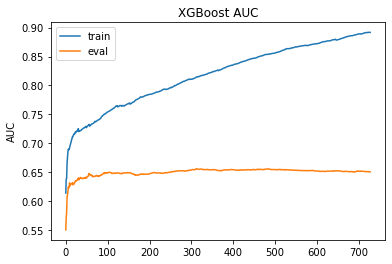

In [71]:
# rcParams['figure.figsize'] =5,5
# rcParams.update({'font.size': 10})
results = bst_sk.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='train')
ax.plot(x_axis, results['validation_1']['auc'], label='eval')
ax.legend()
pyplot.ylabel('AUC')
pyplot.title('XGBoost AUC')
pyplot.show()

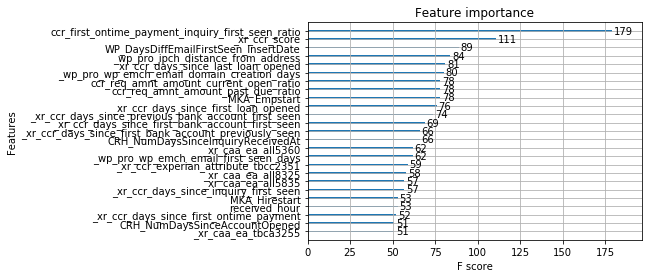

In [72]:
xgb.plot_importance(bst_sk, max_num_features =25)
pyplot.show()

In [73]:
simple_split_pred = bst_sk.predict_proba(X_vald)
fpr, tpr, thresholds = metrics.roc_curve(y_vald, simple_split_pred[:,0], pos_label=0)
print('AUC')
print(metrics.auc(fpr, tpr))

AUC
0.6504233842363338


In [74]:
X_vald.shape

(1270, 1849)

In [75]:
#Print most important features and visually inspect them
#If any feature doesn't make sense investigate and remove/keep accordignly
pd.set_option('display.max_rows', 400)
feature_imp = pd.DataFrame.from_dict(bst_sk.get_booster().get_score(importance_type = "weight"), orient='index')
print(feature_imp.shape)
feature_imp_top = feature_imp.loc[feature_imp[0]>0]
print(feature_imp_top.shape)
print(feature_imp_top.sort_values(by=[0], ascending = False))

(791, 1)
(791, 1)
                                                      0
ccr_first_ontime_payment_inquiry_first_seen_ratio   179
_xr_ccr_score                                       111
WP_DaysDiffEmailFirstSeen_InsertDate                 89
_wp_pro_ipch_distance_from_address                   84
_xr_ccr_days_since_last_loan_opened                  81
...                                                 ...
_xr_cfi_crosstabs_crosstab_drivers_license_bank...    1
_xr_ccr_sties_sty_ALL.nlp_three_years_ago             1
CRH_tirh_ratio_24h7d                                  1
_xr_cfi_sties_sty_bank_account_thirty_days_ago        1
_xr_caa_ea_brc0400                                    1

[791 rows x 1 columns]


In [76]:
array=bst_sk.feature_importances_

list_index=[val for sublist in np.argwhere((array>=0.00) & (array<=0.0)).tolist() for val in sublist]
list_values=[]
zero_importance_features=[]
for i in list_index:
        list_values.append(array[i]*100)
        col_name=X_train.columns[i]
        zero_importance_features.append(col_name)
        #print(i," ",np.round(array[i]*100,3),"   ", col_name)

np.round(sum(list_values),3)

0.0

In [77]:
len(zero_importance_features)

1058

In [100]:
#Save the list of zero_importance_features to avoid rerunning

In [78]:
#zero_importance_features.to_pickle('zero_importance_features1.pkl')
data = np.array(zero_importance_features)
np.savez("zero_importance_features1_leadgen_mar2021", data)
# a = np.load("Myfile.npz")

In [219]:
npzfile = np.load("zero_importance_features1_leadgen_mar2021.npz")
zero_importance_features = npzfile['arr_0']
zero_importance_features

array(['email_period_count', 'email_username_has_period_bin',
       'first_seen_bankaccount_bin', ...,
       'wp_ipch_geolocation_country_name_PuertoRico',
       'wp_ipch_geolocation_country_name_UnitedStates',
       'wp_ipch_geolocation_country_name_nan'], dtype='<U65')

In [220]:
len(zero_importance_features)

1058

In [80]:
feature_list = X_train.columns

In [81]:
print(len(feature_list))
feature_list=[x for x in feature_list if x not in (zero_importance_features + ['CI_Age'])]
#print(len(feature_list),feature_list, end= " ")
print(len(feature_list))

1849
791


In [86]:
#Subsetting the dataframe to discard features with zero feature importance
X_train_reduced = X_train[feature_list].copy()
X_vald_reduced = X_vald[feature_list].copy()
eval_set = [(X_train_reduced, y_train), (X_vald_reduced, y_vald)]

In [87]:
X_train_reduced.shape

(10159, 791)

In [88]:
#Training to see the quality of the model with just the slected features - iterative process as more features could be added/removed
#Until similar performance is reached to the full model
eval_set = [(X_train_reduced, y_train), (X_vald_reduced, y_vald)]

params ={'colsample_bytree': 1.0,
  'gamma': 12.0,
  'learning_rate': 0.005,
  'max_depth': 10,
  'min_child_weight': 34,
  'n_estimators': 715,
  'subsample': 0.3587006436935736}
bst_sk_reduced = xgb.XGBClassifier(predict_proba = True, n_jobs = -1,tree_method = 'hist',scale_pos_weight = scale_pos_weight ,objective = 'binary:logistic', **params)
bst_sk_reduced.fit(X_train_reduced, y_train, eval_set=eval_set, eval_metric=['logloss', 'auc'], verbose=50)

[0]	validation_0-logloss:0.69254	validation_0-auc:0.56617	validation_1-logloss:0.69259	validation_1-auc:0.53339
[50]	validation_0-logloss:0.67024	validation_0-auc:0.73815	validation_1-logloss:0.67547	validation_1-auc:0.63359
[100]	validation_0-logloss:0.65752	validation_0-auc:0.75233	validation_1-logloss:0.66756	validation_1-auc:0.64180
[150]	validation_0-logloss:0.64190	validation_0-auc:0.75918	validation_1-logloss:0.65610	validation_1-auc:0.64551
[200]	validation_0-logloss:0.63019	validation_0-auc:0.76426	validation_1-logloss:0.64913	validation_1-auc:0.64459
[250]	validation_0-logloss:0.61566	validation_0-auc:0.77457	validation_1-logloss:0.63909	validation_1-auc:0.64550
[300]	validation_0-logloss:0.60463	validation_0-auc:0.78483	validation_1-logloss:0.63168	validation_1-auc:0.64955
[350]	validation_0-logloss:0.59443	validation_0-auc:0.79286	validation_1-logloss:0.62463	validation_1-auc:0.65209
[400]	validation_0-logloss:0.58694	validation_0-auc:0.79948	validation_1-logloss:0.62153	va

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=12.0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.005, max_delta_step=0, max_depth=10,
              min_child_weight=34, missing=nan, monotone_constraints=None,
              n_estimators=715, n_jobs=-1, num_parallel_tree=1,
              predict_proba=True, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=3.117957032833401, subsample=0.3587006436935736,
              tree_method='hist', validate_parameters=False, verbosity=None)

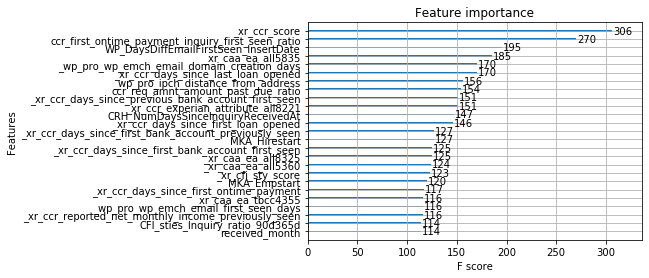

In [89]:
xgb.plot_importance(bst_sk_reduced, max_num_features =25)
pyplot.show()

In [90]:
simple_split_pred = bst_sk_reduced.predict_proba(X_vald_reduced)
fpr, tpr, thresholds = metrics.roc_curve(y_vald, simple_split_pred[:,0], pos_label=0)
print('AUC')
print(metrics.auc(fpr, tpr))

AUC
0.6511137410417986


In [91]:
#Print most important features and visually inspect them
#If any feature doesn't make sense investigate and remove/keep accordignly
pd.set_option('display.max_rows', 400)
feature_imp = pd.DataFrame.from_dict(bst_sk_reduced.get_booster().get_score(importance_type = "weight"), orient='index')
print(feature_imp.shape)
feature_imp_top = feature_imp.loc[feature_imp[0]>0]
print(feature_imp_top.shape)
print(feature_imp_top.sort_values(by=[0], ascending = False))

(701, 1)
(701, 1)
                                                      0
_xr_ccr_score                                       306
ccr_first_ontime_payment_inquiry_first_seen_ratio   270
WP_DaysDiffEmailFirstSeen_InsertDate                195
_xr_caa_ea_all5835                                  185
_wp_pro_wp_emch_email_domain_creation_days          170
...                                                 ...
_xr_caa_sties_sty_C6.inq_one_year_ago                 1
_xr_ccr_sties_sty_C1.dd_ninety_days_ago               1
bankaccount_to_ssn                                    1
_xr_cfi_multiple_one_minute_ago                       1
_xr_crh_iclrh_recent_history_current_inquiry_cl...    1

[701 rows x 1 columns]


In [92]:
#Print most important features and visually inspect them
#If any feature doesn't make sense investigate and remove/keep accordignly
pd.set_option('display.max_rows', 400)
feature_imp = pd.DataFrame.from_dict(bst_sk_reduced.get_booster().get_score(importance_type = "weight"), orient='index')
print(feature_imp.shape)
feature_imp_top = feature_imp.loc[feature_imp[0]>10]
print(feature_imp_top.shape)
print(feature_imp_top.sort_values(by=[0], ascending = False))

(701, 1)
(351, 1)
                                                      0
_xr_ccr_score                                       306
ccr_first_ontime_payment_inquiry_first_seen_ratio   270
WP_DaysDiffEmailFirstSeen_InsertDate                195
_xr_caa_ea_all5835                                  185
_xr_ccr_days_since_last_loan_opened                 170
_wp_pro_wp_emch_email_domain_creation_days          170
_wp_pro_ipch_distance_from_address                  156
ccr_req_amnt_amount_past_due_ratio                  154
_xr_ccr_experian_attribute_all8221                  151
_xr_ccr_days_since_previous_bank_account_first_...  151
CRH_NumDaysSinceInquiryReceivedAt                   147
_xr_ccr_days_since_first_loan_opened                146
_xr_ccr_days_since_first_bank_account_previousl...  127
MKA_Hirestart                                       127
_xr_ccr_days_since_first_bank_account_first_seen    125
_xr_caa_ea_all8325                                  125
_xr_caa_ea_all5360            

In [93]:
len(feature_imp_top.index)

351

In [123]:
#feature_imp_top.index.tolist()

In [94]:
feature_imp_top.index

Index(['_xr_ccr_experian_attribute_bcx7110', '_xr_caa_debt_ratio',
       '_xr_ccr_experian_attribute_all7936',
       '_xr_ccr_sties_sty_ALL.ato_three_years_ago',
       '_xr_i_ssn_first_last_name_count', '_xr_caa_ea_tbca3255',
       '_wp_pro_ipch_distance_from_address',
       '_xr_crh_srh_trrhs_trrh_highest_credit',
       '_xr_ccr_sties_sty_C3.dd_seven_years_ago',
       '_xr_caa_sties_sty_C5.inq_two_years_ago',
       ...
       '_xr_ccr_sties_sty_C1.ato_seven_years_ago',
       '_xr_ccr_tradelines_tradeline_ALL.aco_credit_limit',
       'WP_IPTypeCellular', '_xr_caa_ea_iqt9425',
       '_xr_ccr_experian_attribute_col3210',
       '_xr_cfi_rs_r_seven_days_ago_ninety_days_ago',
       '_xr_ccr_sties_sty_C1.inq_ninety_days_ago', 'CRH_Last3Pmts_CCC',
       'CRH_MOP_ENG_C_open_and_pastdue', '_xr_i_bank_account_zeros'],
      dtype='object', length=351)

In [95]:
#Subsetting the dataframe to just keep features with importance >70
print(X_train.shape)
X_train_reduced = X_train[feature_imp_top.index].copy()
X_vald_reduced = X_vald[feature_imp_top.index].copy()
eval_set = [(X_train_reduced, y_train), (X_vald_reduced, y_vald)]
print(X_train_reduced.shape)

(10159, 1849)
(10159, 351)


In [96]:
#Training to see the quality of the model with just the slected features - iterative process as more features could be added/removed
#Until similar performance is reached to the full model
eval_set = [(X_train_reduced, y_train), (X_vald_reduced, y_vald)]

params ={'colsample_bytree': 1.0,
  'gamma': 12.0,
  'learning_rate': 0.005,
  'max_depth': 10,
  'min_child_weight': 34,
  'n_estimators': 715,
  'subsample': 0.3587006436935736}
xgbc_reduced = xgb.XGBClassifier(predict_proba = True, n_jobs = -1,tree_method = 'hist',scale_pos_weight = scale_pos_weight ,objective = 'binary:logistic', **params)
xgbc_reduced.fit(X_train_reduced, y_train, eval_set=eval_set, eval_metric=['logloss', 'auc'], verbose=50)

[0]	validation_0-logloss:0.69272	validation_0-auc:0.61085	validation_1-logloss:0.69278	validation_1-auc:0.55990
[50]	validation_0-logloss:0.67160	validation_0-auc:0.74514	validation_1-logloss:0.67685	validation_1-auc:0.64469
[100]	validation_0-logloss:0.65391	validation_0-auc:0.75910	validation_1-logloss:0.66403	validation_1-auc:0.64953
[150]	validation_0-logloss:0.63748	validation_0-auc:0.76536	validation_1-logloss:0.65197	validation_1-auc:0.64962
[200]	validation_0-logloss:0.62527	validation_0-auc:0.77487	validation_1-logloss:0.64453	validation_1-auc:0.65167
[250]	validation_0-logloss:0.61260	validation_0-auc:0.78252	validation_1-logloss:0.63596	validation_1-auc:0.65355
[300]	validation_0-logloss:0.60301	validation_0-auc:0.79130	validation_1-logloss:0.63055	validation_1-auc:0.65389
[350]	validation_0-logloss:0.59449	validation_0-auc:0.79945	validation_1-logloss:0.62569	validation_1-auc:0.65656
[400]	validation_0-logloss:0.58714	validation_0-auc:0.80918	validation_1-logloss:0.62292	va

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=12.0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.005, max_delta_step=0, max_depth=10,
              min_child_weight=34, missing=nan, monotone_constraints=None,
              n_estimators=715, n_jobs=-1, num_parallel_tree=1,
              predict_proba=True, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=3.117957032833401, subsample=0.3587006436935736,
              tree_method='hist', validate_parameters=False, verbosity=None)

In [97]:
simple_split_pred = xgbc_reduced.predict_proba(X_vald_reduced)
fpr, tpr, thresholds = metrics.roc_curve(y_vald, simple_split_pred[:,0], pos_label=0)
print('AUC')
print(metrics.auc(fpr, tpr))

AUC
0.6585623276270758


In [98]:
feature_imp_top.to_pickle('top_features_leadgen_mar2021.pkl')

In [99]:
feature_imp_top.shape

(351, 1)

In [100]:
feature_imp_top = pd.read_pickle('top_features_leadgen_mar2021.pkl')

In [101]:
kept_features = feature_imp_top.index.tolist()

In [102]:
simple_split_pred = xgbc_reduced.predict_proba(X_test[feature_imp_top.index])
fpr, tpr, thresholds = metrics.roc_curve(y_test, simple_split_pred[:,0], pos_label=0)
print('AUC')
print(metrics.auc(fpr, tpr))

AUC
0.6344735901331665


<brc>

<brc>

<brc>

<brc>

## Out of Sample Testing

In [221]:
oost_data = pd.read_pickle('oost_data_Jan2021_leadgen.pkl')

In [222]:
oost_data.insert_date

lead_sequence_id
2299328300   2019-10-01 07:01:49
2299328573   2019-10-01 07:04:37
2299339515   2019-10-01 08:37:44
2299341077   2019-10-01 08:47:17
2299341634   2019-10-01 08:50:26
                     ...        
2347406418   2020-07-31 18:32:47
2347408164   2020-07-31 18:53:55
2347408903   2020-07-31 19:02:54
2347410503   2020-07-31 19:23:56
2347412004   2020-07-31 19:44:16
Name: insert_date, Length: 3250, dtype: datetime64[ns]

In [223]:

#Manually filter out columns
rm_list = ["campaign_name", "decision", "ipaddress", "lead_cost", "lead_provider_name", "routingnumber", "RULE_DESCRIPTION", 
           "state", "uw_cost", "UW_STREAM_ID", "zip", "insert_date", "/mk/exp_lead_value"]
#model_building_data = model_building_data.drop(rm_list, axis=1)
oost_data = oost_data.loc[:,~oost_data.columns.isin(rm_list)]
#remove datetime format columns
oost_data = oost_data.select_dtypes(exclude=['datetime'])
#remove Infs and NAs & convert bool to numeric
oost_data = hf.cleanupInfNABool(oost_data)

In [224]:
oost_data.shape

(3250, 1540)

In [384]:
#Dealing with the outliers in the income
oost_data['netmonthly_org'] = oost_data.netmonthly
oost_data.loc[oost_data.netmonthly>=outlier_cut_off_app_inc2_upper, 'netmonthly'] = outlier_cut_off_app_inc2_upper
#clarity_orig_label.hist(column=['netmonthly'])

In [385]:
#Renaming the income variable to with the model var name
oost_data.rename(columns = {'netmonthly': 'netmonthly'+model_var_rename}, inplace = True)

In [386]:
oost_data.dtypes.value_counts()

float64     1447
object        79
int64         14
category       1
dtype: int64

In [387]:
#Normalizing true and false columns and converting them into numeric avoiding an added dimentionality when one hot encoding(depends)
#and the correct labeling of missing values as missing
def true_false_to_numeric(df, bool_col_list):
    #Normalize to lower case
    for col in bool_col_list:
        df[col] = df[col].astype(str).copy()
        df[col] = df[col].str.lower().copy()
        df.loc[df[col] == 'true',col] = 1
        df.loc[df[col] == 'false',col] = 0
        df[col] = df[col].replace(r'^\s*$', np.nan, regex=True).copy()
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df.rename(columns = {col: col+'_bin'}, inplace = True)
    return df
    #handle empty strings

binary_columns = ['/wp_pro/wp_adch_is_forwarder',
'/wp_pro/wp_emch_is_autogenerated',
'/wp_pro/wp_phch_is_commercial',
'/wp_pro/ipch_connection_type',
'/wp_pro/wp_adch_is_active',
'/wp_pro/wp_adch_is_commercial',
'/xr/crh/srh/trrhs/trrh/account-in-collections',
'/xr/crh/srh/trrhs/trrh/account-charged-off',
'/xr/crh/srh/surh/online-loan-opened-in-the-last-year',
'/xr/crh/srh/surh/online-loan-inquiry-in-the-last-thirty-days',
'/xr/i/paycheck-direct-deposit',
'email_username_has_firstname',
'email_username_has_lastname',
'email_username_has_period', 'first_seen_bankaccount',
'first_seen_email', 'first_seen_homephone', 'first_seen_ssn',
'is_first_seen_email', 'is_first_seen_ssn',
'ssn_endswith_email_digits_2'
]

In [388]:
print(oost_data.shape)
oost_data = true_false_to_numeric(oost_data, binary_columns)
print(oost_data.shape)

(3250, 1541)
(3250, 1541)


In [389]:
#Convert string to boolean to numeric - Manual

oost_data.rename(columns = {'/xr/ccr/inquiry-seen-excluding-484d': '/xr/ccr/inquiry-seen-excluding-484d_bin'}, inplace = True)
oost_data.loc[oost_data['/xr/ccr/inquiry-seen-excluding-484d_bin'] == True,'/xr/ccr/inquiry-seen-excluding-484d_bin'] = 1
oost_data.loc[oost_data['/xr/ccr/inquiry-seen-excluding-484d_bin'] == False,'/xr/ccr/inquiry-seen-excluding-484d_bin'] = 0
oost_data.loc[oost_data['/xr/ccr/inquiry-seen-excluding-484d_bin'].isnull(),'/xr/ccr/inquiry-seen-excluding-484d_bin'] = 2


In [390]:
oost_data['ccr_req_amnt_amount_current_open_ratio'] = (oost_data['requestedamount'] / oost_data['/xr/ccr/amount-of-loans-current-and-open']).round(2)
oost_data['ccr_req_amnt_amount_past_due_ratio'] = (oost_data['requestedamount'] / oost_data['/xr/ccr/amount-of-loans-past-due']).round(2)

In [391]:
oost_data['ccr_first_ontime_payment_inquiry_first_seen_ratio'] = (oost_data['/xr/ccr/days-since-first-ontime-payment'] / oost_data['/xr/ccr/days-since-inquiry-first-seen']).round(2)

In [392]:
oost_data['ccr_current_open_total_loans_ratio'] = (oost_data['/xr/ccr/number-of-loans-current-and-open'] / oost_data['/xr/ccr/number-of-loans']).round(2)

In [393]:
oost_data['/xr/i/bank-account-zeros'] = pd.to_numeric(oost_data['/xr/i/bank-account-zeros'])

In [394]:

#Deal with duplicate columns
print(sum(oost_data.columns.duplicated()))
oost_data = oost_data.loc[:,~oost_data.columns.duplicated()]

0


In [395]:
#Deleting columns with a high ratio of missing values that are not on the exception list
for item in allMissCols:
    if item not in missing_exception_list:
        del oost_data[item]

In [396]:
# cfi score, seasonality, payfrequency should be excluded
del oost_data['/xr/cfi/score']

In [397]:
#Save to pickle
oost_data.to_pickle('oost_data_Jan2021_leadgen2.pkl')

In [106]:
#Read saved pickle - usefull for saving time to avoid rerunning everything
oost_data = pd.read_pickle('oost_data_Jan2021_leadgen2.pkl')

In [107]:
oost_data.shape

(3250, 1542)

In [399]:
#Creating a copy of the dataframe to be used for the PMML model
#Createing a one hot encoded copy of the dataframe to be used for train test validation 
oost_data_copy = oost_data.copy()
print(oost_data_copy.shape)
oost_data_dummed = pd.get_dummies(oost_data, dummy_na=True, drop_first=False)
print(oost_data_dummed.shape)

(3250, 1542)
(3250, 1820)


In [400]:
print(oost_data_dummed.dtypes.value_counts())

float64    1459
uint8       336
int64        25
dtype: int64


In [401]:
#Save dummed tp pickle
#Save to pickle
oost_data_dummed.to_pickle('oost_data_dummed_Jan2021_leadgen2.pkl')

# Read saved pickle

In [226]:
oost_data_dummed = pd.read_pickle('oost_data_dummed_Jan2021_leadgen2.pkl')

In [227]:
# drop isFPD
oost_data_dummed = oost_data_dummed.drop(['isFPD','CI_Age'], axis =1)

In [228]:
oost_data_dummed.shape

(3250, 1818)

In [229]:
oost_data_dummed.columns

Index(['digits_in_email_username', 'email_period_count', 'email_seen_count',
       'email_username_has_firstname_bin', 'email_username_has_lastname_bin',
       'email_username_has_period_bin', 'first_seen_bankaccount_bin',
       'first_seen_email_bin', 'first_seen_email_days',
       'first_seen_homephone_bin',
       ...
       'state_long_Ohio', 'state_long_South Carolina', 'state_long_Texas',
       'state_long_Utah', 'state_long_Washington', 'state_long_nan',
       'wp_ipch_geolocation/country_code_US',
       'wp_ipch_geolocation/country_code_nan',
       'wp_ipch_geolocation/country_name_UnitedStates',
       'wp_ipch_geolocation/country_name_nan'],
      dtype='object', length=1818)

In [230]:
oost_data_dummed.rename(columns = {'MKA_AgeHiredate': 'MKA_Hirestart','MKA_AgeHireDateInRange':'MKA_HirestartInRange','MKA_AgeEmpstart':'MKA_Empstart','MKA_AgeEmpstartInRange':'MKA_EmpstartInRange'}, inplace = True)

In [231]:
#Replacing all / and - with _ for consistency with Java code and code reliability
oost_data_dummed.columns = [re.sub(" |/|-|_", "_", elem) for elem in oost_data_dummed.columns.values]

In [232]:
oost_data_dummed.columns

Index(['digits_in_email_username', 'email_period_count', 'email_seen_count',
       'email_username_has_firstname_bin', 'email_username_has_lastname_bin',
       'email_username_has_period_bin', 'first_seen_bankaccount_bin',
       'first_seen_email_bin', 'first_seen_email_days',
       'first_seen_homephone_bin',
       ...
       'state_long_Ohio', 'state_long_South_Carolina', 'state_long_Texas',
       'state_long_Utah', 'state_long_Washington', 'state_long_nan',
       'wp_ipch_geolocation_country_code_US',
       'wp_ipch_geolocation_country_code_nan',
       'wp_ipch_geolocation_country_name_UnitedStates',
       'wp_ipch_geolocation_country_name_nan'],
      dtype='object', length=1818)

In [233]:
X_oost = oost_data_dummed.drop(['bad'], axis =1)
X_oost.shape

(3250, 1817)

In [116]:
y_oost = oost_data_dummed.bad
y_oost.shape

(3250,)

In [117]:
feature_imp_top.shape

(351, 1)

In [118]:
feature_imp_top.index.tolist()

['_xr_ccr_experian_attribute_bcx7110',
 '_xr_caa_debt_ratio',
 '_xr_ccr_experian_attribute_all7936',
 '_xr_ccr_sties_sty_ALL.ato_three_years_ago',
 '_xr_i_ssn_first_last_name_count',
 '_xr_caa_ea_tbca3255',
 '_wp_pro_ipch_distance_from_address',
 '_xr_crh_srh_trrhs_trrh_highest_credit',
 '_xr_ccr_sties_sty_C3.dd_seven_years_ago',
 '_xr_caa_sties_sty_C5.inq_two_years_ago',
 '_xr_cfi_crosstabs_crosstab_home_phone_home_address',
 '_xr_ccr_score',
 '_xr_ccr_sties_sty_C3.ato_two_years_ago',
 'CCRCAA_C3NumberofLoansScore',
 '_xr_caa_ea_rtr0300',
 '_xr_crh_iclrh_ticlrh_ninety_days_ago',
 'received_month',
 '_xr_caa_ea_bca5030',
 '_xr_ccr_sties_sty_ALL.dlp_seven_years_ago',
 '_xr_ccr_amount_of_loans',
 'ccr_req_amnt_amount_past_due_ratio',
 '_xr_cfi_crosstabs_crosstab_ssn_zip_code',
 'req_amt_to_income',
 '_xr_ccr_days_since_last_loan_opened',
 '_xr_ccr_experian_attribute_tbcc2351',
 '_xr_crh_srh_trrhs_trrh_scheduled_payment',
 'MKA_DaysSinceHiredate',
 'WP_DaysDiffEmailFirstSeen_InsertDate',


In [120]:
simple_split_pred = xgbc_reduced.predict_proba((X_oost[feature_imp_top.index]))
fpr, tpr, thresholds = metrics.roc_curve(y_oost, simple_split_pred[:,0], pos_label=0)
print('AUC')
print(metrics.auc(fpr, tpr))

AUC
0.6333050395641491


In [121]:
import utils_helper_functions as uhf
X_oost_all = X_oost.assign(prob = (simple_split_pred[:,0]*1000).round(0))
X_oost_all = X_oost_all.assign(prob_binned = uhf.freq_table(var=X_oost_all['prob'], break_type='quantile', seq_length=11))

In [122]:
# cf score
pd.crosstab(X_oost_all['prob_binned'], y_oost , normalize = 'index')

bad,0,1
prob_binned,,
"(206.999, 412.0]",0.575758,0.424242
"(412.0, 465.8]",0.678125,0.321875
"(465.8, 502.0]",0.704819,0.295181
"(502.0, 532.0]",0.746130,0.253870
"(532.0, 559.0]",0.737654,0.262346
"(559.0, 589.0]",0.750760,0.249240
"(589.0, 620.0]",0.789969,0.210031
"(620.0, 656.0]",0.853211,0.146789
"(656.0, 699.0]",0.855385,0.144615


In [123]:
# cf score
pd.crosstab(X_oost_all['prob_binned'], y_oost)

bad,0,1
prob_binned,,
"(206.999, 412.0]",190,140
"(412.0, 465.8]",217,103
"(465.8, 502.0]",234,98
"(502.0, 532.0]",241,82
"(532.0, 559.0]",239,85
"(559.0, 589.0]",247,82
"(589.0, 620.0]",252,67
"(620.0, 656.0]",279,48
"(656.0, 699.0]",278,47


### Oost has two parts: 1.5 months before lunching hd (oct 1 - nov 15), july 2020

In [124]:
# Part 1
simple_split_pred = xgbc_reduced.predict_proba((X_oost.loc[raw_data_label[((raw_data_label.insert_date>=pd.to_datetime('2019-10-01')) & (raw_data_label.insert_date<=pd.to_datetime('2019-11-15')))].index][feature_imp_top.index]))
fpr, tpr, thresholds = metrics.roc_curve((y_oost[raw_data_label[((raw_data_label.insert_date>=pd.to_datetime('2019-10-01')) & (raw_data_label.insert_date<=pd.to_datetime('2019-11-15')))].index]), simple_split_pred[:,0], pos_label=0)
print('AUC')
print(metrics.auc(fpr, tpr))

AUC
0.6235698527525524


In [125]:
lds_part1 = [raw_data_label[((raw_data_label.insert_date>=pd.to_datetime('2019-10-01')) & (raw_data_label.insert_date<=pd.to_datetime('2019-11-15')))].index]

In [126]:
lds_part1

[Int64Index([2299328300, 2299328573, 2299339515, 2299341077, 2299341634,
             2299345541, 2299360802, 2299363096, 2299371277, 2299373561,
             ...
             2310077990, 2310079825, 2310082534, 2310086079, 2310087401,
             2310093712, 2310097975, 2310100561, 2310100669, 2310106127],
            dtype='int64', name='lead_sequence_id', length=2213)]

In [129]:
# Part 2
simple_split_pred = xgbc_reduced.predict_proba((X_oost.loc[raw_data_label[(raw_data_label.insert_date>=pd.to_datetime('2020-07-01'))].index][feature_imp_top.index]))
fpr, tpr, thresholds = metrics.roc_curve((y_oost[raw_data_label[(raw_data_label.insert_date>=pd.to_datetime('2020-07-01'))].index]), simple_split_pred[:,0], pos_label=0)
print('AUC')
print(metrics.auc(fpr, tpr))

AUC
0.6543350294323057


In [130]:
raw_data_label.isFPD

lead_sequence_id
2275654718    0.0
2275655824    0.0
2275659462    0.0
2275661797    0.0
2275677243    0.0
             ... 
2347406418    0.0
2347408164    0.0
2347408903    0.0
2347410503    0.0
2347412004    0.0
Name: isFPD, Length: 15949, dtype: float64

### Let's comapre it with HD as the baseline, and by fpd as the target, rather than the model target variable (it's common between hd and cf score)

### Retrieve HD score for oost 

Most probably only part 2 has hd score, as hd score was not lunched for part 1

In [234]:
conn= mysql.connector.connect(option_files='.my.cnf',option_groups='mysqlconnection', use_pure=True)
hd_score=pd.read_sql("""select
                        lead_sequence_id,
                        mk_hd_risk_paid_off_cfi_ccr_caa_score as hd_score
                        from datawork.mk_application_more
                        where
                        lead_sequence_id in """ + str(tuple(X_oost.index)) + """
                        and mk_hd_risk_paid_off_cfi_ccr_caa_score > -1
                        ;
                        """, con = conn)
conn.close()
print(hd_score.shape )

(1033, 2)


In [235]:
#Save to pickle
hd_score.to_pickle('hd_score_leadgen.pkl')

In [236]:
hd_score = pd.read_pickle('hd_score_leadgen.pkl')

In [237]:
print(hd_score.shape)
hd_score.set_index('lead_sequence_id', inplace = True)
print(hd_score.shape)

(1033, 2)
(1033, 1)


In [238]:
#Read saved pickle - usefull for saving time to avoid rerunning everything
raw_data_label = pd.read_pickle('raw_data_label_Jan2021.pkl')

In [137]:
raw_data_label

,digits_in_email_username,dow,email_period_count,email_seen_count,email_username_has_firstname,email_username_has_lastname,email_username_has_period,first_seen_bankaccount,first_seen_email,first_seen_email_days,...,WP_IPTypeCable,WP_IPTypeCellular,WP_IPTypeCorporate,WP_IsDiffState_Subdivision,state_long,wp_ipch_geolocation/continent_code,wp_ipch_geolocation/country_code,wp_ipch_geolocation/country_name,isFPD,bad
lead_sequence_id,,,,,,,,,,,,,,,,,,,,,
2275654718,0.0,5,0.0,NaN,false,false,false,true,true,NaN,...,0.0,0.0,1.0,0.0,Florida,NaN,US,UnitedStates,0.0,0
2275655824,4.0,5,0.0,1.0,false,false,false,false,false,40.0,...,0.0,1.0,0.0,0.0,Kentucky,NaN,US,UnitedStates,0.0,0
2275659462,4.0,5,0.0,NaN,true,false,false,true,true,NaN,...,0.0,1.0,0.0,1.0,Michigan,NaN,US,UnitedStates,0.0,1
2275661797,0.0,5,0.0,NaN,true,true,false,true,true,NaN,...,1.0,0.0,0.0,1.0,Florida,NaN,US,UnitedStates,0.0,1
2275677243,4.0,NaN,0.0,NaN,false,false,false,true,true,NaN,...,1.0,0.0,0.0,1.0,Michigan,NaN,US,UnitedStates,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347410503,4.0,1,0.0,3.0,false,false,false,true,false,694.0,...,0.0,1.0,0.0,0.0,Alabama,NaN,US,UnitedStates,0.0,1
2347412004,8.0,NaN,0.0,NaN,true,false,false,true,true,NaN,...,1.0,0.0,0.0,1.0,Texas,NaN,US,UnitedStates,0.0,0
2347414124,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,true,NaN,...,NaN,NaN,NaN,NaN,Florida,NaN,NaN,NaN,0.0,0


In [139]:
raw_data_label.rename(columns = {'MKA_AgeHiredate': 'MKA_Hirestart','MKA_AgeHireDateInRange':'MKA_HirestartInRange','MKA_AgeEmpstart':'MKA_Empstart','MKA_AgeEmpstartInRange':'MKA_EmpstartInRange'}, inplace = True)

In [140]:
simple_split_pred = xgbc_reduced.predict_proba(X_oost[feature_imp_top.index])
fpr, tpr, thresholds = metrics.roc_curve(raw_data_label.loc[X_oost.index]['isFPD'], simple_split_pred[:,0], pos_label=0)
print('AUC')
print(metrics.auc(fpr, tpr))

AUC
0.60906451396348


In [142]:
feature_imp_top

,0
_xr_ccr_experian_attribute_bcx7110,68
_xr_caa_debt_ratio,114
_xr_ccr_experian_attribute_all7936,98
_xr_ccr_sties_sty_ALL.ato_three_years_ago,30
_xr_i_ssn_first_last_name_count,29
_xr_caa_ea_tbca3255,97
_wp_pro_ipch_distance_from_address,156
_xr_crh_srh_trrhs_trrh_highest_credit,52
_xr_ccr_sties_sty_C3.dd_seven_years_ago,28
_xr_caa_sties_sty_C5.inq_two_years_ago,24


In [147]:
X_oost.loc[:,feature_imp_top.index]

,_xr_ccr_experian_attribute_bcx7110,_xr_caa_debt_ratio,_xr_ccr_experian_attribute_all7936,_xr_ccr_sties_sty_ALL.ato_three_years_ago,_xr_i_ssn_first_last_name_count,_xr_caa_ea_tbca3255,_wp_pro_ipch_distance_from_address,_xr_crh_srh_trrhs_trrh_highest_credit,_xr_ccr_sties_sty_C3.dd_seven_years_ago,_xr_caa_sties_sty_C5.inq_two_years_ago,...,_xr_ccr_sties_sty_C1.ato_seven_years_ago,_xr_ccr_tradelines_tradeline_ALL.aco_credit_limit,WP_IPTypeCellular,_xr_caa_ea_iqt9425,_xr_ccr_experian_attribute_col3210,_xr_cfi_rs_r_seven_days_ago_ninety_days_ago,_xr_ccr_sties_sty_C1.inq_ninety_days_ago,CRH_Last3Pmts_CCC,CRH_MOP_ENG_C_open_and_pastdue,_xr_i_bank_account_zeros
lead_sequence_id,,,,,,,,,,,,,,,,,,,,,
2299328300,996.0,66.0,36.0,10629.0,12.0,999999997.0,6.0,500.0,110.0,0.0,...,0.0,NaN,0.0,4.0,5.0,1.00,0.0,0,0,0.0
2299328573,74.0,0.0,100.0,0.0,37.0,633.0,916.0,NaN,0.0,0.0,...,425.0,NaN,0.0,1.0,0.0,1.00,3.0,0,0,0.0
2299339515,111.0,0.0,100.0,1540.0,29.0,317.0,65.0,NaN,0.0,0.0,...,400.0,NaN,1.0,0.0,0.0,1.00,1.0,0,0,1.0
2299341077,96.0,0.0,100.0,0.0,17.0,217.0,12.0,NaN,0.0,1.0,...,0.0,NaN,1.0,1.0,0.0,1.00,1.0,0,0,0.0
2299341634,997.0,53.0,50.0,2770.0,75.0,546.0,195.0,800.0,230.0,0.0,...,0.0,NaN,1.0,1.0,0.0,0.53,5.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347406418,996.0,0.0,0.0,0.0,29.0,999999997.0,2.0,NaN,0.0,0.0,...,0.0,NaN,1.0,0.0,2.0,1.00,2.0,0,0,0.0
2347408164,81.0,94.0,33.0,1917.0,21.0,253.0,10.0,367.0,295.0,0.0,...,0.0,NaN,0.0,1.0,1.0,1.00,0.0,0,0,0.0
2347408903,996.0,94.0,62.0,13800.0,29.0,116.0,2.0,4000.0,1112.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.82,3.0,1,0,0.0


In [151]:
print(X_oost.shape)
print(raw_data_label.shape)

(3250, 1817)
(19482, 1545)


In [155]:
# Part 1
# CF risk Score
print(X_oost.reindex(index=raw_data_label[((raw_data_label.insert_date>=pd.to_datetime('2019-10-01')) & (raw_data_label.insert_date<=pd.to_datetime('2019-11-15')))].index,columns=feature_imp_top.index).shape)
simple_split_pred = xgbc_reduced.predict_proba((X_oost.reindex(index=raw_data_label[((raw_data_label.insert_date>=pd.to_datetime('2019-10-01')) & (raw_data_label.insert_date<=pd.to_datetime('2019-11-15')))].index,columns=feature_imp_top.index)))
fpr, tpr, thresholds = metrics.roc_curve((raw_data_label.reindex(index=raw_data_label[((raw_data_label.insert_date>=pd.to_datetime('2019-10-01')) & (raw_data_label.insert_date<=pd.to_datetime('2019-11-15')))].index,columns=['isFPD'])), simple_split_pred[:,0], pos_label=0)
print('AUC')
print(metrics.auc(fpr, tpr))

(2236, 351)
AUC
0.6233035041387216


In [157]:
# Part 2
# CF risk Score
print(X_oost.reindex(index=raw_data_label[(raw_data_label.insert_date>=pd.to_datetime('2020-07-01'))].index,columns=feature_imp_top.index).shape)
simple_split_pred = xgbc_reduced.predict_proba((X_oost.reindex(index=raw_data_label[(raw_data_label.insert_date>=pd.to_datetime('2020-07-01'))].index,columns=feature_imp_top.index)))
fpr, tpr, thresholds = metrics.roc_curve((raw_data_label.reindex(index=raw_data_label[(raw_data_label.insert_date>=pd.to_datetime('2020-07-01'))].index,columns=['isFPD'])), simple_split_pred[:,0], pos_label=0)
print('AUC')
print(metrics.auc(fpr, tpr))

(1564, 351)
AUC
0.5829520716189943


In [158]:
# Part 2
# HD score
fpr, tpr, thresholds = metrics.roc_curve((raw_data_label.loc[hd_score.index]['isFPD']), hd_score['hd_score']/1000, pos_label=0)
print('AUC')
print(metrics.auc(fpr, tpr))

AUC
0.532951323819134


In [159]:
X_oost_reduced_part2 = X_oost.loc[hd_score.index][feature_imp_top.index] 

In [160]:
preds = xgbc_reduced.predict_proba((X_oost.loc[hd_score.index][feature_imp_top.index]))

In [161]:
import utils_helper_functions as uhf
X_oost_reduced_part2 = X_oost_reduced_part2.assign(prob = (preds[:,0]*1000).round(0))
X_oost_reduced_part2 = X_oost_reduced_part2.assign(prob_binned = uhf.freq_table(var=X_oost_reduced_part2['prob'], break_type='quantile', seq_length=11))

In [162]:
# cf score
pd.crosstab(X_oost_reduced_part2['prob_binned'], (raw_data_label.loc[hd_score.index]['isFPD']), normalize = 'index')

isFPD,0.0,1.0
prob_binned,,
"(251.999, 430.0]",0.923810,0.076190
"(430.0, 480.4]",0.950980,0.049020
"(480.4, 515.0]",0.961905,0.038095
"(515.0, 539.0]",0.950980,0.049020
"(539.0, 563.0]",0.972222,0.027778
"(563.0, 591.2]",0.969388,0.030612
"(591.2, 626.0]",0.952830,0.047170
"(626.0, 663.0]",0.971154,0.028846
"(663.0, 707.0]",0.960784,0.039216


In [163]:
# cf score
pd.crosstab(X_oost_reduced_part2['prob_binned'], (raw_data_label.loc[hd_score.index]['isFPD']))

isFPD,0.0,1.0
prob_binned,,
"(251.999, 430.0]",97,8
"(430.0, 480.4]",97,5
"(480.4, 515.0]",101,4
"(515.0, 539.0]",97,5
"(539.0, 563.0]",105,3
"(563.0, 591.2]",95,3
"(591.2, 626.0]",101,5
"(626.0, 663.0]",101,3
"(663.0, 707.0]",98,4


### 5 buckets

In [164]:
import utils_helper_functions as uhf
X_oost_reduced_part2 = X_oost_reduced_part2.assign(prob = (preds[:,0]*1000).round(0))
X_oost_reduced_part2 = X_oost_reduced_part2.assign(prob_binned = uhf.freq_table(var=X_oost_reduced_part2['prob'], break_type='quantile', seq_length=6))

In [165]:
# cf score
pd.crosstab(X_oost_reduced_part2['prob_binned'], (raw_data_label.loc[hd_score.index]['isFPD']), normalize = 'index')

isFPD,0.0,1.0
prob_binned,,
"(251.999, 480.4]",0.937198,0.062802
"(480.4, 539.0]",0.956522,0.043478
"(539.0, 591.2]",0.970874,0.029126
"(591.2, 663.0]",0.961905,0.038095
"(663.0, 810.0]",0.970443,0.029557


In [166]:
# cf score
pd.crosstab(X_oost_reduced_part2['prob_binned'], (raw_data_label.loc[hd_score.index]['isFPD']))

isFPD,0.0,1.0
prob_binned,,
"(251.999, 480.4]",194,13
"(480.4, 539.0]",198,9
"(539.0, 591.2]",200,6
"(591.2, 663.0]",202,8
"(663.0, 810.0]",197,6


In [167]:
hd_score = hd_score.assign(prob_binned = uhf.freq_table(var=hd_score['hd_score'], break_type='quantile', seq_length=11))

In [168]:
# hd score
pd.crosstab(hd_score['prob_binned'], (raw_data_label.loc[hd_score.index]['isFPD']), normalize = 'index')

isFPD,0.0,1.0
prob_binned,,
"(292.999, 600.2]",0.932692,0.067308
"(600.2, 629.4]",0.961165,0.038835
"(629.4, 654.0]",0.943925,0.056075
"(654.0, 678.0]",0.990476,0.009524
"(678.0, 699.0]",0.970000,0.030000
"(699.0, 723.0]",0.970588,0.029412
"(723.0, 746.0]",0.932039,0.067961
"(746.0, 766.0]",0.961165,0.038835
"(766.0, 800.0]",0.951923,0.048077


In [169]:
# hd score
pd.crosstab(hd_score['prob_binned'], (raw_data_label.loc[hd_score.index]['isFPD']))

isFPD,0.0,1.0
prob_binned,,
"(292.999, 600.2]",97,7
"(600.2, 629.4]",99,4
"(629.4, 654.0]",101,6
"(654.0, 678.0]",104,1
"(678.0, 699.0]",97,3
"(699.0, 723.0]",99,3
"(723.0, 746.0]",96,7
"(746.0, 766.0]",99,4
"(766.0, 800.0]",99,5


### 5 Buckets

In [170]:
hd_score = hd_score.assign(prob_binned = uhf.freq_table(var=hd_score['hd_score'], break_type='quantile', seq_length=6))

In [171]:
# hd score
pd.crosstab(hd_score['prob_binned'], (raw_data_label.loc[hd_score.index]['isFPD']), normalize = 'index')

isFPD,0.0,1.0
prob_binned,,
"(292.999, 629.4]",0.946860,0.053140
"(629.4, 678.0]",0.966981,0.033019
"(678.0, 723.0]",0.970297,0.029703
"(723.0, 766.0]",0.946602,0.053398
"(766.0, 892.0]",0.966019,0.033981


In [172]:
# hd score
pd.crosstab(hd_score['prob_binned'], (raw_data_label.loc[hd_score.index]['isFPD']))

isFPD,0.0,1.0
prob_binned,,
"(292.999, 629.4]",196,11
"(629.4, 678.0]",205,7
"(678.0, 723.0]",196,6
"(723.0, 766.0]",195,11
"(766.0, 892.0]",199,7


<br>

<br>

<br>

<br>

# Both leadgen and marketplace
### Build a model by both leadgen and marketplace to make decision for marketplace
### Don't have enough marketplace to train the model just by marketplace

In [366]:
#Read saved pickle - usefull for saving time to avoid rerunning everything
raw_data_label = pd.read_pickle('raw_data_label_Jan2021.pkl')

In [367]:
# print(raw_data_label.shape)
# raw_data_label = raw_data_label[raw_data_label.channel.isin(['LeadGen-NM', 'LeadGen-M', 'LeadGen-LINC'])]
# print(raw_data_label.shape)

In [368]:
print(raw_data_label.shape)

(19482, 1545)


In [369]:
#out-of-sample-test set (oost set)
# last month + 1.5 months before lunching hd score for credit fresh
# July 2020, Oct 2019, first half of Nov 2019
oost_data = raw_data_label[(raw_data_label.insert_date>=pd.to_datetime('2020-07-01')) | ((raw_data_label.insert_date>=pd.to_datetime('2019-10-01')) & (raw_data_label.insert_date<=pd.to_datetime('2019-11-15')))]
print("oost_data shape: " + str(oost_data.shape))

oost_data shape: (3800, 1545)


In [330]:
print(oost_data.shape)
oost_data = oost_data[~oost_data.channel.isin(['LeadGen-NM', 'LeadGen-M', 'LeadGen-LINC'])]
print(oost_data.shape)

(3800, 1545)
(550, 1545)


In [331]:
oost_data

,digits_in_email_username,dow,email_period_count,email_seen_count,email_username_has_firstname,email_username_has_lastname,email_username_has_period,first_seen_bankaccount,first_seen_email,first_seen_email_days,...,WP_IPTypeCable,WP_IPTypeCellular,WP_IPTypeCorporate,WP_IsDiffState_Subdivision,state_long,wp_ipch_geolocation/continent_code,wp_ipch_geolocation/country_code,wp_ipch_geolocation/country_name,isFPD,bad
lead_sequence_id,,,,,,,,,,,,,,,,,,,,,
2301470450,3.0,NaN,0.0,1.0,false,true,false,NaN,false,478.0,...,0.0,1.0,0.0,1.0,Michigan,NaN,US,UnitedStates,0.0,0
2301708591,0.0,5,0.0,NaN,false,false,false,NaN,true,NaN,...,0.0,1.0,0.0,NaN,Michigan,NaN,US,UnitedStates,0.0,0
2301899101,1.0,NaN,0.0,NaN,false,true,false,NaN,true,NaN,...,1.0,0.0,0.0,1.0,Kentucky,NaN,US,UnitedStates,0.0,0
2301907348,1.0,NaN,0.0,6.0,true,false,false,NaN,false,2179.0,...,0.0,1.0,0.0,1.0,Ohio,NaN,US,UnitedStates,0.0,0
2302442799,0.0,5,0.0,NaN,false,false,false,NaN,true,NaN,...,1.0,0.0,0.0,1.0,Kentucky,NaN,US,UnitedStates,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347406320,NaN,4,NaN,1.0,NaN,NaN,NaN,NaN,false,277.0,...,NaN,NaN,NaN,NaN,Washington,NaN,NaN,NaN,0.0,1
2347407809,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,true,NaN,...,NaN,NaN,NaN,NaN,Florida,NaN,NaN,NaN,0.0,0
2347414124,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,true,NaN,...,NaN,NaN,NaN,NaN,Florida,NaN,NaN,NaN,0.0,0


In [332]:
oost_data.to_pickle('oost_data_Jan2021_marketplace.pkl')

In [370]:
(raw_data_label.insert_date>=pd.to_datetime('2020-07-01'))

lead_sequence_id
2275654718    False
2275655824    False
2275659462    False
2275661797    False
2275677243    False
              ...  
2347410503     True
2347412004     True
2347414124     True
2347414131     True
2347414190     True
Name: insert_date, Length: 19482, dtype: bool

In [371]:
#model bulding set
model_building_data = raw_data_label[~(raw_data_label.index.isin(oost_data.index))]
print("model_building_data shape: " + str(model_building_data.shape))

model_building_data shape: (15682, 1545)


In [372]:

#Manually filter out columns
rm_list = ["campaign_name", "decision", "ipaddress", "lead_cost", "lead_provider_name", "routingnumber", "RULE_DESCRIPTION", 
           "state", "uw_cost", "UW_STREAM_ID", "zip", "insert_date", "/mk/exp_lead_value"]
#model_building_data = model_building_data.drop(rm_list, axis=1)
model_building_data = model_building_data.loc[:,~model_building_data.columns.isin(rm_list)]


#remove datetime format columns
model_building_data = model_building_data.select_dtypes(exclude=['datetime'])

#remove Infs and NAs & convert bool to numeric
model_building_data = hf.cleanupInfNABool(model_building_data)

In [373]:
model_building_data.shape

(15682, 1540)

In [374]:
model_building_data.shape

(15682, 1540)

In [375]:
model_building_data.netmonthly

lead_sequence_id
2275654718    3500.0
2275655824    5000.0
2275659462    3500.0
2275661797    4000.0
2275677243    5000.0
               ...  
2343757445    5000.0
2343758701    5000.0
2343759574    6500.0
2343760442    4500.0
2343768626    6000.0
Name: netmonthly, Length: 15682, dtype: float64

In [376]:
model_building_data.netmonthly.median()

5000.0

In [377]:
np.nanmedian(model_building_data.netmonthly)

5000.0

In [378]:
(3*scst.iqr(model_building_data.netmonthly,nan_policy = 'omit'))

4500.0

In [379]:
#Dealing with the outliers in the income
model_building_data['netmonthly_org'] = model_building_data.netmonthly

#Van Gestel and Baesens 2009 #Upper/Lower limit = M +- 3s, with M= median and s = IQR/(2*0.6745)
outlier_cut_off_app_inc2_upper = (np.nanmedian(model_building_data.netmonthly) + (3*scst.iqr(model_building_data.netmonthly,nan_policy = 'omit')) / (2*0.6745)).round()
#Printing the outlier cap to be used in the JAVA implementation
print(outlier_cut_off_app_inc2_upper)

model_building_data.loc[model_building_data.netmonthly>=outlier_cut_off_app_inc2_upper, 'netmonthly'] = outlier_cut_off_app_inc2_upper
#clarity_orig_label.hist(column=['netmonthly'])

8336.0


In [382]:
#Renaming the income variable to with the model var name
model_building_data.rename(columns = {'netmonthly': 'netmonthly'+model_var_rename}, inplace = True)

In [383]:
model_building_data.dtypes.value_counts()

float64     1446
object        80
int64         14
category       1
dtype: int64

In [385]:
#Printing a list of object columns to deal with them
model_building_data.columns[model_building_data.dtypes == 'object'].values

array(['dow', 'email_username_has_firstname',
       'email_username_has_lastname', 'email_username_has_period',
       'first_seen_bankaccount', 'first_seen_email',
       'first_seen_homephone', 'first_seen_ssn', 'is_first_seen_email',
       'is_first_seen_ssn', 'ssn_endswith_email_digits_2', 'emptype',
       'incometype', 'rentorown', 'channel',
       '/xr/caa/too-many-tradelines',
       '/xr/ccr/inquiry-seen-excluding-484d',
       '/xr/ccr/inquiry-seen-including-48', '/xr/ccr/too-many-inquiries',
       '/xr/ccr/too-many-tradelines',
       '/xr/cfi/crosstabs/crosstab/ssn/email-address',
       '/xr/cfi/fraud-signature-match', '/xr/cfi/hit',
       '/xr/cfi/i/credit-established-before-age-18',
       '/xr/cfi/i/credit-established-prior-to-ssn-issue-date',
       '/xr/cfi/i/current-address-reported-by-new-trade-only',
       '/xr/cfi/i/current-address-reported-by-trade-open-lt-90-days',
       '/xr/cfi/i/in-state-bank-i',
       '/xr/cfi/i/input-ssn-issue-date-cannot-be-verifie

In [386]:
#Double checking for duplicate columns - from the merging
print([col for col in model_building_data.columns.values if '_y' in col])
print([col for col in model_building_data.columns.values if '_x' in col])

[]
[]


In [387]:
#Normalizing true and false columns and converting them into numeric avoiding an added dimentionality when one hot encoding(depends)
#and the correct labeling of missing values as missing
def true_false_to_numeric(df, bool_col_list):
    #Normalize to lower case
    for col in bool_col_list:
        df[col] = df[col].astype(str).copy()
        df[col] = df[col].str.lower().copy()
        df.loc[df[col] == 'true',col] = 1
        df.loc[df[col] == 'false',col] = 0
        df[col] = df[col].replace(r'^\s*$', np.nan, regex=True).copy()
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df.rename(columns = {col: col+'_bin'}, inplace = True)
    return df
    #handle empty strings

binary_columns = ['/wp_pro/wp_adch_is_forwarder',
'/wp_pro/wp_emch_is_autogenerated',
'/wp_pro/wp_phch_is_commercial',
'/wp_pro/ipch_connection_type',
'/wp_pro/wp_adch_is_active',
'/wp_pro/wp_adch_is_commercial',
'/xr/crh/srh/trrhs/trrh/account-in-collections',
'/xr/crh/srh/trrhs/trrh/account-charged-off',
'/xr/crh/srh/surh/online-loan-opened-in-the-last-year',
'/xr/crh/srh/surh/online-loan-inquiry-in-the-last-thirty-days',
'/xr/i/paycheck-direct-deposit',
'email_username_has_firstname',
'email_username_has_lastname',
'email_username_has_period', 'first_seen_bankaccount',
'first_seen_email', 'first_seen_homephone', 'first_seen_ssn',
'is_first_seen_email', 'is_first_seen_ssn',
'ssn_endswith_email_digits_2'
]

In [388]:
print(model_building_data.shape)
model_building_data = true_false_to_numeric(model_building_data, binary_columns)
print(model_building_data.shape)

(15682, 1541)
(15682, 1541)


In [389]:
[col for col in model_building_data.columns if 'excluding' in col]

['/xr/ccr/inquiry-seen-excluding-484d']

In [390]:
model_building_data['/xr/ccr/inquiry-seen-excluding-484d'].unique()

array([True, False, nan], dtype=object)

In [391]:
#Convert string to boolean to numeric - Manual

model_building_data.rename(columns = {'/xr/ccr/inquiry-seen-excluding-484d': '/xr/ccr/inquiry-seen-excluding-484d_bin'}, inplace = True)
model_building_data.loc[model_building_data['/xr/ccr/inquiry-seen-excluding-484d_bin'] == True,'/xr/ccr/inquiry-seen-excluding-484d_bin'] = 1
model_building_data.loc[model_building_data['/xr/ccr/inquiry-seen-excluding-484d_bin'] == False,'/xr/ccr/inquiry-seen-excluding-484d_bin'] = 0
model_building_data.loc[model_building_data['/xr/ccr/inquiry-seen-excluding-484d_bin'].isnull(),'/xr/ccr/inquiry-seen-excluding-484d_bin'] = 2


In [394]:
model_building_data['ccr_req_amnt_amount_current_open_ratio'] = (model_building_data['requestedamount'] / model_building_data['/xr/ccr/amount-of-loans-current-and-open']).round(2)
model_building_data['ccr_req_amnt_amount_past_due_ratio'] = (model_building_data['requestedamount'] / model_building_data['/xr/ccr/amount-of-loans-past-due']).round(2)

In [395]:
model_building_data['ccr_first_ontime_payment_inquiry_first_seen_ratio'] = (model_building_data['/xr/ccr/days-since-first-ontime-payment'] / model_building_data['/xr/ccr/days-since-inquiry-first-seen']).round(2)

In [396]:
model_building_data['ccr_current_open_total_loans_ratio'] = (model_building_data['/xr/ccr/number-of-loans-current-and-open'] / model_building_data['/xr/ccr/number-of-loans']).round(2)

In [397]:
model_building_data['/xr/i/bank-account-zeros'] = pd.to_numeric(model_building_data['/xr/i/bank-account-zeros'])

In [398]:

#Deal with duplicate columns
print(sum(model_building_data.columns.duplicated()))
model_building_data = model_building_data.loc[:,~model_building_data.columns.duplicated()]


0


In [399]:
#Creating a list of object columns with more than x levels
#This is a quality check that avoid huge dimentionality increase if a high cardinality variable was left
#exception list allows to add exception if a variable could still be very predictive despite high level count (some DataX and return code vars for example)
num_levels = 40
highLevelCols = list()
for column in model_building_data:
    if(model_building_data[column].dtype == 'object'):
        if model_building_data[column].nunique()>num_levels:
            print(column)
            print(model_building_data[column].nunique())
            highLevelCols.append(column)

exception_list = []

/xr/cfi/iv/phone-name-address-match-code
44
/xr/cfi/iv/ssn-name-address-match-code
43


In [400]:
# The values are close to threshold, leave it
# #Deleting columns in the  highLevelCols list and not in the exception list
# for item in highLevelCols:
#     if item not in exception_list:
#         del clarity_orig_label[item]

In [401]:
#Quality check - checking the proportion of missing values by column
#Creating a list of columns with high missing propertion to be later dropped
#exception list same as prior cell
missing_threshold = 0.95
allMissCols = list()
for column in model_building_data:
    #print(column)
    if(sum(model_building_data[column].isna()) >= (missing_threshold*model_building_data[column].shape[0] )):
        print(column)
        print(sum(model_building_data[column].isna()) / model_building_data[column].shape[0])
        allMissCols.append(column)
missing_exception_list = []

/wp_pro/ipch_connection_type_bin
1.0
wp_ipch_geolocation/continent_code
0.9999362326233898


In [402]:
#Deleting columns with a high ratio of missing values that are not on the exception list
for item in allMissCols:
    if item not in missing_exception_list:
        del model_building_data[item]

In [403]:
# cfi score, seasonality, payfrequency should be excluded
del model_building_data['/xr/cfi/score']

In [404]:
#Save to pickle
model_building_data.to_pickle('model_building_data_Jan2021_both.pkl')

In [405]:
#Read saved pickle - usefull for saving time to avoid rerunning everything
model_building_data = pd.read_pickle('model_building_data_Jan2021_both.pkl')

In [406]:
model_building_data.shape

(15682, 1542)

In [408]:
#Creating a copy of the dataframe to be used for the PMML model
#Createing a one hot encoded copy of the dataframe to be used for train test validation 
model_building_data_copy = model_building_data.copy()
print(model_building_data_copy.shape)
model_building_data_dummed = pd.get_dummies(model_building_data, dummy_na=True, drop_first=False)
print(model_building_data_dummed.shape)

(15682, 1542)
(15682, 1901)


In [409]:
print(model_building_data_dummed.dtypes.value_counts())

float64    1462
uint8       417
int64        22
dtype: int64


In [596]:
model_building_data_dummed.columns

Index(['digits_in_email_username', 'email_period_count', 'email_seen_count',
       'email_username_has_firstname_bin', 'email_username_has_lastname_bin',
       'email_username_has_period_bin', 'first_seen_bankaccount_bin',
       'first_seen_email_bin', 'first_seen_email_days',
       'first_seen_homephone_bin',
       ...
       'wp_ipch_geolocation/country_code_PR',
       'wp_ipch_geolocation/country_code_US',
       'wp_ipch_geolocation/country_code_nan',
       'wp_ipch_geolocation/country_name_AntiguaandBarbuda',
       'wp_ipch_geolocation/country_name_Canada',
       'wp_ipch_geolocation/country_name_Honduras',
       'wp_ipch_geolocation/country_name_Netherlands',
       'wp_ipch_geolocation/country_name_PuertoRico',
       'wp_ipch_geolocation/country_name_UnitedStates',
       'wp_ipch_geolocation/country_name_nan'],
      dtype='object', length=1901)

In [702]:
# def intersection(lst1, lst2): 
#     lst3 = [value for value in lst1 if value in lst2] 
#     return lst3 
# intersec = intersection(clarity_orig_label_copy.columns, clarity_orig_label_dummed.columns)
# #diff = [col for col in clarity_orig_label_copy.columns if col not in intersec]
# diff = [col for col in clarity_orig_label_dummed.columns if col not in intersec]
# diff
# # list of the categorical features dummy effect on 

In [597]:
#Save dummed tp pickle
#Save to pickle
model_building_data_dummed.to_pickle('model_building_data_dummed_Jan2021_both.pkl')

# Read saved pickle

In [248]:
model_building_data_dummed = pd.read_pickle('model_building_data_dummed_Jan2021_both.pkl')

### Try Graphdb features

In [249]:
#Get graph db
conn= mysql.connector.connect(option_files='.my.cnf', option_groups = 'mysqlconnection',use_pure=True)
#Get graph db
gd_df = pd.read_sql("SELECT lead_sequence_id,`/graphdb/connected_apps` as connected_apps, `/graphdb/connected_ssn` as connected_ssn FROM  datawork.mk_application_more where `lead_sequence_id` IN "+str(tuple(model_building_data_dummed.index))+ " ;", 
                                  con = conn)
conn.close()
print(gd_df.shape)

(15682, 3)


In [250]:
#Save to pickle
gd_df.to_pickle('gd_df.pkl')

In [251]:
gd_df = pd.read_pickle('gd_df.pkl')

In [252]:
# graph db variables
gd_df['connected_apps=1']=(gd_df['connected_apps']==1.0)
gd_df['connected_apps>1']=(gd_df['connected_apps']>1.0)
gd_df['connected_apps>4']=(gd_df['connected_apps']>4.0)
gd_df['connected_apps>10']=(gd_df['connected_apps']>10.0)
gd_df['connected_apps>20']=(gd_df['connected_apps']>20.0)
gd_df['connected_apps>30']=(gd_df['connected_apps']>30.0)

gd_df['connected_apps=1']=(gd_df['connected_apps']==1.0)
gd_df['1<connected_apps<=4']=(gd_df['connected_apps']>1.0) & (gd_df['connected_apps']<=4.0)
gd_df['4<connected_apps<=10']=(gd_df['connected_apps']>4.0) & (gd_df['connected_apps']<=10.0)
gd_df['10<connected_apps<=20']=(gd_df['connected_apps']>10.0) & (gd_df['connected_apps']<=20.0)
gd_df['20<connected_apps<=30']=(gd_df['connected_apps']>20.0) & (gd_df['connected_apps']<=30.0)
gd_df['30<connected_apps']=(gd_df['connected_apps']>30.0)

gd_df['connected_ssn=1']=(gd_df['connected_ssn']==1.0)
gd_df['connected_ssn=2']=(gd_df['connected_ssn']==2.0)
gd_df['connected_ssn>=3']=(gd_df['connected_ssn']>=3.0)

gd_df.loc[gd_df['connected_apps'].isna(), 'connected_apps=1'] = np.NaN
gd_df.loc[gd_df['connected_apps'].isna(), 'connected_apps>1'] = np.NaN
gd_df.loc[gd_df['connected_apps'].isna(), 'connected_apps>4'] = np.NaN
gd_df.loc[gd_df['connected_apps'].isna(), 'connected_apps>10'] = np.NaN
gd_df.loc[gd_df['connected_apps'].isna(), 'connected_apps>20'] = np.NaN
gd_df.loc[gd_df['connected_apps'].isna(), 'connected_apps>30'] = np.NaN
gd_df.loc[gd_df['connected_apps'].isna(), '1<connected_apps<=4'] = np.NaN
gd_df.loc[gd_df['connected_apps'].isna(), '4<connected_apps<=10'] = np.NaN
gd_df.loc[gd_df['connected_apps'].isna(), '10<connected_apps<=20'] = np.NaN
gd_df.loc[gd_df['connected_apps'].isna(), '20<connected_apps<=30'] = np.NaN
gd_df.loc[gd_df['connected_apps'].isna(), '30<connected_apps'] = np.NaN

gd_df.loc[gd_df['connected_ssn'].isna(), 'connected_ssn=1'] = np.NaN
gd_df.loc[gd_df['connected_ssn'].isna(), 'connected_ssn=2'] = np.NaN
gd_df.loc[gd_df['connected_ssn'].isna(), 'connected_ssn>=3'] = np.NaN

In [253]:
gd_df

,lead_sequence_id,connected_apps,connected_ssn,connected_apps=1,connected_apps>1,connected_apps>4,connected_apps>10,connected_apps>20,connected_apps>30,1<connected_apps<=4,4<connected_apps<=10,10<connected_apps<=20,20<connected_apps<=30,30<connected_apps,connected_ssn=1,connected_ssn=2,connected_ssn>=3
0,2275654718,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2275655824,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2275659462,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2275661797,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2275677243,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15677,2343757445,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15678,2343758701,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15679,2343759574,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15680,2343760442,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [254]:
#Replacing all / and - with _ for consistency with Java code and code reliability
gd_df.columns = [re.sub("<|>", "_", elem) for elem in gd_df.columns.values]

In [255]:
#Replacing all / and - with _ for consistency with Java code and code reliability
gd_df.columns = [re.sub("=", "__", elem) for elem in gd_df.columns.values]

In [256]:
print(gd_df.shape)
gd_df.set_index('lead_sequence_id', inplace = True)
print(gd_df.shape)

(15682, 17)
(15682, 16)


In [257]:
print(model_building_data_dummed.shape)
model_building_data_dummed = model_building_data_dummed.merge(gd_df, left_index=True, right_index=True, how = 'left')
print(model_building_data_dummed.shape)

(15682, 1901)
(15682, 1917)


In [233]:
# drop isFPD and age related
model_building_data_dummed = model_building_data_dummed.drop(['isFPD','CI_Age','CI_NumDaysSinceDateOfBirth'], axis =1)

In [234]:
[col for col in model_building_data_dummed.columns if 'Age' in col]
# Shows all names are in database format

['MKA_AgeHiredate',
 'MKA_AgeHireDateInRange',
 'MKA_AgeEmpstart',
 'MKA_AgeEmpstartInRange']

In [235]:
[col for col in model_building_data_dummed.columns if 'age' in col]
# Shows all names are in database format

['/xr/caa/percentage-of-loans-30-days-past-due',
 '/xr/caa/percentage-of-loans-60-days-past-due',
 '/xr/caa/percentage-of-loans-90-days-past-due',
 '/xr/crh/srh/surh/spml-average-rollovers',
 '/xr/cfi/i/credit-established-before-age-18_false',
 '/xr/cfi/i/credit-established-before-age-18_true',
 '/xr/cfi/i/credit-established-before-age-18_nan',
 '/xr/cfi/i/inquiry-age-younger-than-ssn-issue-date_false',
 '/xr/cfi/i/inquiry-age-younger-than-ssn-issue-date_true',
 '/xr/cfi/i/inquiry-age-younger-than-ssn-issue-date_nan',
 '/wp_pro/wp_emch_registered_owner_age_range_18-24',
 '/wp_pro/wp_emch_registered_owner_age_range_25-29',
 '/wp_pro/wp_emch_registered_owner_age_range_30-34',
 '/wp_pro/wp_emch_registered_owner_age_range_35-39',
 '/wp_pro/wp_emch_registered_owner_age_range_40-44',
 '/wp_pro/wp_emch_registered_owner_age_range_45-49',
 '/wp_pro/wp_emch_registered_owner_age_range_50-54',
 '/wp_pro/wp_emch_registered_owner_age_range_55-59',
 '/wp_pro/wp_emch_registered_owner_age_range_60-64',

In [236]:
model_building_data_dummed.shape

(15682, 1914)

In [237]:
# drop age related
print(model_building_data_dummed.shape)
model_building_data_dummed = model_building_data_dummed.drop(['/wp_pro/wp_emch_registered_owner_age_range_18-24',
 '/wp_pro/wp_emch_registered_owner_age_range_25-29',
 '/wp_pro/wp_emch_registered_owner_age_range_30-34',
 '/wp_pro/wp_emch_registered_owner_age_range_35-39',
 '/wp_pro/wp_emch_registered_owner_age_range_40-44',
 '/wp_pro/wp_emch_registered_owner_age_range_45-49',
 '/wp_pro/wp_emch_registered_owner_age_range_50-54',
 '/wp_pro/wp_emch_registered_owner_age_range_55-59',
 '/wp_pro/wp_emch_registered_owner_age_range_60-64',
 '/wp_pro/wp_emch_registered_owner_age_range_65-69',
 '/wp_pro/wp_emch_registered_owner_age_range_70-74',
 '/wp_pro/wp_emch_registered_owner_age_range_75-79',
 '/wp_pro/wp_emch_registered_owner_age_range_80-84',
 '/wp_pro/wp_emch_registered_owner_age_range_85-89',
 '/wp_pro/wp_emch_registered_owner_age_range_90+',
 '/wp_pro/wp_emch_registered_owner_age_range_nan',
 '/wp_pro/wp_phch_subscriber_age_range_18-24',
 '/wp_pro/wp_phch_subscriber_age_range_25-29',
 '/wp_pro/wp_phch_subscriber_age_range_30-34',
 '/wp_pro/wp_phch_subscriber_age_range_35-39',
 '/wp_pro/wp_phch_subscriber_age_range_40-44',
 '/wp_pro/wp_phch_subscriber_age_range_45-49',
 '/wp_pro/wp_phch_subscriber_age_range_50-54',
 '/wp_pro/wp_phch_subscriber_age_range_55-59',
 '/wp_pro/wp_phch_subscriber_age_range_60-64',
 '/wp_pro/wp_phch_subscriber_age_range_65-69',
 '/wp_pro/wp_phch_subscriber_age_range_70-74',
 '/wp_pro/wp_phch_subscriber_age_range_75-79',
 '/wp_pro/wp_phch_subscriber_age_range_80-84',
 '/wp_pro/wp_phch_subscriber_age_range_85-89',
 '/wp_pro/wp_phch_subscriber_age_range_90+',
 '/wp_pro/wp_phch_subscriber_age_range_nan'], axis =1)
print(model_building_data_dummed.shape)

(15682, 1914)
(15682, 1882)


In [238]:
[col for col in model_building_data_dummed.columns if 'age' in col]
# Shows all names are in database format

['/xr/caa/percentage-of-loans-30-days-past-due',
 '/xr/caa/percentage-of-loans-60-days-past-due',
 '/xr/caa/percentage-of-loans-90-days-past-due',
 '/xr/crh/srh/surh/spml-average-rollovers',
 '/xr/cfi/i/credit-established-before-age-18_false',
 '/xr/cfi/i/credit-established-before-age-18_true',
 '/xr/cfi/i/credit-established-before-age-18_nan',
 '/xr/cfi/i/inquiry-age-younger-than-ssn-issue-date_false',
 '/xr/cfi/i/inquiry-age-younger-than-ssn-issue-date_true',
 '/xr/cfi/i/inquiry-age-younger-than-ssn-issue-date_nan']

In [239]:
model_building_data_dummed.rename(columns = {'MKA_AgeHiredate': 'MKA_Hirestart','MKA_AgeHireDateInRange':'MKA_HirestartInRange','MKA_AgeEmpstart':'MKA_Empstart','MKA_AgeEmpstartInRange':'MKA_EmpstartInRange'}, inplace = True)

In [240]:
model_building_data_dummed.shape

(15682, 1882)

In [245]:
# Remove the features which are not available for marketplace at hb1
print(model_building_data_dummed.shape)
model_building_data_dummed = model_building_data_dummed.drop([
'MKAM_DOW_OriginalNextPaydate','dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_nan','/xr/i/bank-account-zeros','CI_NumDaysUntilDateOfNextPayday', 'CI_NumDaysUntilDateOfNextPaydayInRange','old_loan_amount'], axis =1)
print(model_building_data_dummed.shape)

(15682, 1882)
(15682, 1871)


In [249]:
#Replacing all / and - with _ for consistency with Java code and code reliability
model_building_data_dummed.columns = [re.sub(" |/|-|_|=|<|>", "_", elem) for elem in model_building_data_dummed.columns.values]

In [250]:
#Split between Train 80% Validation 10% and Test 10%
X_train, X_other, y_train, y_other = train_test_split(model_building_data_dummed.drop(['bad'], axis =1), model_building_data_dummed.bad, test_size=0.20, random_state=42)
X_vald, X_test, y_vald, y_test = train_test_split(X_other, y_other, test_size=0.5, random_state=42)

In [251]:
print(X_train.shape)
print(X_vald.shape)
print(X_test.shape)

(12545, 1870)
(1568, 1870)
(1569, 1870)


In [252]:
print(sum(y_train.isnull()))
print(sum(y_vald.isnull()))

0
0


In [253]:
print(X_train.dtypes.value_counts())
print(X_vald.dtypes.value_counts())

float64    1471
uint8       379
int64        20
dtype: int64
float64    1471
uint8       379
int64        20
dtype: int64


In [254]:
# calculate 'scale_pos_weight' as sum(negative class)/sum(positive class)
print(y_train.value_counts())
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
round(scale_pos_weight,2)

0    9633
1    2912
Name: bad, dtype: int64


3.31

In [255]:
eval_set = [(X_train, y_train), (X_vald, y_vald)]
params ={'colsample_bytree': 1.0,
  'gamma': 12.0,
  'learning_rate': 0.005,
  'max_depth': 10,
  'min_child_weight': 34,
  'n_estimators': 715,
  'subsample': 0.3587006436935736}
bst_sk = xgb.XGBClassifier(predict_proba = True, n_jobs = -1,tree_method = 'hist',scale_pos_weight = scale_pos_weight ,objective = 'binary:logistic', **params)
bst_sk.fit(X_train, y_train, eval_set=eval_set, eval_metric=['logloss', 'auc'], verbose=50)

[0]	validation_0-logloss:0.69566	validation_0-auc:0.49074	validation_1-logloss:0.69577	validation_1-auc:0.47484
[50]	validation_0-logloss:0.68605	validation_0-auc:0.71929	validation_1-logloss:0.69161	validation_1-auc:0.60874
[100]	validation_0-logloss:0.67072	validation_0-auc:0.74682	validation_1-logloss:0.68169	validation_1-auc:0.62714
[150]	validation_0-logloss:0.65986	validation_0-auc:0.76131	validation_1-logloss:0.67617	validation_1-auc:0.63306
[200]	validation_0-logloss:0.64551	validation_0-auc:0.77112	validation_1-logloss:0.66708	validation_1-auc:0.63428
[250]	validation_0-logloss:0.62948	validation_0-auc:0.77991	validation_1-logloss:0.65565	validation_1-auc:0.63808
[300]	validation_0-logloss:0.61507	validation_0-auc:0.78837	validation_1-logloss:0.64580	validation_1-auc:0.64064
[350]	validation_0-logloss:0.60606	validation_0-auc:0.79525	validation_1-logloss:0.64048	validation_1-auc:0.64350
[400]	validation_0-logloss:0.59827	validation_0-auc:0.80416	validation_1-logloss:0.63628	va

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=12.0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.005, max_delta_step=0, max_depth=10,
              min_child_weight=34, missing=nan, monotone_constraints=None,
              n_estimators=715, n_jobs=-1, num_parallel_tree=1,
              predict_proba=True, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=3.3080357142857144, subsample=0.3587006436935736,
              tree_method='hist', validate_parameters=False, verbosity=None)

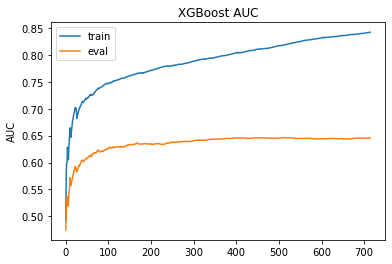

In [257]:
rcParams['figure.figsize'] =5,5
rcParams.update({'font.size': 10})
results = bst_sk.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='train')
ax.plot(x_axis, results['validation_1']['auc'], label='eval')
ax.legend()
pyplot.ylabel('AUC')
pyplot.title('XGBoost AUC')
pyplot.show()

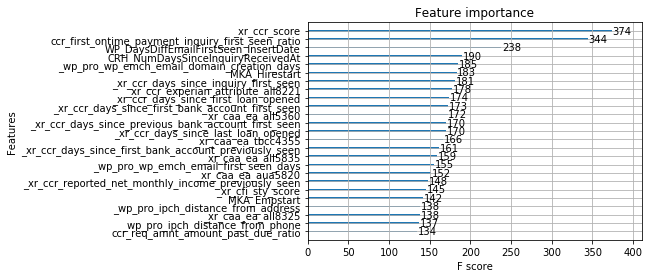

In [258]:
xgb.plot_importance(bst_sk, max_num_features =25)
pyplot.show()

In [260]:
simple_split_pred = bst_sk.predict_proba(X_vald)
fpr, tpr, thresholds = metrics.roc_curve(y_vald, simple_split_pred[:,0], pos_label=0)
print('AUC')
print(metrics.auc(fpr, tpr))

AUC
0.6454612073952904


In [261]:
X_vald.shape

(1568, 1870)

In [262]:
[col for col in feature_imp_top.index if 'connected' in col]
# no graphdb feature is selected as important features

[]

In [263]:
#Print most important features and visually inspect them
#If any feature doesn't make sense investigate and remove/keep accordignly
pd.set_option('display.max_rows', 400)
feature_imp = pd.DataFrame.from_dict(bst_sk.get_booster().get_score(importance_type = "weight"), orient='index')
print(feature_imp.shape)
feature_imp_top = feature_imp.loc[feature_imp[0]>0]
print(feature_imp_top.shape)
print(feature_imp_top.sort_values(by=[0], ascending = False))

(804, 1)
(804, 1)
                                                      0
_xr_ccr_score                                       374
ccr_first_ontime_payment_inquiry_first_seen_ratio   344
WP_DaysDiffEmailFirstSeen_InsertDate                238
CRH_NumDaysSinceInquiryReceivedAt                   190
_wp_pro_wp_emch_email_domain_creation_days          185
...                                                 ...
_xr_ccr_sties_sty_C1.dd_thirty_days_ago               1
_xr_ccr_sties_sty_C3.dcl_one_hundred_eighty_day...    1
_xr_cfi_crosstabs_crosstab_cell_phone_home_phone      1
_xr_cfi_sties_sty_home_address_twentyfour_hours...    1
_xr_ccr_sties_sty_C1.acl_three_years_ago              1

[804 rows x 1 columns]


In [264]:
array=bst_sk.feature_importances_

list_index=[val for sublist in np.argwhere((array>=0.00) & (array<=0.0)).tolist() for val in sublist]
list_values=[]
zero_importance_features=[]
for i in list_index:
        list_values.append(array[i]*100)
        col_name=X_train.columns[i]
        zero_importance_features.append(col_name)
        #print(i," ",np.round(array[i]*100,3),"   ", col_name)

np.round(sum(list_values),3)

0.0

In [265]:
len(zero_importance_features)

1066

In [266]:
feature_list = X_train.columns

In [267]:
print(len(feature_list))
feature_list=[x for x in feature_list if x not in (zero_importance_features + ['CI_Age'] +['_wp_pro_empphone_line_type_Mobile'])]
#print(len(feature_list),feature_list, end= " ")
print(len(feature_list))

1870
803


In [271]:
#Subsetting the dataframe to discard features with zero feature importance
X_train_reduced = X_train[feature_list].copy()
X_vald_reduced = X_vald[feature_list].copy()
eval_set = [(X_train_reduced, y_train), (X_vald_reduced, y_vald)]

In [272]:
X_train_reduced.shape

(12545, 803)

In [273]:
#Training to see the quality of the model with just the slected features - iterative process as more features could be added/removed
#Until similar performance is reached to the full model
eval_set = [(X_train_reduced, y_train), (X_vald_reduced, y_vald)]

params ={'colsample_bytree': 1.0,
  'gamma': 12.0,
  'learning_rate': 0.005,
  'max_depth': 10,
  'min_child_weight': 34,
  'n_estimators': 715,
  'subsample': 0.3587006436935736}
bst_sk_reduced = xgb.XGBClassifier(predict_proba = True, n_jobs = -1,tree_method = 'hist',scale_pos_weight = scale_pos_weight ,objective = 'binary:logistic', **params)
bst_sk_reduced.fit(X_train_reduced, y_train, eval_set=eval_set, eval_metric=['logloss', 'auc'], verbose=50)

[0]	validation_0-logloss:0.69566	validation_0-auc:0.49074	validation_1-logloss:0.69577	validation_1-auc:0.47484
[50]	validation_0-logloss:0.68605	validation_0-auc:0.71929	validation_1-logloss:0.69161	validation_1-auc:0.60874
[100]	validation_0-logloss:0.67075	validation_0-auc:0.74700	validation_1-logloss:0.68177	validation_1-auc:0.62714
[150]	validation_0-logloss:0.65984	validation_0-auc:0.76144	validation_1-logloss:0.67641	validation_1-auc:0.63126
[200]	validation_0-logloss:0.64496	validation_0-auc:0.77113	validation_1-logloss:0.66656	validation_1-auc:0.63381
[250]	validation_0-logloss:0.62924	validation_0-auc:0.77879	validation_1-logloss:0.65497	validation_1-auc:0.63812
[300]	validation_0-logloss:0.61538	validation_0-auc:0.78699	validation_1-logloss:0.64563	validation_1-auc:0.64059
[350]	validation_0-logloss:0.60606	validation_0-auc:0.79457	validation_1-logloss:0.64022	validation_1-auc:0.64306
[400]	validation_0-logloss:0.59839	validation_0-auc:0.80355	validation_1-logloss:0.63648	va

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=12.0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.005, max_delta_step=0, max_depth=10,
              min_child_weight=34, missing=nan, monotone_constraints=None,
              n_estimators=715, n_jobs=-1, num_parallel_tree=1,
              predict_proba=True, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=3.3080357142857144, subsample=0.3587006436935736,
              tree_method='hist', validate_parameters=False, verbosity=None)

In [274]:
simple_split_pred = bst_sk_reduced.predict_proba(X_vald_reduced)
fpr, tpr, thresholds = metrics.roc_curve(y_vald, simple_split_pred[:,0], pos_label=0)
print('AUC')
print(metrics.auc(fpr, tpr))

AUC
0.644959808697112


In [275]:
#Print most important features and visually inspect them
#If any feature doesn't make sense investigate and remove/keep accordignly
pd.set_option('display.max_rows', 400)
feature_imp = pd.DataFrame.from_dict(bst_sk_reduced.get_booster().get_score(importance_type = "weight"), orient='index')
print(feature_imp.shape)
feature_imp_top = feature_imp.loc[feature_imp[0]>0]
print(feature_imp_top.shape)
print(feature_imp_top.sort_values(by=[0], ascending = False))

(781, 1)
(781, 1)
                                                      0
_xr_ccr_score                                       369
ccr_first_ontime_payment_inquiry_first_seen_ratio   343
WP_DaysDiffEmailFirstSeen_InsertDate                244
CRH_NumDaysSinceInquiryReceivedAt                   203
_xr_ccr_days_since_previous_bank_account_first_...  183
...                                                 ...
_xr_ccr_experian_attribute_all9128                    1
CFI_sties_BA_ratio_15d30d                             1
_xr_cfi_crosstabs_crosstab_ssn_cell_phone             1
_xr_ccr_current_inquiry_cluster_position              1
_xr_ccr_sties_sty_C1.acl_three_years_ago              1

[781 rows x 1 columns]


In [276]:
#Print most important features and visually inspect them
#If any feature doesn't make sense investigate and remove/keep accordignly
pd.set_option('display.max_rows', 400)
feature_imp = pd.DataFrame.from_dict(bst_sk_reduced.get_booster().get_score(importance_type = "weight"), orient='index')
print(feature_imp.shape)
feature_imp_top = feature_imp.loc[feature_imp[0]>10]
print(feature_imp_top.shape)
print(feature_imp_top.sort_values(by=[0], ascending = False))

(781, 1)
(370, 1)
                                                      0
_xr_ccr_score                                       369
ccr_first_ontime_payment_inquiry_first_seen_ratio   343
WP_DaysDiffEmailFirstSeen_InsertDate                244
CRH_NumDaysSinceInquiryReceivedAt                   203
_xr_ccr_days_since_previous_bank_account_first_...  183
_wp_pro_wp_emch_email_domain_creation_days          181
MKA_Hirestart                                       179
_xr_ccr_days_since_first_loan_opened                178
_xr_caa_ea_tbcc4355                                 176
_xr_caa_ea_all5360                                  168
_xr_ccr_days_since_inquiry_first_seen               167
_xr_ccr_days_since_last_loan_opened                 167
_wp_pro_wp_emch_email_first_seen_days               165
_xr_ccr_experian_attribute_all8221                  164
_xr_ccr_days_since_first_bank_account_previousl...  163
_xr_caa_ea_all5835                                  163
_xr_ccr_days_since_first_bank_

In [277]:
len(feature_imp_top.index)

370

In [278]:
feature_imp_top.index

Index(['ccr_first_ontime_payment_inquiry_first_seen_ratio',
       '_xr_caa_ea_all7340', '_xr_ccr_days_since_inquiry_first_seen',
       '_xr_caa_ea_all2380', '_xr_i_ssn_last_name_count',
       '_xr_ccr_experian_attribute_rtr5038',
       '_wp_pro_wp_emch_email_domain_creation_days', '_xr_caa_ea_col5060',
       '_xr_ccr_score',
       '_xr_cfi_rs_r_fifteen_days_ago_threesixtyfive_days_ago',
       ...
       '_xr_caa_ea_stu5820', '_wp_pro_wp_adch_type_Single_unit',
       '_xr_cfi_points_total_thirty_days_ago', 'first_seen_email_days',
       '_xr_caa_ea_rev5040',
       '_xr_cfi_crosstabs_crosstab_home_address_home_phone',
       '_xr_ccr_sties_sty_C3.dd_one_year_ago', 'CFI_sties_BA_ratio_90d365d',
       '_xr_ccr_experian_attribute_tbca2624',
       '_xr_ccr_sties_sty_ALL.ato_sixty_days_ago'],
      dtype='object', length=370)

In [279]:
#Subsetting the dataframe to just keep features with importance >70
print(X_train.shape)
X_train_reduced = X_train[feature_imp_top.index].copy()
X_vald_reduced = X_vald[feature_imp_top.index].copy()
eval_set = [(X_train_reduced, y_train), (X_vald_reduced, y_vald)]
print(X_train_reduced.shape)

(12545, 1870)
(12545, 370)


In [280]:
#Training to see the quality of the model with just the slected features - iterative process as more features could be added/removed
#Until similar performance is reached to the full model
eval_set = [(X_train_reduced, y_train), (X_vald_reduced, y_vald)]

params ={'colsample_bytree': 1.0,
  'gamma': 12.0,
  'learning_rate': 0.005,
  'max_depth': 10,
  'min_child_weight': 34,
  'n_estimators': 715,
  'subsample': 0.3587006436935736}
xgbc_reduced = xgb.XGBClassifier(predict_proba = True, n_jobs = -1,tree_method = 'hist',scale_pos_weight = scale_pos_weight ,objective = 'binary:logistic', **params)
xgbc_reduced.fit(X_train_reduced, y_train, eval_set=eval_set, eval_metric=['logloss', 'auc'], verbose=50)

[0]	validation_0-logloss:0.69274	validation_0-auc:0.61794	validation_1-logloss:0.69297	validation_1-auc:0.53731
[50]	validation_0-logloss:0.67751	validation_0-auc:0.71728	validation_1-logloss:0.68288	validation_1-auc:0.61959
[100]	validation_0-logloss:0.65984	validation_0-auc:0.73861	validation_1-logloss:0.67058	validation_1-auc:0.63060
[150]	validation_0-logloss:0.64761	validation_0-auc:0.74807	validation_1-logloss:0.66341	validation_1-auc:0.62888
[200]	validation_0-logloss:0.63305	validation_0-auc:0.75751	validation_1-logloss:0.65345	validation_1-auc:0.62936
[250]	validation_0-logloss:0.62714	validation_0-auc:0.76503	validation_1-logloss:0.65190	validation_1-auc:0.62905
[300]	validation_0-logloss:0.61655	validation_0-auc:0.77229	validation_1-logloss:0.64481	validation_1-auc:0.63117
[350]	validation_0-logloss:0.60241	validation_0-auc:0.78135	validation_1-logloss:0.63511	validation_1-auc:0.63176
[400]	validation_0-logloss:0.59940	validation_0-auc:0.78837	validation_1-logloss:0.63463	va

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=12.0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.005, max_delta_step=0, max_depth=10,
              min_child_weight=34, missing=nan, monotone_constraints=None,
              n_estimators=715, n_jobs=-1, num_parallel_tree=1,
              predict_proba=True, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=3.3080357142857144, subsample=0.3587006436935736,
              tree_method='hist', validate_parameters=False, verbosity=None)

In [282]:
simple_split_pred = xgbc_reduced.predict_proba(X_vald_reduced)
fpr, tpr, thresholds = metrics.roc_curve(y_vald, simple_split_pred[:,0], pos_label=0)
print('AUC')
print(metrics.auc(fpr, tpr))

AUC
0.632470216690451


In [283]:
feature_imp_top.to_pickle('top_features_both_mar2021.pkl')

In [284]:
feature_imp_top.shape

(370, 1)

In [285]:
feature_imp_top = pd.read_pickle('top_features_both_mar2021.pkl')

In [286]:
kept_features = feature_imp_top.index.tolist()

In [287]:
simple_split_pred = xgbc_reduced.predict_proba(X_test[feature_imp_top.index])
fpr, tpr, thresholds = metrics.roc_curve(y_test, simple_split_pred[:,0], pos_label=0)
print('AUC')
print(metrics.auc(fpr, tpr))

AUC
0.6305647271748966


In [288]:
[col for col in feature_imp_top.index if 'connected' in col]
# even though graph db features are added, but they are not selected as important features

[]

In [289]:
[col for col in X_train.columns if 'connected' in col]

['_graphdb_connected_ssn',
 '_graphdb_connected_apps',
 'connected_apps',
 'connected_ssn',
 'connected_apps__1',
 'connected_apps_1',
 'connected_apps_4',
 'connected_apps_10',
 'connected_apps_20',
 'connected_apps_30',
 '1_connected_apps___4',
 '4_connected_apps___10',
 '10_connected_apps___20',
 '20_connected_apps___30',
 '30_connected_apps',
 'connected_ssn__1',
 'connected_ssn__2',
 'connected_ssn___3']

<brc>

<brc>

<brc>

<brc>

## Out of Sample Testing

In [290]:
oost_data = pd.read_pickle('oost_data_Jan2021_marketplace.pkl')

In [291]:
oost_data.insert_date

lead_sequence_id
2301470450   2019-10-09 15:32:11
2301708591   2019-10-10 13:56:08
2301899101   2019-10-11 09:12:18
2301907348   2019-10-11 09:36:57
2302442799   2019-10-14 11:07:30
                     ...        
2347406320   2020-07-31 18:31:32
2347407809   2020-07-31 18:49:29
2347414124   2020-07-31 20:24:21
2347414131   2020-07-31 20:24:37
2347414190   2020-07-31 20:25:58
Name: insert_date, Length: 550, dtype: datetime64[ns]

In [735]:

#Manually filter out columns
rm_list = ["campaign_name", "decision", "ipaddress", "lead_cost", "lead_provider_name", "routingnumber", "RULE_DESCRIPTION", 
           "state", "uw_cost", "UW_STREAM_ID", "zip", "insert_date", "/mk/exp_lead_value"]
#model_building_data = model_building_data.drop(rm_list, axis=1)
oost_data = oost_data.loc[:,~oost_data.columns.isin(rm_list)]
#remove datetime format columns
oost_data = oost_data.select_dtypes(exclude=['datetime'])
#remove Infs and NAs & convert bool to numeric
oost_data = hf.cleanupInfNABool(oost_data)

In [736]:
oost_data.shape

(550, 1540)

In [737]:
outlier_cut_off_app_inc2_upper

8336.0

In [738]:
#Dealing with the outliers in the income
oost_data['netmonthly_org'] = oost_data.netmonthly
oost_data.loc[oost_data.netmonthly>=outlier_cut_off_app_inc2_upper, 'netmonthly'] = outlier_cut_off_app_inc2_upper
#clarity_orig_label.hist(column=['netmonthly'])

In [739]:
#Renaming the income variable to with the model var name
oost_data.rename(columns = {'netmonthly': 'netmonthly'+model_var_rename}, inplace = True)

In [740]:
oost_data.dtypes.value_counts()

float64     1452
object        74
int64         14
category       1
dtype: int64

In [741]:
#Normalizing true and false columns and converting them into numeric avoiding an added dimentionality when one hot encoding(depends)
#and the correct labeling of missing values as missing
def true_false_to_numeric(df, bool_col_list):
    #Normalize to lower case
    for col in bool_col_list:
        df[col] = df[col].astype(str).copy()
        df[col] = df[col].str.lower().copy()
        df.loc[df[col] == 'true',col] = 1
        df.loc[df[col] == 'false',col] = 0
        df[col] = df[col].replace(r'^\s*$', np.nan, regex=True).copy()
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df.rename(columns = {col: col+'_bin'}, inplace = True)
    return df
    #handle empty strings

binary_columns = ['/wp_pro/wp_adch_is_forwarder',
'/wp_pro/wp_emch_is_autogenerated',
'/wp_pro/wp_phch_is_commercial',
'/wp_pro/ipch_connection_type',
'/wp_pro/wp_adch_is_active',
'/wp_pro/wp_adch_is_commercial',
'/xr/crh/srh/trrhs/trrh/account-in-collections',
'/xr/crh/srh/trrhs/trrh/account-charged-off',
'/xr/crh/srh/surh/online-loan-opened-in-the-last-year',
'/xr/crh/srh/surh/online-loan-inquiry-in-the-last-thirty-days',
'/xr/i/paycheck-direct-deposit',
'email_username_has_firstname',
'email_username_has_lastname',
'email_username_has_period', 'first_seen_bankaccount',
'first_seen_email', 'first_seen_homephone', 'first_seen_ssn',
'is_first_seen_email', 'is_first_seen_ssn',
'ssn_endswith_email_digits_2'
]

In [742]:
print(oost_data.shape)
oost_data = true_false_to_numeric(oost_data, binary_columns)
print(oost_data.shape)

(550, 1541)
(550, 1541)


In [743]:
#Convert string to boolean to numeric - Manual

oost_data.rename(columns = {'/xr/ccr/inquiry-seen-excluding-484d': '/xr/ccr/inquiry-seen-excluding-484d_bin'}, inplace = True)
oost_data.loc[oost_data['/xr/ccr/inquiry-seen-excluding-484d_bin'] == True,'/xr/ccr/inquiry-seen-excluding-484d_bin'] = 1
oost_data.loc[oost_data['/xr/ccr/inquiry-seen-excluding-484d_bin'] == False,'/xr/ccr/inquiry-seen-excluding-484d_bin'] = 0
oost_data.loc[oost_data['/xr/ccr/inquiry-seen-excluding-484d_bin'].isnull(),'/xr/ccr/inquiry-seen-excluding-484d_bin'] = 2


In [744]:
oost_data['ccr_req_amnt_amount_current_open_ratio'] = (oost_data['requestedamount'] / oost_data['/xr/ccr/amount-of-loans-current-and-open']).round(2)
oost_data['ccr_req_amnt_amount_past_due_ratio'] = (oost_data['requestedamount'] / oost_data['/xr/ccr/amount-of-loans-past-due']).round(2)

In [745]:
oost_data['ccr_first_ontime_payment_inquiry_first_seen_ratio'] = (oost_data['/xr/ccr/days-since-first-ontime-payment'] / oost_data['/xr/ccr/days-since-inquiry-first-seen']).round(2)

In [746]:
oost_data['ccr_current_open_total_loans_ratio'] = (oost_data['/xr/ccr/number-of-loans-current-and-open'] / oost_data['/xr/ccr/number-of-loans']).round(2)

In [747]:
oost_data['/xr/i/bank-account-zeros'] = pd.to_numeric(oost_data['/xr/i/bank-account-zeros'])

In [748]:

#Deal with duplicate columns
print(sum(oost_data.columns.duplicated()))
oost_data = oost_data.loc[:,~oost_data.columns.duplicated()]

0


In [749]:
#Deleting columns with a high ratio of missing values that are not on the exception list
for item in allMissCols:
    if item not in missing_exception_list:
        del oost_data[item]

In [750]:
# cfi score, seasonality, payfrequency should be excluded
del oost_data['/xr/cfi/score']

In [751]:
oost_data.shape

(550, 1542)

In [752]:
oost_data.shape

(550, 1542)

In [753]:
#Creating a copy of the dataframe to be used for the PMML model
#Createing a one hot encoded copy of the dataframe to be used for train test validation 
oost_data_copy = oost_data.copy()
print(oost_data_copy.shape)
oost_data_dummed = pd.get_dummies(oost_data, dummy_na=True, drop_first=False)
print(oost_data_dummed.shape)

(550, 1542)
(550, 1777)


In [754]:
print(oost_data_dummed.dtypes.value_counts())

float64    1465
uint8       289
int64        23
dtype: int64


In [755]:
#Save dummed tp pickle
#Save to pickle
oost_data_dummed.to_pickle('oost_data_dummed_Jan2021_marketplace.pkl')

# Read saved pickle

In [258]:
oost_data_dummed = pd.read_pickle('oost_data_dummed_Jan2021_marketplace.pkl')

In [259]:
# drop isFPD
oost_data_dummed = oost_data_dummed.drop(['isFPD','CI_Age'], axis =1)

In [260]:
oost_data_dummed.shape

(550, 1775)

In [261]:
oost_data_dummed.rename(columns = {'MKA_AgeHiredate': 'MKA_Hirestart','MKA_AgeHireDateInRange':'MKA_HirestartInRange','MKA_AgeEmpstart':'MKA_Empstart','MKA_AgeEmpstartInRange':'MKA_EmpstartInRange'}, inplace = True)

In [262]:
#Replacing all / and - with _ for consistency with Java code and code reliability
oost_data_dummed.columns = [re.sub(" |/|-|_", "_", elem) for elem in oost_data_dummed.columns.values]

In [263]:
[col for col in oost_data_dummed.columns if 'Hire' in col]

['MKA_DaysSinceHiredate', 'MKA_Hirestart', 'MKA_HirestartInRange']

In [264]:
X_oost = oost_data_dummed.drop(['bad'], axis =1)
X_oost.shape

(550, 1774)

In [313]:
y_oost = oost_data_dummed.bad
y_oost.shape

(550,)

In [314]:
for i in feature_imp_top.index:
    if i not in X_oost.columns:
        print(i)

In [315]:
feature_imp_top.index

Index(['ccr_first_ontime_payment_inquiry_first_seen_ratio',
       '_xr_caa_ea_all7340', '_xr_ccr_days_since_inquiry_first_seen',
       '_xr_caa_ea_all2380', '_xr_i_ssn_last_name_count',
       '_xr_ccr_experian_attribute_rtr5038',
       '_wp_pro_wp_emch_email_domain_creation_days', '_xr_caa_ea_col5060',
       '_xr_ccr_score',
       '_xr_cfi_rs_r_fifteen_days_ago_threesixtyfive_days_ago',
       ...
       '_xr_caa_ea_stu5820', '_wp_pro_wp_adch_type_Single_unit',
       '_xr_cfi_points_total_thirty_days_ago', 'first_seen_email_days',
       '_xr_caa_ea_rev5040',
       '_xr_cfi_crosstabs_crosstab_home_address_home_phone',
       '_xr_ccr_sties_sty_C3.dd_one_year_ago', 'CFI_sties_BA_ratio_90d365d',
       '_xr_ccr_experian_attribute_tbca2624',
       '_xr_ccr_sties_sty_ALL.ato_sixty_days_ago'],
      dtype='object', length=370)

In [316]:
simple_split_pred = xgbc_reduced.predict_proba(X_oost[feature_imp_top.index])
fpr, tpr, thresholds = metrics.roc_curve(y_oost, simple_split_pred[:,0], pos_label=0)
print('AUC')
print(metrics.auc(fpr, tpr))

AUC
0.6275284718680946


In [317]:
import utils_helper_functions as uhf
X_oost_all = X_oost.assign(prob = (simple_split_pred[:,0]*1000).round(0))
X_oost_all = X_oost_all.assign(prob_binned = uhf.freq_table(var=X_oost_all['prob'], break_type='quantile', seq_length=11))

In [318]:
# cf score
pd.crosstab(X_oost_all['prob_binned'], y_oost , normalize = 'index')

bad,0,1
prob_binned,,
"(355.999, 505.9]",0.600000,0.400000
"(505.9, 541.8]",0.654545,0.345455
"(541.8, 578.7]",0.909091,0.090909
"(578.7, 603.0]",0.771930,0.228070
"(603.0, 628.0]",0.870370,0.129630
"(628.0, 655.0]",0.854545,0.145455
"(655.0, 685.3]",0.851852,0.148148
"(685.3, 709.0]",0.807018,0.192982
"(709.0, 747.0]",0.851852,0.148148


In [319]:
# cf score
pd.crosstab(X_oost_all['prob_binned'], y_oost)

bad,0,1
prob_binned,,
"(355.999, 505.9]",33,22
"(505.9, 541.8]",36,19
"(541.8, 578.7]",50,5
"(578.7, 603.0]",44,13
"(603.0, 628.0]",47,7
"(628.0, 655.0]",47,8
"(655.0, 685.3]",46,8
"(685.3, 709.0]",46,11
"(709.0, 747.0]",46,8


### Oost has two parts: 1.5 months before lunching hd (oct 1 - nov 15), july 2020

In [320]:
X_oost[feature_imp_top.index]

,ccr_first_ontime_payment_inquiry_first_seen_ratio,_xr_caa_ea_all7340,_xr_ccr_days_since_inquiry_first_seen,_xr_caa_ea_all2380,_xr_i_ssn_last_name_count,_xr_ccr_experian_attribute_rtr5038,_wp_pro_wp_emch_email_domain_creation_days,_xr_caa_ea_col5060,_xr_ccr_score,_xr_cfi_rs_r_fifteen_days_ago_threesixtyfive_days_ago,...,_xr_caa_ea_stu5820,_wp_pro_wp_adch_type_Single_unit,_xr_cfi_points_total_thirty_days_ago,first_seen_email_days,_xr_caa_ea_rev5040,_xr_cfi_crosstabs_crosstab_home_address_home_phone,_xr_ccr_sties_sty_C3.dd_one_year_ago,CFI_sties_BA_ratio_90d365d,_xr_ccr_experian_attribute_tbca2624,_xr_ccr_sties_sty_ALL.ato_sixty_days_ago
lead_sequence_id,,,,,,,,,,,,,,,,,,,,,
2301470450,1.59,50.0,1484.0,7.0,192.0,1237.0,9030.0,0.0,584.0,0.30,...,999999998.0,1,12.0,478.0,0.0,1.0,361.0,0.5,0.0,4955.0
2301708591,0.81,34.0,1112.0,16.0,16.0,0.0,8050.0,0.0,543.0,0.38,...,62.0,1,9.0,NaN,0.0,1.0,85.0,1.0,97.0,0.0
2301899101,NaN,41.0,62.0,6.0,3.0,705.0,6432.0,363.0,521.0,1.00,...,999999998.0,1,4.0,NaN,0.0,1.0,0.0,NaN,0.0,0.0
2301907348,1.05,31.0,1815.0,2.0,315.0,999999998.0,9032.0,334.0,530.0,0.37,...,999999998.0,1,11.0,2179.0,0.0,1.0,267.0,1.0,2.0,1157.0
2302442799,0.30,0.0,906.0,0.0,8.0,263.0,8601.0,0.0,578.0,0.57,...,999999998.0,0,5.0,NaN,0.0,1.0,185.0,0.0,0.0,20470.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347406320,NaN,NaN,1689.0,NaN,20.0,NaN,9119.0,NaN,514.0,0.26,...,NaN,0,5.0,277.0,NaN,0.0,0.0,0.0,NaN,0.0
2347407809,0.97,15.0,1007.0,1.0,21.0,999999996.0,9119.0,0.0,569.0,0.31,...,999999998.0,1,13.0,NaN,1589.0,1.0,0.0,1.0,5.0,15045.0
2347414124,NaN,44.0,1481.0,4.0,6.0,0.0,9119.0,0.0,568.0,1.00,...,30.0,0,5.0,NaN,0.0,1.0,0.0,NaN,0.0,0.0


In [321]:
print(X_oost.shape)

(550, 1774)


In [352]:
# Part 1
# new version
simple_split_pred = xgbc_reduced.predict_proba((X_oost.loc[raw_data_label[((raw_data_label.insert_date>=pd.to_datetime('2019-10-01')) & (raw_data_label.insert_date<=pd.to_datetime('2019-11-15')) & (~raw_data_label.channel.isin(['LeadGen-NM', 'LeadGen-M', 'LeadGen-LINC'])) )].index][feature_imp_top.index]))
fpr, tpr, thresholds = metrics.roc_curve((y_oost[raw_data_label[((raw_data_label.insert_date>=pd.to_datetime('2019-10-01')) & (raw_data_label.insert_date<=pd.to_datetime('2019-11-15')) & (~raw_data_label.channel.isin(['LeadGen-NM', 'LeadGen-M', 'LeadGen-LINC'])))].index]), simple_split_pred[:,0], pos_label=0)
print('AUC')
print(metrics.auc(fpr, tpr))

AUC
0.5526315789473684


In [775]:
# Part 1
# earlier version, before removing some features
simple_split_pred = xgbc_reduced.predict_proba((X_oost.loc[raw_data_label[((raw_data_label.insert_date>=pd.to_datetime('2019-10-01')) & (raw_data_label.insert_date<=pd.to_datetime('2019-11-15')) & (~raw_data_label.channel.isin(['LeadGen-NM', 'LeadGen-M', 'LeadGen-LINC'])) )].index][feature_imp_top.index]))
fpr, tpr, thresholds = metrics.roc_curve((y_oost[raw_data_label[((raw_data_label.insert_date>=pd.to_datetime('2019-10-01')) & (raw_data_label.insert_date<=pd.to_datetime('2019-11-15')) & (~raw_data_label.channel.isin(['LeadGen-NM', 'LeadGen-M', 'LeadGen-LINC'])))].index]), simple_split_pred[:,0], pos_label=0)
print('AUC')
print(metrics.auc(fpr, tpr))

AUC
0.644736842105263


In [353]:
lds_part1 = [raw_data_label[((raw_data_label.insert_date>=pd.to_datetime('2019-10-01')) & (raw_data_label.insert_date<=pd.to_datetime('2019-11-15')))].index]

In [354]:
lds_part1

[Int64Index([2299328300, 2299328573, 2299339515, 2299341077, 2299341634,
             2299345541, 2299360802, 2299363096, 2299371277, 2299373561,
             ...
             2310077990, 2310079825, 2310082534, 2310086079, 2310087401,
             2310093712, 2310097975, 2310100561, 2310100669, 2310106127],
            dtype='int64', name='lead_sequence_id', length=2236)]

In [355]:
# Part 2
# new version
simple_split_pred = xgbc_reduced.predict_proba((X_oost.loc[raw_data_label[((raw_data_label.insert_date>=pd.to_datetime('2020-07-01')) & (~raw_data_label.channel.isin(['LeadGen-NM', 'LeadGen-M', 'LeadGen-LINC'])))].index][feature_imp_top.index]))
fpr, tpr, thresholds = metrics.roc_curve((y_oost[raw_data_label[((raw_data_label.insert_date>=pd.to_datetime('2020-07-01'))& (~raw_data_label.channel.isin(['LeadGen-NM', 'LeadGen-M', 'LeadGen-LINC'])))].index]), simple_split_pred[:,0], pos_label=0)
print('AUC')
print(metrics.auc(fpr, tpr))

AUC
0.6302191464821223


In [778]:
# Part 2
# earlier version
simple_split_pred = xgbc_reduced.predict_proba((X_oost.loc[raw_data_label[((raw_data_label.insert_date>=pd.to_datetime('2020-07-01')) & (~raw_data_label.channel.isin(['LeadGen-NM', 'LeadGen-M', 'LeadGen-LINC'])))].index][feature_imp_top.index]))
fpr, tpr, thresholds = metrics.roc_curve((y_oost[raw_data_label[((raw_data_label.insert_date>=pd.to_datetime('2020-07-01'))& (~raw_data_label.channel.isin(['LeadGen-NM', 'LeadGen-M', 'LeadGen-LINC'])))].index]), simple_split_pred[:,0], pos_label=0)
print('AUC')
print(metrics.auc(fpr, tpr))

AUC
0.6353402537485582


In [330]:
raw_data_label.isFPD

lead_sequence_id
2275654718    0.0
2275655824    0.0
2275659462    0.0
2275661797    0.0
2275677243    0.0
             ... 
2347410503    0.0
2347412004    0.0
2347414124    0.0
2347414131    0.0
2347414190    0.0
Name: isFPD, Length: 19482, dtype: float64

### Let's comapre it by hd score as the base line, and by fpd rather than the model target variable (it's common between hd and cf score)

### Retrieve HD score for oost 

Most probably only part 2 has hd score, as hd score was not lunched for part 1

In [266]:
conn= mysql.connector.connect(option_files='.my.cnf',option_groups='mysqlconnection', use_pure=True)
hd_score=pd.read_sql("""select
                        lead_sequence_id,
                        mk_hd_risk_paid_off_cfi_ccr_caa_score as hd_score
                        from datawork.mk_application_more
                        where
                        lead_sequence_id in """ + str(tuple(X_oost.index)) + """
                        and mk_hd_risk_paid_off_cfi_ccr_caa_score > -1
                        ;
                        """, con = conn)
conn.close()
print(hd_score.shape )

(523, 2)


In [267]:
#Save to pickle
hd_score.to_pickle('hd_score_marketplace.pkl')

In [268]:
hd_score = pd.read_pickle('hd_score_marketplace.pkl')

In [362]:
print(hd_score.shape)
hd_score.set_index('lead_sequence_id', inplace = True)
print(hd_score.shape)

(523, 2)
(523, 1)


In [333]:
simple_split_pred = xgbc_reduced.predict_proba(X_oost[feature_imp_top.index])
fpr, tpr, thresholds = metrics.roc_curve(raw_data_label.loc[X_oost.index]['isFPD'], simple_split_pred[:,0], pos_label=0)
print('AUC')
print(metrics.auc(fpr, tpr))

AUC
0.6226591760299626


In [334]:
# Part 1
# just 23 marketplace in part1
print(X_oost.loc[raw_data_label[((raw_data_label.insert_date>=pd.to_datetime('2019-10-01')) & (raw_data_label.insert_date<=pd.to_datetime('2019-11-15')) & (~raw_data_label.channel.isin(['LeadGen-NM', 'LeadGen-M', 'LeadGen-LINC'])))].index][feature_imp_top.index].shape)
simple_split_pred = xgbc_reduced.predict_proba((X_oost.loc[raw_data_label[((raw_data_label.insert_date>=pd.to_datetime('2019-10-01')) & (raw_data_label.insert_date<=pd.to_datetime('2019-11-15')) & (~raw_data_label.channel.isin(['LeadGen-NM', 'LeadGen-M', 'LeadGen-LINC'])))].index][feature_imp_top.index]))
fpr, tpr, thresholds = metrics.roc_curve((raw_data_label.loc[raw_data_label[((raw_data_label.insert_date>=pd.to_datetime('2019-10-01')) & (raw_data_label.insert_date<=pd.to_datetime('2019-11-15'))& (~raw_data_label.channel.isin(['LeadGen-NM', 'LeadGen-M', 'LeadGen-LINC'])))].index]['isFPD']), simple_split_pred[:,0], pos_label=0)
print('AUC')
print(metrics.auc(fpr, tpr))

(23, 370)
AUC
0.13636363636363635


In [335]:
# Part 2
print((X_oost.loc[raw_data_label[((raw_data_label.insert_date>=pd.to_datetime('2020-07-01')) & (~raw_data_label.channel.isin(['LeadGen-NM', 'LeadGen-M', 'LeadGen-LINC'])))].index][feature_imp_top.index]).shape)
simple_split_pred = xgbc_reduced.predict_proba((X_oost.loc[hd_score.index][feature_imp_top.index]))
fpr, tpr, thresholds = metrics.roc_curve((raw_data_label.loc[hd_score.index]['isFPD']), simple_split_pred[:,0], pos_label=0)
print('AUC')
print(metrics.auc(fpr, tpr))

(527, 370)
AUC
0.6461942257217848


In [363]:
# Part 2
# HD score
fpr, tpr, thresholds = metrics.roc_curve((raw_data_label.loc[hd_score.index]['isFPD']), hd_score['hd_score']/1000, pos_label=0)
print('AUC')
print(metrics.auc(fpr, tpr))

AUC
0.5760498687664041


In [337]:
# Part 2
print((X_oost.loc[raw_data_label[((raw_data_label.insert_date>=pd.to_datetime('2020-07-01')) & (~raw_data_label.channel.isin(['LeadGen-NM', 'LeadGen-M', 'LeadGen-LINC'])))].index][feature_imp_top.index]).shape)
simple_split_pred = xgbc_reduced.predict_proba((X_oost.loc[raw_data_label[((raw_data_label.insert_date>=pd.to_datetime('2020-07-01')) & (~raw_data_label.channel.isin(['LeadGen-NM', 'LeadGen-M', 'LeadGen-LINC'])))].index][feature_imp_top.index]))
fpr, tpr, thresholds = metrics.roc_curve((raw_data_label.loc[raw_data_label[((raw_data_label.insert_date>=pd.to_datetime('2020-07-01'))& (~raw_data_label.channel.isin(['LeadGen-NM', 'LeadGen-M', 'LeadGen-LINC'])))].index]['isFPD']), simple_split_pred[:,0], pos_label=0)
print('AUC')
print(metrics.auc(fpr, tpr))

(527, 370)
AUC
0.6447916666666667


In [338]:
X_oost_reduced_part2 = X_oost.loc[hd_score.index][feature_imp_top.index] 

In [339]:
preds = xgbc_reduced.predict_proba((X_oost.loc[hd_score.index][feature_imp_top.index]))

In [340]:
import utils_helper_functions as uhf
X_oost_reduced_part2 = X_oost_reduced_part2.assign(prob = (preds[:,0]*1000).round(0))
X_oost_reduced_part2 = X_oost_reduced_part2.assign(prob_binned = uhf.freq_table(var=X_oost_reduced_part2['prob'], break_type='quantile', seq_length=11))

In [341]:
# cf score
pd.crosstab(X_oost_reduced_part2['prob_binned'], (raw_data_label.loc[hd_score.index]['isFPD']), normalize = 'index')

isFPD,0.0,1.0
prob_binned,,
"(355.999, 511.0]",0.888889,0.111111
"(511.0, 546.0]",0.943396,0.056604
"(546.0, 582.6]",1.000000,0.000000
"(582.6, 608.0]",1.000000,0.000000
"(608.0, 630.0]",0.981132,0.018868
"(630.0, 659.2]",1.000000,0.000000
"(659.2, 688.0]",0.981132,0.018868
"(688.0, 714.0]",0.980769,0.019231
"(714.0, 748.8]",0.980392,0.019608


In [342]:
# cf score
pd.crosstab(X_oost_reduced_part2['prob_binned'], (raw_data_label.loc[hd_score.index]['isFPD']))

isFPD,0.0,1.0
prob_binned,,
"(355.999, 511.0]",48,6
"(511.0, 546.0]",50,3
"(546.0, 582.6]",50,0
"(582.6, 608.0]",53,0
"(608.0, 630.0]",52,1
"(630.0, 659.2]",51,0
"(659.2, 688.0]",52,1
"(688.0, 714.0]",51,1
"(714.0, 748.8]",50,1


### 5 buckets

In [343]:
import utils_helper_functions as uhf
X_oost_reduced_part2 = X_oost_reduced_part2.assign(prob = (preds[:,0]*1000).round(0))
X_oost_reduced_part2 = X_oost_reduced_part2.assign(prob_binned = uhf.freq_table(var=X_oost_reduced_part2['prob'], break_type='quantile', seq_length=6))

In [344]:
# cf score
pd.crosstab(X_oost_reduced_part2['prob_binned'], (raw_data_label.loc[hd_score.index]['isFPD']), normalize = 'index')

isFPD,0.0,1.0
prob_binned,,
"(355.999, 546.0]",0.915888,0.084112
"(546.0, 608.0]",1.000000,0.000000
"(608.0, 659.2]",0.990385,0.009615
"(659.2, 714.0]",0.980952,0.019048
"(714.0, 836.0]",0.971154,0.028846


In [345]:
# cf score
pd.crosstab(X_oost_reduced_part2['prob_binned'], (raw_data_label.loc[hd_score.index]['isFPD']))

isFPD,0.0,1.0
prob_binned,,
"(355.999, 546.0]",98,9
"(546.0, 608.0]",103,0
"(608.0, 659.2]",103,1
"(659.2, 714.0]",103,2
"(714.0, 836.0]",101,3


In [346]:
hd_score = hd_score.assign(prob_binned = uhf.freq_table(var=hd_score['hd_score'], break_type='quantile', seq_length=11))

In [347]:
# hd score
pd.crosstab(hd_score['prob_binned'], (raw_data_label.loc[hd_score.index]['isFPD']), normalize = 'index')

isFPD,0.0,1.0
prob_binned,,
"(279.999, 560.2]",0.981132,0.018868
"(560.2, 594.4]",0.903846,0.096154
"(594.4, 617.6]",0.961538,0.038462
"(617.6, 636.0]",1.000000,0.000000
"(636.0, 656.0]",0.979167,0.020833
"(656.0, 682.4]",0.979592,0.020408
"(682.4, 710.4]",1.000000,0.000000
"(710.4, 739.0]",0.981481,0.018519
"(739.0, 780.0]",0.924528,0.075472


In [348]:
# hd score
pd.crosstab(hd_score['prob_binned'], (raw_data_label.loc[hd_score.index]['isFPD']))

isFPD,0.0,1.0
prob_binned,,
"(279.999, 560.2]",52,1
"(560.2, 594.4]",47,5
"(594.4, 617.6]",50,2
"(617.6, 636.0]",60,0
"(636.0, 656.0]",47,1
"(656.0, 682.4]",48,1
"(682.4, 710.4]",52,0
"(710.4, 739.0]",53,1
"(739.0, 780.0]",49,4


### 5 Buckets

In [349]:
hd_score = hd_score.assign(prob_binned = uhf.freq_table(var=hd_score['hd_score'], break_type='quantile', seq_length=6))

In [350]:
# hd score
pd.crosstab(hd_score['prob_binned'], (raw_data_label.loc[hd_score.index]['isFPD']), normalize = 'index')

isFPD,0.0,1.0
prob_binned,,
"(279.999, 594.4]",0.942857,0.057143
"(594.4, 636.0]",0.982143,0.017857
"(636.0, 682.4]",0.979381,0.020619
"(682.4, 739.0]",0.990566,0.009434
"(739.0, 894.0]",0.961165,0.038835


In [351]:
# hd score
pd.crosstab(hd_score['prob_binned'], (raw_data_label.loc[hd_score.index]['isFPD']))

isFPD,0.0,1.0
prob_binned,,
"(279.999, 594.4]",99,6
"(594.4, 636.0]",110,2
"(636.0, 682.4]",95,2
"(682.4, 739.0]",105,1
"(739.0, 894.0]",99,4


<brc>

<brc>

<brc>

<brc>

<brc>

<brc>

<brc>

<brc>

<brc>

<brc>

<brc>

<brc>

<brc>

<brc>

<brc>

<brc>

<brc>

<brc>

# Preparing and training final model - leadgen model

In [3]:
#Read saved pickle - usefull for saving time to avoid rerunning everything
raw_data_label = pd.read_pickle('raw_data_label_Jan2021.pkl')

In [4]:
print(raw_data_label.shape)
raw_data_label = raw_data_label[raw_data_label.channel.isin(['LeadGen-NM', 'LeadGen-M', 'LeadGen-LINC'])]
print(raw_data_label.shape)

(19482, 1545)
(15949, 1545)


In [5]:

#Manually filter out columns
rm_list = ["campaign_name", "decision", "ipaddress", "lead_cost", "lead_provider_name", "routingnumber", "RULE_DESCRIPTION", 
           "state", "uw_cost", "UW_STREAM_ID", "zip", "insert_date", "/mk/exp_lead_value"]
#model_building_data = model_building_data.drop(rm_list, axis=1)
raw_data_label = raw_data_label.loc[:,~raw_data_label.columns.isin(rm_list)]


#remove datetime format columns
raw_data_label = raw_data_label.select_dtypes(exclude=['datetime'])

#remove Infs and NAs & convert bool to numeric
raw_data_label = hf.cleanupInfNABool(raw_data_label)

In [6]:
#Dealing with the outliers in the income
raw_data_label['netmonthly_org'] = raw_data_label.netmonthly


raw_data_label.loc[raw_data_label.netmonthly>=7929, 'netmonthly'] = 7929
#clarity_orig_label.hist(column=['netmonthly'])

In [7]:
#What to rename the income and other potential variables
model_var_rename = '_cf_risk'

In [8]:
#Renaming the income variable to with the model var name
raw_data_label.rename(columns = {'netmonthly': 'netmonthly'+model_var_rename}, inplace = True)

In [9]:
#Normalizing true and false columns and converting them into numeric avoiding an added dimentionality when one hot encoding(depends)
#and the correct labeling of missing values as missing
def true_false_to_numeric(df, bool_col_list):
    #Normalize to lower case
    for col in bool_col_list:
        df[col] = df[col].astype(str).copy()
        df[col] = df[col].str.lower().copy()
        df.loc[df[col] == 'true',col] = 1
        df.loc[df[col] == 'false',col] = 0
        df[col] = df[col].replace(r'^\s*$', np.nan, regex=True).copy()
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df.rename(columns = {col: col+'_bin'}, inplace = True)
    return df
    #handle empty strings

binary_columns = ['/wp_pro/wp_adch_is_forwarder',
'/wp_pro/wp_emch_is_autogenerated',
'/wp_pro/wp_phch_is_commercial',
'/wp_pro/ipch_connection_type',
'/wp_pro/wp_adch_is_active',
'/wp_pro/wp_adch_is_commercial',
'/xr/crh/srh/trrhs/trrh/account-in-collections',
'/xr/crh/srh/trrhs/trrh/account-charged-off',
'/xr/crh/srh/surh/online-loan-opened-in-the-last-year',
'/xr/crh/srh/surh/online-loan-inquiry-in-the-last-thirty-days',
'/xr/i/paycheck-direct-deposit',
'email_username_has_firstname',
'email_username_has_lastname',
'email_username_has_period', 'first_seen_bankaccount',
'first_seen_email', 'first_seen_homephone', 'first_seen_ssn',
'is_first_seen_email', 'is_first_seen_ssn',
'ssn_endswith_email_digits_2'
]

In [10]:
print(raw_data_label.shape)
raw_data_label = true_false_to_numeric(raw_data_label, binary_columns)
print(raw_data_label.shape)

(15949, 1541)
(15949, 1541)


In [11]:
#Convert string to boolean to numeric - Manual

raw_data_label.rename(columns = {'/xr/ccr/inquiry-seen-excluding-484d': '/xr/ccr/inquiry-seen-excluding-484d_bin'}, inplace = True)
raw_data_label.loc[raw_data_label['/xr/ccr/inquiry-seen-excluding-484d_bin'] == True,'/xr/ccr/inquiry-seen-excluding-484d_bin'] = 1
raw_data_label.loc[raw_data_label['/xr/ccr/inquiry-seen-excluding-484d_bin'] == False,'/xr/ccr/inquiry-seen-excluding-484d_bin'] = 0
raw_data_label.loc[raw_data_label['/xr/ccr/inquiry-seen-excluding-484d_bin'].isnull(),'/xr/ccr/inquiry-seen-excluding-484d_bin'] = 2


In [12]:
raw_data_label['ccr_req_amnt_amount_current_open_ratio'] = (raw_data_label['requestedamount'] / raw_data_label['/xr/ccr/amount-of-loans-current-and-open']).round(2)
raw_data_label['ccr_req_amnt_amount_past_due_ratio'] = (raw_data_label['requestedamount'] / raw_data_label['/xr/ccr/amount-of-loans-past-due']).round(2)

In [13]:
raw_data_label['ccr_first_ontime_payment_inquiry_first_seen_ratio'] = (raw_data_label['/xr/ccr/days-since-first-ontime-payment'] / raw_data_label['/xr/ccr/days-since-inquiry-first-seen']).round(2)

In [14]:
raw_data_label['ccr_current_open_total_loans_ratio'] = (raw_data_label['/xr/ccr/number-of-loans-current-and-open'] / raw_data_label['/xr/ccr/number-of-loans']).round(2)

In [15]:
raw_data_label['/xr/i/bank-account-zeros'] = pd.to_numeric(raw_data_label['/xr/i/bank-account-zeros'])

In [16]:

#Deal with duplicate columns
print(sum(raw_data_label.columns.duplicated()))
raw_data_label = raw_data_label.loc[:,~raw_data_label.columns.duplicated()]


0


In [17]:
raw_data_label.rename(columns = {'MKA_AgeHiredate': 'MKA_Hirestart','MKA_AgeHireDateInRange':'MKA_HirestartInRange','MKA_AgeEmpstart':'MKA_Empstart','MKA_AgeEmpstartInRange':'MKA_EmpstartInRange'}, inplace = True)

In [18]:
raw_data_label.to_pickle('raw_data_label_mar2021.pkl')

In [22]:
#Read saved pickle - usefull for saving time to avoid rerunning everything
model_building_data = pd.read_pickle('model_building_data_Jan2021_leadgen.pkl')

In [19]:
feature_imp_top = pd.read_pickle('top_features_leadgen_mar2021.pkl')

In [420]:

feature_imp_top.sort_values(by=[0],ascending=False).head(40)

,0
_xr_ccr_score,306
ccr_first_ontime_payment_inquiry_first_seen_ratio,270
WP_DaysDiffEmailFirstSeen_InsertDate,195
_xr_caa_ea_all5835,185
_xr_ccr_days_since_last_loan_opened,170
_wp_pro_wp_emch_email_domain_creation_days,170
_wp_pro_ipch_distance_from_address,156
ccr_req_amnt_amount_past_due_ratio,154
_xr_ccr_experian_attribute_all8221,151
_xr_ccr_days_since_previous_bank_account_first_seen,151


In [161]:
from matplotlib.pylab import rcParams
rcParams.update({'font.size': 40})
##set up the parameters
rcParams['figure.figsize'] = 80,80
ax = feature_imp_top.sort_values(by=[0],ascending=True).plot.barh(y=0,width=0.1)

In [20]:
kept_features = feature_imp_top.index.tolist()

# See list of products the model is using

In [422]:
kept_features = feature_imp_top.index.tolist()

## wp

In [423]:
wp_model = [col for col in kept_features if '_wp' in col]
print(len(wp_model) , wp_model)

6 ['_wp_pro_ipch_distance_from_address', '_wp_pro_ipch_distance_from_phone', '_wp_pro_wp_emch_email_domain_creation_days', '_wp_pro_wp_emch_email_first_seen_days', '_wp_pro_wp_adch_type_Single_unit', '_wp_pro_wp_phch_phone_to_address_Match']


## crh

In [424]:
crh_model = [col for col in kept_features if '_crh' in col]
print(len(crh_model) , crh_model)

11 ['_xr_crh_srh_trrhs_trrh_highest_credit', '_xr_crh_iclrh_ticlrh_ninety_days_ago', '_xr_crh_srh_trrhs_trrh_scheduled_payment', '_xr_crh_srh_trrhs_trrh_amount_past_due', '_xr_crh_srh_trrhs_trrh_credit_limit', '_xr_crh_srh_surh_sumrhs_sumrh_total_open_balance', '_xr_crh_srh_trrhs_trrh_cycles_summarized', '_xr_crh_srh_surh_days_with_open_loans_in_the_last_year', '_xr_crh_iclrh_ticlrh_seven_days_ago', '_xr_crh_srh_trrhs_trrh_current_balance', '_xr_crh_srh_trst_tradeline_stability_ninety_days_ago']


## ccr 

In [427]:
ccr_model = [col for col in kept_features if '_ccr' in col]
print(len(ccr_model) , ccr_model)

108 ['_xr_ccr_experian_attribute_bcx7110', '_xr_ccr_experian_attribute_all7936', '_xr_ccr_sties_sty_ALL.ato_three_years_ago', '_xr_ccr_sties_sty_C3.dd_seven_years_ago', '_xr_ccr_score', '_xr_ccr_sties_sty_C3.ato_two_years_ago', '_xr_ccr_sties_sty_ALL.dlp_seven_years_ago', '_xr_ccr_amount_of_loans', '_xr_ccr_days_since_last_loan_opened', '_xr_ccr_experian_attribute_tbcc2351', '_xr_ccr_experian_attribute_brc7140', '_xr_ccr_sties_sty_ALL.dd_seven_years_ago', '_xr_ccr_sties_sty_C3.ato_three_years_ago', '_xr_ccr_sties_sty_ALL.ato_one_year_ago', '_xr_ccr_days_since_previous_bank_account_previously_seen', '_xr_ccr_experian_attribute_rev8151', '_xr_ccr_sties_sty_ALL.alp_seven_years_ago', '_xr_ccr_experian_attribute_als2000', '_xr_ccr_sties_sty_C1.inq_one_year_ago', '_xr_ccr_sties_sty_C3.ato_ninety_days_ago', '_xr_ccr_days_since_first_loan_opened', '_xr_ccr_sties_sty_C3.ato_one_hundred_eighty_days_ago', '_xr_ccr_tradelines_tradeline_ALL.aco_highest_credit', '_xr_ccr_sties_sty_C3.aco_three_years

In [426]:
ccr_model = [col for col in kept_features if 'ccr' in col and '_xr' not in col]
print(len(ccr_model) , ccr_model)

4 ['ccr_req_amnt_amount_past_due_ratio', 'ccr_first_ontime_payment_inquiry_first_seen_ratio', 'ccr_current_open_total_loans_ratio', 'ccr_req_amnt_amount_current_open_ratio']


## caa

In [428]:
caa_model = [col for col in kept_features if '_caa' in col]
print(len(caa_model) , caa_model)

107 ['_xr_caa_debt_ratio', '_xr_caa_ea_tbca3255', '_xr_caa_sties_sty_C5.inq_two_years_ago', '_xr_caa_ea_rtr0300', '_xr_caa_ea_bca5030', '_xr_caa_ea_all7340', '_xr_caa_ea_bcc7117', '_xr_caa_ea_taua4710', '_xr_caa_ea_iqt9420', '_xr_caa_ea_brc5020', '_xr_caa_sties_sty_CA.clu_two_years_ago', '_xr_caa_sties_sty_CA.clu_one_year_ago', '_xr_caa_ea_rtr5320', '_xr_caa_ea_iln0300', '_xr_caa_ea_bca5020', '_xr_caa_ea_all0336', '_xr_caa_ea_all5360', '_xr_caa_ea_all8325', '_xr_caa_sties_sty_CA.clu_three_years_ago', '_xr_caa_ea_tbcc1502', '_xr_caa_ea_all2000', '_xr_caa_ea_tbca2301', '_xr_caa_ea_aua5820', '_xr_caa_ea_all0446', '_xr_caa_ea_bcc2326', '_xr_caa_ea_all0216', '_xr_caa_ea_col5060', '_xr_caa_ea_all2707', '_xr_caa_ea_iqt9417', '_xr_caa_ea_rev5420', '_xr_caa_ea_rev1300', '_xr_caa_ea_bcx3421', '_xr_caa_ea_tbcc2261', '_xr_caa_ea_bcc3423', '_xr_caa_ea_iqt9426', '_xr_caa_sties_sty_C3.inq_two_years_ago', '_xr_caa_ea_brc5830', '_xr_caa_ea_all1360', '_xr_caa_ea_all2428', '_xr_caa_sties_sty_CA.clu_one_h

## cfi 

In [429]:
cfi_model = [col for col in kept_features if '_cfi' in col]
print(len(cfi_model) , cfi_model)

39 ['_xr_cfi_crosstabs_crosstab_home_phone_home_address', '_xr_cfi_crosstabs_crosstab_ssn_zip_code', '_xr_cfi_iv_phone_name_address_match_code_EA', '_xr_cfi_sties_sty_work_phone_threesixtyfive_days_ago', '_xr_cfi_crosstabs_crosstab_ssn_home_address', '_xr_cfi_rs_r_one_hour_ago_ninety_days_ago', '_xr_cfi_sty_score', '_xr_cfi_rs_r_thirty_days_ago_ninety_days_ago', '_xr_cfi_rs_r_one_hour_ago_threesixtyfive_days_ago', '_xr_cfi_rs_r_thirty_days_ago_threesixtyfive_days_ago', '_xr_cfi_rs_r_twentyfour_hours_ago_threesixtyfive_days_ago', '_xr_cfi_crosstabs_crosstab_email_address_home_address', '_xr_cfi_i_total_number_of_fraud_is', '_xr_cfi_crosstab_points_total', '_xr_cfi_rs_r_ninety_days_ago_threesixtyfive_days_ago', '_xr_cfi_crosstabs_crosstab_home_address_email_address', '_xr_cfi_i_in_state_bank_i_nan', '_xr_cfi_rs_r_ten_minutes_ago_ninety_days_ago', '_xr_cfi_crosstab_multiple', '_xr_cfi_iv_drivers_license_match_result_Unavailable', '_xr_cfi_rs_r_one_minute_ago_thirty_days_ago', '_xr_cfi_rs_

## ci

In [430]:
ci_model = [col for col in kept_features if '_i_' in col]
print(len(ci_model) , ci_model)

13 ['_xr_i_ssn_first_last_name_count', '_xr_cfi_i_total_number_of_fraud_is', '_xr_i_total_historical_inquiries', '_xr_i_ssn_last_name_count', '_xr_cfi_i_in_state_bank_i_nan', '_xr_i_net_monthly_income', '_xr_i_ssn_first_name_count', '_xr_i_ofac_score', '_xr_cfi_i_cross_aba_number_of_ssns_with_bank_account', '_xr_i_ssn_distinct_first_last_name_count', '_xr_cfi_i_in_state_bank_i_true', '_xr_i_months_at_address', '_xr_i_bank_account_zeros']


In [379]:
ci_model = [col for col in kept_features if '_i_bank' in col]
print(len(ci_model) , ci_model)

1 ['_xr_i_bank_account_zeros']


## cia

In [431]:
cia_model = [col for col in kept_features if '_cia' in col]
print(len(cia_model) , cia_model)

0 []


In [432]:
external_model =  wp_model + crh_model + ccr_model + caa_model + cfi_model + ci_model + cia_model

## other

In [433]:
# features not in wp, crh, ccr, caa, cfi and ci
internal_model = [col for col in kept_features if col not in external_model]
print(len(internal_model) , internal_model)

71 ['CCRCAA_C3NumberofLoansScore', 'received_month', 'ccr_req_amnt_amount_past_due_ratio', 'req_amt_to_income', 'MKA_DaysSinceHiredate', 'WP_DaysDiffEmailFirstSeen_InsertDate', 'ccr_first_ontime_payment_inquiry_first_seen_ratio', 'CRH_NumDaysSinceInquiryReceivedAt', 'n_months_emp', 'CCRCAA_ALLNumberofLoansScore', 'MKA_Empstart', 'MKAM_DOW_OriginalNextPaydate', 'CI_NumDaysSinceLastSeenLocation', 'MKA_Hirestart', 'CFI_sties_WP_ratio_90d365d', 'ccr_current_open_total_loans_ratio', 'n_months_bank', 'CRH_tirh_ratio_30d90d', 'netmonthly_cf_risk', 'MKA_DaysSinceEmptart', 'rentorown_O', 'CI_NumDaysSinceLastSeenAccount', 'n_months_address', 'received_hour', 'CFI_sties_HA_ratio_90d365d', 'CRH_ticlrh_ratio_30d90d', 'ccr_req_amnt_amount_current_open_ratio', 'CRH_NumDaysSinceLastAccountVerified', 'MKA_DaysUntilNextPaydate', 'bankyears', 'WP_IPTypeCable', 'max_netmonthly', 'CI_NumDaysUntilDateOfNextPayday', 'last_seen_email_days', 'CF_CFCrosstabEAsum', 'CF_CFCrosstabHAsum', 'CFI_sties_MI_ratio_90d36

In [434]:
 [col for col in kept_features if 'netmonth' in col]

['netmonthly_cf_risk', 'max_netmonthly', 'std_netmonthly']

In [435]:
len(kept_features)

351

In [391]:
#kept_features

In [436]:
model_building_data_dummed = pd.read_pickle('model_building_data_dummed_Jan2021_both.pkl')

In [437]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 
intersec = intersection(model_building_data.columns, model_building_data_dummed.columns)
dummed_features = [col for col in model_building_data.columns if col not in intersec]
dummed_features
# list of the categorical features dummy effect on 

['dow',
 'emptype',
 'incometype',
 'rentorown',
 'channel',
 '/xr/caa/too-many-tradelines',
 '/xr/ccr/inquiry-seen-excluding-484d_bin',
 '/xr/ccr/inquiry-seen-including-48',
 '/xr/ccr/too-many-inquiries',
 '/xr/ccr/too-many-tradelines',
 '/xr/cfi/crosstabs/crosstab/ssn/email-address',
 '/xr/cfi/fraud-signature-match',
 '/xr/cfi/hit',
 '/xr/cfi/i/credit-established-before-age-18',
 '/xr/cfi/i/credit-established-prior-to-ssn-issue-date',
 '/xr/cfi/i/current-address-reported-by-new-trade-only',
 '/xr/cfi/i/current-address-reported-by-trade-open-lt-90-days',
 '/xr/cfi/i/in-state-bank-i',
 '/xr/cfi/i/input-ssn-issue-date-cannot-be-verified',
 '/xr/cfi/i/inquiry-address-first-reported-lt-90-days',
 '/xr/cfi/i/inquiry-address-high-risk',
 '/xr/cfi/i/inquiry-age-younger-than-ssn-issue-date',
 '/xr/cfi/i/inquiry-current-address-not-on-file',
 '/xr/cfi/i/inquiry-on-file-current-address-conflict',
 '/xr/cfi/i/more-than-3-inquiries-in-the-last-30-days',
 '/xr/cfi/i/on-file-address-cautious',
 '/x

In [438]:
#Replacing all / and - with _ for consistency with Java code and code reliability
model_building_data_dummed.columns = [re.sub(" |/|-|_", "_", elem) for elem in model_building_data_dummed.columns.values]

In [439]:
dummed_features = [re.sub(" |/|-|_", "_", elem) for elem in dummed_features]
dummed_features

['dow',
 'emptype',
 'incometype',
 'rentorown',
 'channel',
 '_xr_caa_too_many_tradelines',
 '_xr_ccr_inquiry_seen_excluding_484d_bin',
 '_xr_ccr_inquiry_seen_including_48',
 '_xr_ccr_too_many_inquiries',
 '_xr_ccr_too_many_tradelines',
 '_xr_cfi_crosstabs_crosstab_ssn_email_address',
 '_xr_cfi_fraud_signature_match',
 '_xr_cfi_hit',
 '_xr_cfi_i_credit_established_before_age_18',
 '_xr_cfi_i_credit_established_prior_to_ssn_issue_date',
 '_xr_cfi_i_current_address_reported_by_new_trade_only',
 '_xr_cfi_i_current_address_reported_by_trade_open_lt_90_days',
 '_xr_cfi_i_in_state_bank_i',
 '_xr_cfi_i_input_ssn_issue_date_cannot_be_verified',
 '_xr_cfi_i_inquiry_address_first_reported_lt_90_days',
 '_xr_cfi_i_inquiry_address_high_risk',
 '_xr_cfi_i_inquiry_age_younger_than_ssn_issue_date',
 '_xr_cfi_i_inquiry_current_address_not_on_file',
 '_xr_cfi_i_inquiry_on_file_current_address_conflict',
 '_xr_cfi_i_more_than_3_inquiries_in_the_last_30_days',
 '_xr_cfi_i_on_file_address_cautious',
 '_x

In [440]:
for i in kept_features:
    for j in dummed_features:
        if j in i:
            print(i)
            print(j)
            continue

_xr_cfi_iv_phone_name_address_match_code_EA
_xr_cfi_iv_phone_name_address_match_code
rentorown_O
rentorown
_wp_pro_wp_adch_type_Single_unit
_wp_pro_wp_adch_type
_xr_cfi_i_in_state_bank_i_nan
_xr_cfi_i_in_state_bank_i
_xr_cfi_iv_drivers_license_match_result_Unavailable
_xr_cfi_iv_drivers_license_match_result
_wp_pro_wp_phch_phone_to_address_Match
_wp_pro_wp_phch_phone_to_address
dow_5
dow
_xr_cfi_i_in_state_bank_i_true
_xr_cfi_i_in_state_bank_i
CRH_Last3Pmts_CCC
CRH_Last3Pmts
CRH_MOP_ENG_C_open_and_pastdue
CRH_MOP_ENG


In [441]:
for i in kept_features:
    for j in dummed_features:
        if j in i:
            print(i)
            print(j)
            continue

_xr_cfi_iv_phone_name_address_match_code_EA
_xr_cfi_iv_phone_name_address_match_code
rentorown_O
rentorown
_wp_pro_wp_adch_type_Single_unit
_wp_pro_wp_adch_type
_xr_cfi_i_in_state_bank_i_nan
_xr_cfi_i_in_state_bank_i
_xr_cfi_iv_drivers_license_match_result_Unavailable
_xr_cfi_iv_drivers_license_match_result
_wp_pro_wp_phch_phone_to_address_Match
_wp_pro_wp_phch_phone_to_address
dow_5
dow
_xr_cfi_i_in_state_bank_i_true
_xr_cfi_i_in_state_bank_i
CRH_Last3Pmts_CCC
CRH_Last3Pmts
CRH_MOP_ENG_C_open_and_pastdue
CRH_MOP_ENG


In [442]:
kept_features = feature_imp_top.index.tolist()

In [21]:
##########################################
### Preparing and training final model ###
##########################################



#For final model the original copy of the dataframe before one hot encoding but after all feature eng is used
all_data_af_cl = raw_data_label.loc[~raw_data_label.bad.isnull(),:].copy()
print(all_data_af_cl.shape)


#Remove any duplicated columns or rows (should not happen)
all_data_af_cl = all_data_af_cl.loc[:,~all_data_af_cl.columns.duplicated()].copy()
print(all_data_af_cl.shape)
all_data_af_cl = all_data_af_cl.loc[~all_data_af_cl.index.duplicated(),:].copy()
print(all_data_af_cl.shape)
#Rename the target variable for the pmml, Java and the score name
all_data_af_cl.rename(columns = {'bad': 'CF_risk_leadgen'}, inplace = True)
print(all_data_af_cl.shape)

#Quality and problem avoiding transformations
#Sklearn2Pmml is picky about inf, -inf (divisions by 0 ...), empty strings or space filled strings
all_data_af_cl.replace(np.inf, np.nan, inplace= True)
all_data_af_cl.replace(-1*np.inf, np.nan, inplace= True)
#all_data_af_cl.replace(NaN, np.nan, inplace= True)

kept_features.remove('_xr_cfi_iv_phone_name_address_match_code_EA')
kept_features.append('_xr_cfi_iv_phone_name_address_match_code')

kept_features.remove('rentorown_O')
kept_features.append('rentorown')

kept_features.remove('_wp_pro_wp_adch_type_Single_unit')
kept_features.append('_wp_pro_wp_adch_type')

kept_features.remove('_xr_cfi_i_in_state_bank_i_nan')
kept_features.remove('_xr_cfi_i_in_state_bank_i_true')
kept_features.append('_xr_cfi_i_in_state_bank_i')


kept_features.remove('_xr_cfi_iv_drivers_license_match_result_Unavailable')
kept_features.append('_xr_cfi_iv_drivers_license_match_result')


kept_features.remove('_wp_pro_wp_phch_phone_to_address_Match')
kept_features.append('_wp_pro_wp_phch_phone_to_address')

kept_features.remove('dow_5')
kept_features.append('dow')


kept_features.remove('CRH_Last3Pmts_CCC')
kept_features.append('CRH_Last3Pmts')

kept_features.remove('CRH_MOP_ENG_C_open_and_pastdue')
kept_features.append('CRH_MOP_ENG')





all_data_af_cl.columns = [re.sub(" |/|-|_", "_", elem) for elem in all_data_af_cl.columns.values]

#remove na values of the categorical feature
#all_data_af_cl = all_data_af_cl.dropna(subset=['_xr_cfi_iv_phone_name_address_match_code','_wp_pro_wp_emch_registered_owner_age_range','_wp_pro_wp_adch_type','_xr_cfi_i_in_state_bank_i','_xr_cfi_iv_drivers_license_match_result','_xr_i_state','_wp_pro_wp_phch_phone_to_address','dow','_wp_pro_empphone_line_type','CRH_MOP_ENG','_xr_i_pay_frequency','CRH_Last3Pmts'])


#since there are two many null in these categorical features, they should not be removed, but rather replaced with string as 'NA'
# all_data_af_cl._xr_cfi_iv_phone_name_address_match_code.replace(np.nan, 'NA', inplace= True)
# all_data_af_cl._wp_pro_wp_emch_registered_owner_age_range.replace(np.nan, 'NA', inplace= True)
# all_data_af_cl._wp_pro_wp_adch_type.replace(np.nan, 'Unknown address type', inplace= True)
# all_data_af_cl._xr_cfi_i_in_state_bank_i.replace(np.nan, 'NA', inplace= True)
# all_data_af_cl._xr_cfi_iv_drivers_license_match_result.replace(np.nan, 'Unavailable', inplace= True)
# all_data_af_cl._xr_i_state.replace(np.nan, 'NA', inplace= True)
# all_data_af_cl._wp_pro_wp_phch_phone_to_address.replace(np.nan, 'NA', inplace= True)
# all_data_af_cl.dow.replace(np.nan, 'NA', inplace= True)
# all_data_af_cl._wp_pro_empphone_line_type.replace(np.nan, 'NA', inplace= True)
# all_data_af_cl.CRH_MOP_ENG.replace(np.nan, 'NA', inplace= True)
# all_data_af_cl.CRH_Last3Pmts.replace(np.nan, 'NA', inplace= True)


data = all_data_af_cl[kept_features].copy()

print(data.shape)
label = all_data_af_cl['CF_risk_leadgen'].astype(int)

(15949, 1545)
(15949, 1545)
(15949, 1545)
(15949, 1545)
(15949, 350)


In [23]:
from sklearn2pmml.decoration import CategoricalDomain
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn_pandas import DataFrameMapper
from sklearn2pmml import sklearn2pmml, PMMLPipeline

# columns = data.select_dtypes(include=['object']).columns.values.tolist()
# for col in columns:
#     data = data.astype({col: str})
# print('data shape: ' +str(data.shape))


#Grabbing a list of categorical columns
cat_columns = data.select_dtypes(include=['object']).columns.values.tolist()
#Creating the dataframe mapper for categorical features
feature_defs = ([(col_name, [CategoricalDomain(invalid_value_treatment = "as_is",missing_value_replacement = "None"),LabelBinarizer()]) for col_name in cat_columns])
#feature_defs = ([(col_name, [CategoricalDomain(invalid_value_treatment = "as_is"),LabelBinarizer()]) for col_name in cat_columns])

#Grabbing the numerical features
num_columns = data.drop(columns = list(data.filter(regex = r'CF_risk_leadgen'))).select_dtypes(include=['float64', 'int64']).columns.values.tolist()#[30:33]
#Adding the numerical to the mapper list
feature_defs.append((num_columns,None))
#feature_defs.append((num_columns))

#Creating the mapper
#WARNING any feature not in the mapper will not be in the model - BE CAREFUL
mapper = DataFrameMapper(feature_defs)
# Create arrays for the features and the target: X, y
X, y = data, label


xg_cl_final = xgb.XGBClassifier(n_estimators = 715, learning_rate=0.005, n_jobs = -1, 
                                    subsample = 0.3587006436935736, colsample_bytree = 1.0 , min_child_weight = 34,
                                    eval_metric = 'logloss' , objective='binary:logistic', seed=123, scale_pos_weight = 3.117957032833401,
                                    missing = np.nan, gamma = 12.0 , max_depth = 10)



#Defining the pipeline as Sklearn2PMML expects a pipeline - The pipeline could be bigger in the feature as more supported sklearn func is added
final_model_pipeline = PMMLPipeline([
    ("mapper", mapper),
    ("classifier", xg_cl_final)
])
# state_weights = np.where(X_full_reduced.state == 'TX',1,np.where(X_full_reduced.state == 'UT',3,np.where(X_full_reduced.state == 'DE',3,0)))
#Adding the target field - the y
final_model_pipeline.target_fields = np.array(["CF_risk_leadgen"])
#Traning the model
final_model_pipeline.fit(X, y)
#, fit_params={'model__sample_weight' : state_weights})
print('Fitted pipeline')

predicted_prob_final = final_model_pipeline.predict_proba(X)
fpr_f, tpr_f, thresholds_f = metrics.roc_curve(y, predicted_prob_final[:,0], pos_label=0)
print('Training AUC PaidOff')
print(metrics.auc(fpr_f, tpr_f))
#Saving the model as .dat file to be read by python - useful for debugging and confirming that the model is making the right prediciton in production
# As of this writing python didn't support reading pmml models so pickle is a good alternative
pickle.dump(final_model_pipeline, open("CF_risk_leadgen_mar2021.dat", "wb"))

sklearn2pmml(final_model_pipeline, "CF_risk_leadgen_mar2021.pmml", with_repr = True,debug = True)

# To just store the classifier
X_dummed = pd.get_dummies(X, dummy_na=True, drop_first=False)
print(X_dummed.shape)
xg_cl_final.fit(X_dummed,y)
pickle.dump(xg_cl_final, open("CF_risk_leadgen_mar2021_classifier.dat", "wb"))

predicted_prob_final_classifier = xg_cl_final.predict_proba(X_dummed)
fpr_f, tpr_f, thresholds_f = metrics.roc_curve(y, predicted_prob_final_classifier[:,0], pos_label=0)
print('Training AUC PaidOff')
print(metrics.auc(fpr_f, tpr_f))

(15949, 443)
Training AUC PaidOff
0.8603008609271324


In [445]:
xg_cl_final

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, eval_metric='logloss',
              gamma=12.0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.005,
              max_delta_step=0, max_depth=10, min_child_weight=34, missing=nan,
              monotone_constraints=None, n_estimators=715, n_jobs=-1,
              num_parallel_tree=1, random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=3.117957032833401, seed=123,
              subsample=0.3587006436935736, tree_method=None,
              validate_parameters=False, verbosity=None)

In [324]:
final_model_pipeline.active_fields

array(['_xr_ccr_experian_attribute_bcx7110', '_xr_caa_debt_ratio',
       '_xr_ccr_experian_attribute_all7936',
       '_xr_ccr_sties_sty_ALL.ato_three_years_ago',
       '_xr_i_ssn_first_last_name_count', '_xr_caa_ea_tbca3255',
       '_wp_pro_ipch_distance_from_address',
       '_xr_crh_srh_trrhs_trrh_highest_credit',
       '_xr_ccr_sties_sty_C3.dd_seven_years_ago',
       '_xr_caa_sties_sty_C5.inq_two_years_ago',
       '_xr_cfi_crosstabs_crosstab_home_phone_home_address',
       '_xr_ccr_score', '_xr_ccr_sties_sty_C3.ato_two_years_ago',
       'CCRCAA_C3NumberofLoansScore', '_xr_caa_ea_rtr0300',
       '_xr_crh_iclrh_ticlrh_ninety_days_ago', 'received_month',
       '_xr_caa_ea_bca5030', '_xr_ccr_sties_sty_ALL.dlp_seven_years_ago',
       '_xr_ccr_amount_of_loans', 'ccr_req_amnt_amount_past_due_ratio',
       '_xr_cfi_crosstabs_crosstab_ssn_zip_code', 'req_amt_to_income',
       '_xr_ccr_days_since_last_loan_opened',
       '_xr_ccr_experian_attribute_tbcc2351',
       '_xr_crh_sr

In [448]:
#Saving the importasnt feature list as csv for record keeping
#Also it is easy to just print what features the model in looking for in JAVA
#simply print this for (InputField inputField : inputFields) {
# 				FieldName inputFieldName = inputField.getName()};
feature_imp_top.to_csv('CF_Risk_Leadgen_important features_mar2021.csv')

<brc>

<brc>

<brc>

<brc>

<brc>

<brc>

# Preparing and training final model - marketplace and leadgen model

In [487]:
#Read saved pickle - usefull for saving time to avoid rerunning everything
raw_data_label = pd.read_pickle('raw_data_label_Jan2021.pkl')

In [488]:

#Manually filter out columns
rm_list = ["campaign_name", "decision", "ipaddress", "lead_cost", "lead_provider_name", "routingnumber", "RULE_DESCRIPTION", 
           "state", "uw_cost", "UW_STREAM_ID", "zip", "insert_date", "/mk/exp_lead_value"]
#model_building_data = model_building_data.drop(rm_list, axis=1)
raw_data_label = raw_data_label.loc[:,~raw_data_label.columns.isin(rm_list)]


#remove datetime format columns
raw_data_label = raw_data_label.select_dtypes(exclude=['datetime'])

#remove Infs and NAs & convert bool to numeric
raw_data_label = hf.cleanupInfNABool(raw_data_label)

In [489]:
#Dealing with the outliers in the income
raw_data_label['netmonthly_org'] = raw_data_label.netmonthly


raw_data_label.loc[raw_data_label.netmonthly>=8336, 'netmonthly'] = 8336
#clarity_orig_label.hist(column=['netmonthly'])

In [490]:
#What to rename the income and other potential variables
model_var_rename = '_cf_risk'

In [491]:
#Renaming the income variable to with the model var name
raw_data_label.rename(columns = {'netmonthly': 'netmonthly'+model_var_rename}, inplace = True)

In [492]:
#Normalizing true and false columns and converting them into numeric avoiding an added dimentionality when one hot encoding(depends)
#and the correct labeling of missing values as missing
def true_false_to_numeric(df, bool_col_list):
    #Normalize to lower case
    for col in bool_col_list:
        df[col] = df[col].astype(str).copy()
        df[col] = df[col].str.lower().copy()
        df.loc[df[col] == 'true',col] = 1
        df.loc[df[col] == 'false',col] = 0
        df[col] = df[col].replace(r'^\s*$', np.nan, regex=True).copy()
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df.rename(columns = {col: col+'_bin'}, inplace = True)
    return df
    #handle empty strings

binary_columns = ['/wp_pro/wp_adch_is_forwarder',
'/wp_pro/wp_emch_is_autogenerated',
'/wp_pro/wp_phch_is_commercial',
'/wp_pro/ipch_connection_type',
'/wp_pro/wp_adch_is_active',
'/wp_pro/wp_adch_is_commercial',
'/xr/crh/srh/trrhs/trrh/account-in-collections',
'/xr/crh/srh/trrhs/trrh/account-charged-off',
'/xr/crh/srh/surh/online-loan-opened-in-the-last-year',
'/xr/crh/srh/surh/online-loan-inquiry-in-the-last-thirty-days',
'/xr/i/paycheck-direct-deposit',
'email_username_has_firstname',
'email_username_has_lastname',
'email_username_has_period', 'first_seen_bankaccount',
'first_seen_email', 'first_seen_homephone', 'first_seen_ssn',
'is_first_seen_email', 'is_first_seen_ssn',
'ssn_endswith_email_digits_2'
]

In [493]:
print(raw_data_label.shape)
raw_data_label = true_false_to_numeric(raw_data_label, binary_columns)
print(raw_data_label.shape)

(19482, 1541)
(19482, 1541)


In [494]:
#Convert string to boolean to numeric - Manual

raw_data_label.rename(columns = {'/xr/ccr/inquiry-seen-excluding-484d': '/xr/ccr/inquiry-seen-excluding-484d_bin'}, inplace = True)
raw_data_label.loc[raw_data_label['/xr/ccr/inquiry-seen-excluding-484d_bin'] == True,'/xr/ccr/inquiry-seen-excluding-484d_bin'] = 1
raw_data_label.loc[raw_data_label['/xr/ccr/inquiry-seen-excluding-484d_bin'] == False,'/xr/ccr/inquiry-seen-excluding-484d_bin'] = 0
raw_data_label.loc[raw_data_label['/xr/ccr/inquiry-seen-excluding-484d_bin'].isnull(),'/xr/ccr/inquiry-seen-excluding-484d_bin'] = 2


In [495]:
raw_data_label['ccr_req_amnt_amount_current_open_ratio'] = (raw_data_label['requestedamount'] / raw_data_label['/xr/ccr/amount-of-loans-current-and-open']).round(2)
raw_data_label['ccr_req_amnt_amount_past_due_ratio'] = (raw_data_label['requestedamount'] / raw_data_label['/xr/ccr/amount-of-loans-past-due']).round(2)

In [496]:
raw_data_label['ccr_first_ontime_payment_inquiry_first_seen_ratio'] = (raw_data_label['/xr/ccr/days-since-first-ontime-payment'] / raw_data_label['/xr/ccr/days-since-inquiry-first-seen']).round(2)

In [497]:
raw_data_label['ccr_current_open_total_loans_ratio'] = (raw_data_label['/xr/ccr/number-of-loans-current-and-open'] / raw_data_label['/xr/ccr/number-of-loans']).round(2)

In [498]:
raw_data_label['/xr/i/bank-account-zeros'] = pd.to_numeric(raw_data_label['/xr/i/bank-account-zeros'])

In [499]:

#Deal with duplicate columns
print(sum(raw_data_label.columns.duplicated()))
raw_data_label = raw_data_label.loc[:,~raw_data_label.columns.duplicated()]


0


In [500]:
raw_data_label.rename(columns = {'MKA_AgeHiredate': 'MKA_Hirestart','MKA_AgeHireDateInRange':'MKA_HirestartInRange','MKA_AgeEmpstart':'MKA_Empstart','MKA_AgeEmpstartInRange':'MKA_EmpstartInRange'}, inplace = True)

In [501]:
feature_imp_top = pd.read_pickle('top_features_both_mar2021.pkl')

In [503]:
kept_features = feature_imp_top.index.tolist()

In [502]:

feature_imp_top.sort_values(by=[0],ascending=False).head(40)

,0
_xr_ccr_score,369
ccr_first_ontime_payment_inquiry_first_seen_ratio,343
WP_DaysDiffEmailFirstSeen_InsertDate,244
CRH_NumDaysSinceInquiryReceivedAt,203
_xr_ccr_days_since_previous_bank_account_first_seen,183
_wp_pro_wp_emch_email_domain_creation_days,181
MKA_Hirestart,179
_xr_ccr_days_since_first_loan_opened,178
_xr_caa_ea_tbcc4355,176
_xr_caa_ea_all5360,168


In [1]:
from matplotlib.pylab import rcParams
rcParams.update({'font.size': 40})
##set up the parameters
rcParams['figure.figsize'] = 80,80
ax = feature_imp_top.sort_values(by=[0],ascending=True).plot.barh(y=0,width=0.1)

In [503]:
kept_features = feature_imp_top.index.tolist()

# See list of products the model is using

In [468]:
kept_features = feature_imp_top.index.tolist()

## wp

In [469]:
wp_model = [col for col in kept_features if '_wp' in col]
print(len(wp_model) , wp_model)

8 ['_wp_pro_wp_emch_email_domain_creation_days', '_wp_pro_wp_emch_email_first_seen_days', '_wp_pro_ipch_distance_from_phone', '_wp_pro_ipch_distance_from_address', '_wp_pro_wp_phch_phone_to_address_No_match', '_wp_pro_wp_phch_phone_to_address_Match', '_wp_pro_wp_adch_type_Multi_unit', '_wp_pro_wp_adch_type_Single_unit']


## crh

In [470]:
crh_model = [col for col in kept_features if '_crh' in col]
print(len(crh_model) , crh_model)

11 ['_xr_crh_iclrh_tirh_ninety_days_ago', '_xr_crh_srh_trrhs_trrh_scheduled_payment', '_xr_crh_srh_trrhs_trrh_highest_credit', '_xr_crh_srh_trrhs_trrh_current_balance', '_xr_crh_srh_surh_days_with_open_loans_in_the_last_ninety_days', '_xr_crh_srh_surh_days_with_open_loans_in_the_last_year', '_xr_crh_srh_trrhs_trrh_cycles_summarized', '_xr_crh_srh_surh_sumrhs_sumrh_total_open_balance', '_xr_crh_iclrh_ticlrh_ninety_days_ago', '_xr_crh_iclrh_ticlrh_thirty_days_ago', '_xr_crh_srh_trrhs_trrh_credit_limit']


## ccr 

In [471]:
ccr_model = [col for col in kept_features if '_ccr' in col]
print(len(ccr_model) , ccr_model)

112 ['_xr_ccr_days_since_inquiry_first_seen', '_xr_ccr_experian_attribute_rtr5038', '_xr_ccr_score', '_xr_ccr_experian_attribute_tbcc2351', '_xr_ccr_sties_sty_ALL.alp_two_years_ago', '_xr_ccr_experian_attribute_als2000', '_xr_ccr_sties_sty_C3.inq_one_year_ago', '_xr_ccr_days_since_last_loan_payment', '_xr_ccr_experian_attribute_rev0300', '_xr_ccr_sties_sty_ALL.ato_one_year_ago', '_xr_ccr_days_since_previous_bank_account_previously_seen', '_xr_ccr_sties_sty_ALL.aco_three_years_ago', '_xr_ccr_days_since_last_loan_opened', '_xr_ccr_sties_sty_C3.ato_two_years_ago', '_xr_ccr_sties_sty_ALL.ato_one_hundred_eighty_days_ago', '_xr_ccr_sties_sty_ALL.ato_two_years_ago', '_xr_ccr_days_since_first_loan_opened', '_xr_ccr_sties_sty_C3.ato_one_year_ago', '_xr_ccr_experian_attribute_all7936', '_xr_ccr_experian_attribute_bcx7110', '_xr_ccr_experian_attribute_fip6200', '_xr_ccr_days_since_last_ontime_payment', '_xr_ccr_experian_attribute_rev8151', '_xr_ccr_sties_sty_ALL.dlp_seven_years_ago', '_xr_ccr_sti

In [523]:
print([col for col in kept_features if 'ccr' in col and '_xr' not in col])


['ccr_first_ontime_payment_inquiry_first_seen_ratio', 'ccr_req_amnt_amount_past_due_ratio', 'ccr_current_open_total_loans_ratio', 'ccr_req_amnt_amount_current_open_ratio']


## caa

In [472]:
caa_model = [col for col in kept_features if '_caa' in col]
print(len(caa_model) , caa_model)

114 ['_xr_caa_ea_all7340', '_xr_caa_ea_all2380', '_xr_caa_ea_col5060', '_xr_caa_ea_all5070', '_xr_caa_ea_all5835', '_xr_caa_ea_all3517', '_xr_caa_ea_aua1300', '_xr_caa_ea_iqt9415', '_xr_caa_sties_sty_CA.inq_three_years_ago', '_xr_caa_ea_all2990', '_xr_caa_ea_iqt9425', '_xr_caa_ea_aua5820', '_xr_caa_ea_rev2320', '_xr_caa_ea_iln0300', '_xr_caa_ea_all5360', '_xr_caa_ea_all0100', '_xr_caa_ea_iqt9410', '_xr_caa_ea_tbcc4355', '_xr_caa_ea_all0317', '_xr_caa_debt_ratio', '_xr_caa_sties_sty_CA.clu_three_years_ago', '_xr_caa_ea_iqt9420', '_xr_caa_sties_sty_C1.inq_two_years_ago', '_xr_caa_ea_bcc2326', '_xr_caa_ea_all8325', '_xr_caa_ea_col2758', '_xr_caa_ea_all1380', '_xr_caa_ea_tbca2619', '_xr_caa_sties_sty_CA.clu_ninety_days_ago', '_xr_caa_sties_sty_CA.inq_two_years_ago', '_xr_caa_ea_all0200', '_xr_caa_ea_rtr1300', '_xr_caa_ea_tbca2301', '_xr_caa_ea_rev1300', '_xr_caa_ea_brc0300', '_xr_caa_ea_bca2350', '_xr_caa_ea_tbcc2261', '_xr_caa_ea_all2001', '_xr_caa_sties_sty_C5.inq_three_years_ago', '_xr_

## cfi 

In [473]:
cfi_model = [col for col in kept_features if '_cfi' in col]
print(len(cfi_model) , cfi_model)

41 ['_xr_cfi_rs_r_fifteen_days_ago_threesixtyfive_days_ago', '_xr_cfi_crosstabs_crosstab_home_phone_home_address', '_xr_cfi_rs_r_ninety_days_ago_threesixtyfive_days_ago', '_xr_cfi_sties_sty_inquiry_ninety_days_ago', '_xr_cfi_i_in_state_bank_i_true', '_xr_cfi_crosstab_multiple', '_xr_cfi_crosstabs_crosstab_home_address_home_address', '_xr_cfi_rs_r_thirty_days_ago_threesixtyfive_days_ago', '_xr_cfi_multiple_threesixtyfive_days_ago', '_xr_cfi_i_cross_aba_number_of_ssns_with_bank_account', '_xr_cfi_rs_r_twentyfour_hours_ago_threesixtyfive_days_ago', '_xr_cfi_rs_r_twentyfour_hours_ago_ninety_days_ago', '_xr_cfi_iv_ssn_name_address_match_code_EA', '_xr_cfi_rs_r_ten_minutes_ago_threesixtyfive_days_ago', '_xr_cfi_rs_r_one_hour_ago_thirty_days_ago', '_xr_cfi_rs_r_thirty_days_ago_ninety_days_ago', '_xr_cfi_points_total_threesixtyfive_days_ago', '_xr_cfi_sty_score', '_xr_cfi_rs_r_fifteen_days_ago_ninety_days_ago', '_xr_cfi_crosstabs_crosstab_ssn_home_address', '_xr_cfi_i_max_number_of_ssns_with_a

## ci

In [474]:
ci_model = [col for col in kept_features if '_i_' in col]
print(len(ci_model) , ci_model)

15 ['_xr_i_ssn_last_name_count', '_xr_i_ofac_score', '_xr_cfi_i_in_state_bank_i_true', '_xr_i_ssn_first_name_count', '_xr_cfi_i_cross_aba_number_of_ssns_with_bank_account', '_xr_i_net_monthly_income', '_xr_i_ssn_first_last_name_count', '_xr_cfi_i_max_number_of_ssns_with_any_bank_account', '_xr_i_ssn_distinct_first_last_name_count', '_xr_cfi_i_total_number_of_fraud_is', '_xr_i_months_at_current_employer', '_xr_i_total_historical_inquiries', '_xr_i_pay_frequency_BIWEEKLY', '_xr_i_months_at_address', '_xr_cfi_i_in_state_bank_i_nan']


In [527]:
print([col for col in kept_features if '_i_bank' in col])

['_xr_i_bank_account_zeros']


## cia

In [475]:
cia_model = [col for col in kept_features if '_cia' in col]
print(len(cia_model) , cia_model)

0 []


In [529]:
external_model =  wp_model + crh_model + ccr_model + caa_model + cfi_model + ci_model + cia_model

## other

In [476]:
# features not in wp, crh, ccr, caa, cfi and ci
internal_model = [col for col in kept_features if col not in external_model]
print(len(internal_model) , internal_model)

113 ['ccr_first_ontime_payment_inquiry_first_seen_ratio', '_xr_crh_iclrh_tirh_ninety_days_ago', 'MKAM_NumDaysUntilNextPaydate', 'CFI_sties_MI_ratio_30d90d', 'received_month', 'last_seen_ssn_days', '_xr_cfi_sties_sty_inquiry_ninety_days_ago', 'MKA_DaysUntilNextPaydate', 'ccr_req_amnt_amount_past_due_ratio', 'MKA_Hirestart', 'MKA_DaysSinceHiredate', 'req_amt_to_income', 'WP_DaysDiffEmailFirstSeen_InsertDate', 'MKA_DaysSinceEmptart', 'ccr_current_open_total_loans_ratio', 'email_username_has_lastname_bin', 'CRH_NumDaysSinceAccountOpened', 'bankyears', '_xr_cfi_iv_ssn_name_address_match_code_EA', 'CFI_sties_MI_ratio_90d365d', 'MKA_Empstart', 'first_seen_ssn_days', 'CFI_sties_Inquiry_ratio_90d365d', 'n_months_bank', '_xr_ccr_experian_attribute_all9121', '_xr_caa_ea_tcol3593', '_xr_cfi_rs_r_one_hour_ago_thirty_days_ago', 'CRH_NumDaysSinceInquiryReceivedAt', 'n_months_address', '_wp_pro_wp_phch_phone_to_address_No_match', 'netmonthly_cf_risk', '_xr_cfi_points_total_threesixtyfive_days_ago', '_

In [477]:
 [col for col in kept_features if 'netmonth' in col]

['netmonthly_cf_risk',
 'avg_netmonthly',
 'min_netmonthly',
 'std_netmonthly',
 'max_netmonthly']

In [478]:
len(kept_features)

370

In [479]:
len(kept_features)

370

In [160]:
#kept_features

In [482]:
model_building_data = pd.read_pickle('model_building_data_Jan2021_both.pkl')

In [480]:
model_building_data_dummed = pd.read_pickle('model_building_data_dummed_Jan2021_both.pkl')

In [481]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 
intersec = intersection(model_building_data.columns, model_building_data_dummed.columns)
dummed_features = [col for col in model_building_data.columns if col not in intersec]
dummed_features
# list of the categorical features dummy effect on 

['dow',
 'emptype',
 'incometype',
 'rentorown',
 'channel',
 '/xr/caa/too-many-tradelines',
 '/xr/ccr/inquiry-seen-excluding-484d_bin',
 '/xr/ccr/inquiry-seen-including-48',
 '/xr/ccr/too-many-inquiries',
 '/xr/ccr/too-many-tradelines',
 '/xr/cfi/crosstabs/crosstab/ssn/email-address',
 '/xr/cfi/fraud-signature-match',
 '/xr/cfi/hit',
 '/xr/cfi/i/credit-established-before-age-18',
 '/xr/cfi/i/credit-established-prior-to-ssn-issue-date',
 '/xr/cfi/i/current-address-reported-by-new-trade-only',
 '/xr/cfi/i/current-address-reported-by-trade-open-lt-90-days',
 '/xr/cfi/i/in-state-bank-i',
 '/xr/cfi/i/input-ssn-issue-date-cannot-be-verified',
 '/xr/cfi/i/inquiry-address-first-reported-lt-90-days',
 '/xr/cfi/i/inquiry-address-high-risk',
 '/xr/cfi/i/inquiry-age-younger-than-ssn-issue-date',
 '/xr/cfi/i/inquiry-current-address-not-on-file',
 '/xr/cfi/i/inquiry-on-file-current-address-conflict',
 '/xr/cfi/i/more-than-3-inquiries-in-the-last-30-days',
 '/xr/cfi/i/on-file-address-cautious',
 '/x

In [482]:
#Replacing all / and - with _ for consistency with Java code and code reliability
model_building_data_dummed.columns = [re.sub(" |/|-|_", "_", elem) for elem in model_building_data_dummed.columns.values]

In [483]:
dummed_features = [re.sub(" |/|-|_", "_", elem) for elem in dummed_features]
dummed_features

['dow',
 'emptype',
 'incometype',
 'rentorown',
 'channel',
 '_xr_caa_too_many_tradelines',
 '_xr_ccr_inquiry_seen_excluding_484d_bin',
 '_xr_ccr_inquiry_seen_including_48',
 '_xr_ccr_too_many_inquiries',
 '_xr_ccr_too_many_tradelines',
 '_xr_cfi_crosstabs_crosstab_ssn_email_address',
 '_xr_cfi_fraud_signature_match',
 '_xr_cfi_hit',
 '_xr_cfi_i_credit_established_before_age_18',
 '_xr_cfi_i_credit_established_prior_to_ssn_issue_date',
 '_xr_cfi_i_current_address_reported_by_new_trade_only',
 '_xr_cfi_i_current_address_reported_by_trade_open_lt_90_days',
 '_xr_cfi_i_in_state_bank_i',
 '_xr_cfi_i_input_ssn_issue_date_cannot_be_verified',
 '_xr_cfi_i_inquiry_address_first_reported_lt_90_days',
 '_xr_cfi_i_inquiry_address_high_risk',
 '_xr_cfi_i_inquiry_age_younger_than_ssn_issue_date',
 '_xr_cfi_i_inquiry_current_address_not_on_file',
 '_xr_cfi_i_inquiry_on_file_current_address_conflict',
 '_xr_cfi_i_more_than_3_inquiries_in_the_last_30_days',
 '_xr_cfi_i_on_file_address_cautious',
 '_x

In [484]:
for i in kept_features:
    for j in dummed_features:
        if j in i:
            print(i)
            print(j)
            continue

_xr_cfi_i_in_state_bank_i_true
_xr_cfi_i_in_state_bank_i
_xr_cfi_iv_ssn_name_address_match_code_EA
_xr_cfi_iv_ssn_name_address_match_code
_wp_pro_wp_phch_phone_to_address_No_match
_wp_pro_wp_phch_phone_to_address
_wp_pro_wp_phch_phone_to_address_Match
_wp_pro_wp_phch_phone_to_address
rentorown_R
rentorown
rentorown_O
rentorown
_xr_i_pay_frequency_BIWEEKLY
_xr_i_pay_frequency
_wp_pro_wp_adch_type_Multi_unit
_wp_pro_wp_adch_type
_xr_cfi_i_in_state_bank_i_nan
_xr_cfi_i_in_state_bank_i
_wp_pro_wp_adch_type_Single_unit
_wp_pro_wp_adch_type


In [485]:
kept_features = feature_imp_top.index.tolist()

In [504]:
##########################################
### Preparing and training final model ###
##########################################



#For final model the original copy of the dataframe before one hot encoding but after all feature eng is used
all_data_af_cl = raw_data_label.loc[~raw_data_label.bad.isnull(),:].copy()
print(all_data_af_cl.shape)


#Remove any duplicated columns or rows (should not happen)
all_data_af_cl = all_data_af_cl.loc[:,~all_data_af_cl.columns.duplicated()].copy()
print(all_data_af_cl.shape)
all_data_af_cl = all_data_af_cl.loc[~all_data_af_cl.index.duplicated(),:].copy()
print(all_data_af_cl.shape)
#Rename the target variable for the pmml, Java and the score name
all_data_af_cl.rename(columns = {'bad': 'CF_risk'}, inplace = True)
print(all_data_af_cl.shape)

#Quality and problem avoiding transformations
#Sklearn2Pmml is picky about inf, -inf (divisions by 0 ...), empty strings or space filled strings
all_data_af_cl.replace(np.inf, np.nan, inplace= True)
all_data_af_cl.replace(-1*np.inf, np.nan, inplace= True)
#all_data_af_cl.replace(NaN, np.nan, inplace= True)

kept_features.remove('_xr_cfi_i_in_state_bank_i_nan')
kept_features.remove('_xr_cfi_i_in_state_bank_i_true')
kept_features.append('_xr_cfi_i_in_state_bank_i')

kept_features.remove('_xr_cfi_iv_ssn_name_address_match_code_EA')
kept_features.append('_xr_cfi_iv_ssn_name_address_match_code')

kept_features.remove('_wp_pro_wp_phch_phone_to_address_Match')
kept_features.remove('_wp_pro_wp_phch_phone_to_address_No_match')
kept_features.append('_wp_pro_wp_phch_phone_to_address')


kept_features.remove('rentorown_R')
kept_features.remove('rentorown_O')
kept_features.append('rentorown')


kept_features.remove('_xr_i_pay_frequency_BIWEEKLY')
kept_features.append('_xr_i_pay_frequency')

kept_features.remove('_wp_pro_wp_adch_type_Single_unit')
kept_features.remove('_wp_pro_wp_adch_type_Multi_unit')
kept_features.append('_wp_pro_wp_adch_type')


all_data_af_cl.columns = [re.sub(" |/|-|_", "_", elem) for elem in all_data_af_cl.columns.values]

#remove na values of the categorical feature
#all_data_af_cl = all_data_af_cl.dropna(subset=['_xr_cfi_iv_phone_name_address_match_code','_wp_pro_wp_emch_registered_owner_age_range','_wp_pro_wp_adch_type','_xr_cfi_i_in_state_bank_i','_xr_cfi_iv_drivers_license_match_result','_xr_i_state','_wp_pro_wp_phch_phone_to_address','dow','_wp_pro_empphone_line_type','CRH_MOP_ENG','_xr_i_pay_frequency','CRH_Last3Pmts'])


#since there are two many null in these categorical features, they should not be removed, but rather replaced with string as 'NA'
# all_data_af_cl._xr_cfi_iv_phone_name_address_match_code.replace(np.nan, 'NA', inplace= True)
# all_data_af_cl._wp_pro_wp_emch_registered_owner_age_range.replace(np.nan, 'NA', inplace= True)
# all_data_af_cl._wp_pro_wp_adch_type.replace(np.nan, 'Unknown address type', inplace= True)
# all_data_af_cl._xr_cfi_i_in_state_bank_i.replace(np.nan, 'NA', inplace= True)
# all_data_af_cl._xr_cfi_iv_drivers_license_match_result.replace(np.nan, 'Unavailable', inplace= True)
# all_data_af_cl._xr_i_state.replace(np.nan, 'NA', inplace= True)
# all_data_af_cl._wp_pro_wp_phch_phone_to_address.replace(np.nan, 'NA', inplace= True)
# all_data_af_cl.dow.replace(np.nan, 'NA', inplace= True)
# all_data_af_cl._wp_pro_empphone_line_type.replace(np.nan, 'NA', inplace= True)
# all_data_af_cl.CRH_MOP_ENG.replace(np.nan, 'NA', inplace= True)
# all_data_af_cl.CRH_Last3Pmts.replace(np.nan, 'NA', inplace= True)


data = all_data_af_cl[kept_features].copy()

print(data.shape)
label = all_data_af_cl['CF_risk'].astype(int)

(19482, 1545)
(19482, 1545)
(19482, 1545)
(19482, 1545)
(19482, 366)


In [505]:
from sklearn2pmml.decoration import CategoricalDomain
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn_pandas import DataFrameMapper
from sklearn2pmml import sklearn2pmml, PMMLPipeline

# columns = data.select_dtypes(include=['object']).columns.values.tolist()
# for col in columns:
#     data = data.astype({col: str})
# print('data shape: ' +str(data.shape))


#Grabbing a list of categorical columns
cat_columns = data.select_dtypes(include=['object']).columns.values.tolist()
#Creating the dataframe mapper for categorical features
feature_defs = ([(col_name, [CategoricalDomain(invalid_value_treatment = "as_is",missing_value_replacement = "None"),LabelBinarizer()]) for col_name in cat_columns])
#feature_defs = ([(col_name, [CategoricalDomain(invalid_value_treatment = "as_is"),LabelBinarizer()]) for col_name in cat_columns])

#Grabbing the numerical features
num_columns = data.drop(columns = list(data.filter(regex = r'CF_risk'))).select_dtypes(include=['float64', 'int64']).columns.values.tolist()#[30:33]
#Adding the numerical to the mapper list
feature_defs.append((num_columns,None))
#feature_defs.append((num_columns))

#Creating the mapper
#WARNING any feature not in the mapper will not be in the model - BE CAREFUL
mapper = DataFrameMapper(feature_defs)
# Create arrays for the features and the target: X, y
X, y = data, label


xg_cl_final = xgb.XGBClassifier(n_estimators = 715, learning_rate=0.005, n_jobs = -1, 
                                    subsample = 0.3587006436935736, colsample_bytree = 1.0 , min_child_weight = 34,
                                    eval_metric = 'logloss' , objective='binary:logistic', seed=123, scale_pos_weight = 3.31,
                                    missing = np.nan, gamma = 12.0 , max_depth = 10)

#Defining the pipeline as Sklearn2PMML expects a pipeline - The pipeline could be bigger in the feature as more supported sklearn func is added
final_model_pipeline = PMMLPipeline([
    ("mapper", mapper),
    ("classifier", xg_cl_final)
])
# state_weights = np.where(X_full_reduced.state == 'TX',1,np.where(X_full_reduced.state == 'UT',3,np.where(X_full_reduced.state == 'DE',3,0)))
#Adding the target field - the y
final_model_pipeline.target_fields = np.array(["CF_risk"])
#Traning the model
final_model_pipeline.fit(X, y)
#, fit_params={'model__sample_weight' : state_weights})
print('Fitted pipeline')

predicted_prob_final = final_model_pipeline.predict_proba(X)
fpr_f, tpr_f, thresholds_f = metrics.roc_curve(y, predicted_prob_final[:,0], pos_label=0)
print('Training AUC PaidOff')
print(metrics.auc(fpr_f, tpr_f))
#Saving the model as .dat file to be read by python - useful for debugging and confirming that the model is making the right prediciton in production
# As of this writing python didn't support reading pmml models so pickle is a good alternative
pickle.dump(final_model_pipeline, open("CF_risk_mar2021.dat", "wb"))

sklearn2pmml(final_model_pipeline, "CF_risk_mar2021.pmml", with_repr = True,debug = True)

/opt/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Fitted pipeline
Training AUC PaidOff
0.8624041401588006
python: 3.6.10
sklearn: 0.23.2
sklearn2pmml: 0.58.0
joblib: 0.16.0
sklearn_pandas: 1.8.0
pandas: 1.0.5
numpy: 1.18.5
java: 1.8.0_231
Executing command:
java -cp /opt/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn2pmml/resources/jakarta.xml.bind-api-2.3.2.jar:/opt/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn2pmml/resources/jpmml-converter-1.4.1.jar:/opt/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn2pmml/resources/jaxb-runtime-2.3.2.jar:/opt/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn2pmml/resources/slf4j-jdk14-1.7.30.jar:/opt/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn2pmml/resources/pmml-model-metro-1.5.1.jar:/opt/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn2pmml/resources/pmml-agent-1.5.1.jar:/opt/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn2pmml/resources/jpmml-python-1.0.1.jar:/opt/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn2pmml/resources/s

In [491]:
xg_cl_final

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, eval_metric='logloss',
              gamma=12.0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.005,
              max_delta_step=0, max_depth=10, min_child_weight=34, missing=nan,
              monotone_constraints=None, n_estimators=715, n_jobs=-1,
              num_parallel_tree=1, random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=3.31, seed=123, subsample=0.3587006436935736,
              tree_method=None, validate_parameters=False, verbosity=None)

In [492]:
final_model_pipeline.active_fields

array(['ccr_first_ontime_payment_inquiry_first_seen_ratio',
       '_xr_cfi_points_total_ninety_days_ago', '_xr_caa_ea_all7340',
       'MKAM_DOW_OriginalNextPaydate', '_xr_caa_ea_all8325',
       '_xr_caa_ea_all2380', '_xr_i_ssn_last_name_count',
       '_xr_ccr_experian_attribute_rtr5038',
       '_wp_pro_wp_emch_email_domain_creation_days', '_xr_caa_ea_col5060',
       '_xr_ccr_score',
       '_xr_cfi_rs_r_fifteen_days_ago_threesixtyfive_days_ago',
       '_xr_caa_ea_all5070', 'CI_NumDaysSinceDateOfBirth',
       '_xr_caa_ea_all0336', '_xr_ccr_experian_attribute_tbcc2351',
       '_xr_crh_iclrh_tirh_ninety_days_ago',
       '_xr_ccr_sties_sty_ALL.alp_two_years_ago', '_xr_caa_ea_aua1300',
       '_xr_ccr_experian_attribute_als2000',
       '_xr_ccr_sties_sty_C3.inq_one_hundred_eighty_days_ago',
       'MKAM_NumDaysUntilNextPaydate', 'CF_CFCrosstabDLsum',
       '_xr_caa_sties_sty_CA.inq_three_years_ago', '_xr_caa_ea_all2990',
       '_xr_ccr_experian_attribute_rev0300', '_xr_i_ofac_s

In [493]:
final_model_pipeline.active_fields.shape

(362,)

In [506]:
#Saving the importasnt feature list as csv for record keeping
#Also it is easy to just print what features the model in looking for in JAVA
#simply print this for (InputField inputField : inputFields) {
# 				FieldName inputFieldName = inputField.getName()};
feature_imp_top.to_csv('CF_Risk_important features_mar2021.csv')